*Multi-task learning in Self eXplainable Deep Neural Networks*
==============================================================

***Master's thesis - code***

*Part 3 - Training and Testing*

**Author:** *Adrian Domagała*

In [ ]:
%run MT_Datasets_Overview.ipynb

In [ ]:
%run MT_Preparatory_Code.ipynb

# Training and Testing Models for Base Datasets

For each dataset, I will follow the workflow outlined below:
1. Preparation:

    - Creating object of Config class to store all configurations.
    - Loading and standardize data:
    
        Since the Lime library will be utilized in the subsequent sections of this study, some actions at the initial stage are directly dictated by the need for later compatibility with Lime (these steps were directly taken from the official Lime tutorials at *https://github.com/marcotcr/lime*. 
        
        For example, the Lime explainer requires numerical data, even if the features are categorical. Therefore, I transform the data using Sklearn's LabelEncoder. Simultaneously, to prevent the learning model from confusing continuous features with numerically represented categorical features, the data should be encoded using techniques such as One-hot Encoder. The encoded data will be used exclusively in the learning model; the Explainer cannot use such data to ensure that each feature is used at most once in the explanation.
        
        This leads to the creation of separate datasets with different transformations applied, and at the same time, conversion between them must be possible. I have also created a dictionary to store references between categorical feature values and their names.

2. Finding the best multilayer perceptron parameters

    - Create Optuna study to find best parameters such as number of hidden layers and number of neuron per layer.

3. Training and Testing MLP 

    - For training, the Adam optimizer with a learning rate $η = 10^{−3}$ was used, along with the ReLU activation function for the hidden layers. As loss function binary cross-entropy was employed for classification tasks and the logarithm of the hyperbolic cosine for regression tasks. Whereas for evaluation, the Accuracy and Mean Squared Error metrics were used. The network structure itself was obtained through optimization.

4. Training and Testing Linear Model

    - Training and testing Linear Regression for regression tasks or Logistic Regression for classification tasks to compare its results with the MLP.
    
5. Training and Testing STL Surogate Model

6. Training and Testing Models in MTL Approach 

7. Comparison of STL with MTL

8. Local Explainability Evaluation

    


## Auto MPG

### Preparation

#### Configuration Settings

In [257]:
auto_cfg = Config(
    folders=Folders(base="Auto/"),
    files=Files(
        data="auto_data.pkl", 
        targets="auto_targets.pkl", 
        study='Auto.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [258]:
# Data Loading
auto_df = pd.read_pickle(auto_cfg.paths.data)

auto_cfg.features.numerical = auto_df.select_dtypes(include='number').columns.values.tolist()
auto_cfg.features.numerical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.numerical]
auto_cfg.features.categorical = auto_df.select_dtypes(include='object').columns.values.tolist()
auto_cfg.features.categorical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.categorical]
auto_cfg.features.names = auto_df.columns.values.tolist()

# Creating Dictionary 
auto_cfg.features.values_names = {}
for feature, idx in zip(auto_cfg.features.categorical, auto_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(auto_df[feature])
    auto_df[feature] = le.transform(auto_df[feature])
    auto_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(
    auto_df,
    np.array(pd.read_pickle(auto_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

auto_X_eval, auto_X_test, auto_y_eval, auto_y_test = train_test_split(
    auto_X_test, 
    auto_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
auto_scaler = StandardScaler()
auto_X_train[auto_cfg.features.numerical] = auto_scaler.fit_transform(auto_X_train[auto_cfg.features.numerical]).astype(float)
auto_X_train[auto_cfg.features.categorical] = auto_X_train[auto_cfg.features.categorical].astype(float)

auto_X_eval[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_eval[auto_cfg.features.numerical]).astype(float)
auto_X_eval[auto_cfg.features.categorical] = auto_X_eval[auto_cfg.features.categorical].astype(float)

auto_X_test[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_test[auto_cfg.features.numerical]).astype(float)
auto_X_test[auto_cfg.features.categorical] = auto_X_test[auto_cfg.features.categorical].astype(float)

auto_scaler_y = StandardScaler()
auto_y_train = auto_scaler_y.fit_transform(auto_y_train)
auto_y_eval = auto_scaler_y.transform(auto_y_eval)
auto_y_test = auto_scaler_y.transform(auto_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
auto_cfg.features.dummy = pd.get_dummies(auto_df.astype(float), columns=auto_cfg.features.categorical, dtype=float).columns 

auto_X_train_encoded = pd.get_dummies(auto_X_train, columns=auto_cfg.features.categorical, dtype=float)
auto_X_train_encoded = auto_X_train_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_eval_encoded = pd.get_dummies(auto_X_eval, columns=auto_cfg.features.categorical, dtype=float)
auto_X_eval_encoded = auto_X_eval_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_test_encoded = pd.get_dummies(auto_X_test, columns=auto_cfg.features.categorical, dtype=float)
auto_X_test_encoded = auto_X_test_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
auto_X_train_tensor = torch.tensor(auto_X_train_encoded, dtype=torch.float32)
auto_X_eval_tensor = torch.tensor(auto_X_eval_encoded, dtype=torch.float32)
auto_X_test_tensor = torch.tensor(auto_X_test_encoded, dtype=torch.float32)

auto_y_train_tensor = torch.tensor(auto_y_train, dtype=torch.float32)
auto_y_eval_tensor = torch.tensor(auto_y_eval, dtype=torch.float32)
auto_y_test_tensor = torch.tensor(auto_y_test, dtype=torch.float32)

auto_X_train_np = auto_X_train.values
auto_X_eval_np = auto_X_eval.values
auto_X_test_np = auto_X_test.values

# Updating Configuration 
auto_cfg.input_size = auto_X_train_tensor.shape[1]
auto_cfg.tuning.min_neurons = auto_cfg.input_size // 4 - 1
auto_cfg.tuning.max_neurons = auto_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [259]:
def train_and_optimize_auto(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=auto_X_train_tensor,
        target_train=auto_y_train_tensor,
        data_eval=auto_X_eval_tensor,
        target_eval=auto_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [260]:
def study_auto(config: Config):
    objective = partial(train_and_optimize_auto, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

auto_study = try_load_study(study_auto, auto_cfg)

In [261]:
auto_study_sorted = auto_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
auto_study_sorted.head(5)

number     value               duration  params_num_layers  \
10      10  0.054568 0 days 00:00:12.197300                  1   
22      22  0.058145 0 days 00:00:07.545423                  2   
12      12  0.059340 0 days 00:00:10.230299                  1   
36      36  0.059360 0 days 00:00:06.956687                  3   
18      18  0.060620 0 days 00:00:09.022324                  2   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
10                   27                  NaN                  NaN   
22                   25                  6.0                  NaN   
12                   29                  NaN                  NaN   
36                   27                  8.0                  8.0   
18                   22                  5.0                  NaN   

    params_num_neurons3  params_num_neurons4     state  
10                  NaN                  NaN  COMPLETE  
22                  NaN                  NaN  COMPLETE  
12                  NaN                  NaN  COMPLETE  
36                  NaN                  NaN  COMPLETE  
18                  NaN                  NaN  COMPLETE

In [262]:
auto_cfg.best_parameters = auto_study.trials[auto_study_sorted.iloc[0].number].params
auto_cfg.best_parameters

{'num_layers': 1, 'num_neurons0': 27}

### Training and Testing MLP

In [263]:
train_and_test_mlp_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_mlp.values())))
auto_cfg.results.stl_mlp

Model Auto/mlp_opt_0.pt loaded successfully
Model Auto/mlp_opt_1.pt loaded successfully
Model Auto/mlp_opt_2.pt loaded successfully
Model Auto/mlp_opt_3.pt loaded successfully
Model Auto/mlp_opt_4.pt loaded successfully
0.08718777894973755


{0: 0.08176814764738083,
 1: 0.08735443651676178,
 2: 0.0899825245141983,
 3: 0.09667001664638519,
 4: 0.08016376942396164}

### Training and Testing Linear Model

In [264]:
train_and_test_lin_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.reg.values())))
auto_cfg.results.reg

Model Auto/reg_0.pt loaded successfully
Model Auto/reg_1.pt loaded successfully
Model Auto/reg_2.pt loaded successfully
Model Auto/reg_3.pt loaded successfully
Model Auto/reg_4.pt loaded successfully
0.1571510285139084


{0: 0.15720190107822418,
 1: 0.1529366374015808,
 2: 0.15897294878959656,
 3: 0.16051192581653595,
 4: 0.15613172948360443}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [265]:
train_and_test_stl_lin_reg(
    X_train=auto_X_train_tensor, 
    X_eval=auto_X_eval_tensor, 
    X_test=auto_X_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_reg.values())))
auto_cfg.results.stl_reg

Model Auto/stl_reg_0.pt loaded successfully
Model Auto/stl_reg_1.pt loaded successfully
Model Auto/stl_reg_2.pt loaded successfully
Model Auto/stl_reg_3.pt loaded successfully
Model Auto/stl_reg_4.pt loaded successfully
0.12753539383411408


{0: 0.16184288263320923,
 1: 0.17768752574920654,
 2: 0.08960504084825516,
 3: 0.12596286833286285,
 4: 0.08257865160703659}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [266]:
train_and_test_mtl_reg_n_times(
    data_train=auto_X_train_tensor,
    target_train=auto_y_train_tensor,
    data_eval=auto_X_eval_tensor, 
    target_eval=auto_y_eval_tensor, 
    data_test=auto_X_test_tensor, 
    target_test=auto_y_test_tensor, 
    config=auto_cfg
)
auto_cfg.results.mtl

Model for alpha: 0.0
Model Auto/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.0_0.pt, MSE: 0.9539608359336853, Fidelity: 6.761484110029414e-05
Model for alpha: 0.1
Model Auto/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.1_0.pt, MSE: 0.1698102056980133, Fidelity: 0.00044359356979839504
Model for alpha: 0.2
Model Auto/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.2_0.pt, MSE: 0.14101563394069672, Fidelity: 0.0017668791115283966
Model for alpha: 0.3
Model Auto/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.3_0.pt, MSE: 0.12883888185024261, Fidelity: 0.0037427523639053106
Model for alpha: 0.4
Model Auto/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.4_0.pt, MSE: 0.11809908598661423, Fidelity: 0.00693476339802146
Model for alpha: 0.5
Model Auto/mtl_alpha_0.5_0.pt loaded successfully
Result on test dataset: Auto/mtl_alpha_0.5

{0: {'0.0': Result(metrics=0.9539608359336853, fid=6.761484110029414e-05),
  '0.1': Result(metrics=0.1698102056980133, fid=0.00044359356979839504),
  '0.2': Result(metrics=0.14101563394069672, fid=0.0017668791115283966),
  '0.3': Result(metrics=0.12883888185024261, fid=0.0037427523639053106),
  '0.4': Result(metrics=0.11809908598661423, fid=0.00693476339802146),
  '0.5': Result(metrics=0.12420284748077393, fid=0.01342065166682005),
  '0.6': Result(metrics=0.08869180828332901, fid=0.02041069231927395),
  '0.7': Result(metrics=0.09960251301527023, fid=0.030141636729240417),
  '0.8': Result(metrics=0.08320994675159454, fid=0.05469496175646782),
  '0.9': Result(metrics=0.07911849021911621, fid=0.07897952198982239),
  '1.0': Result(metrics=0.08420112729072571, fid=0.7984119653701782)},
 1: {'0.0': Result(metrics=1.8029098510742188, fid=0.00010765386832645163),
  '0.1': Result(metrics=0.17589060962200165, fid=0.0008016612264327705),
  '0.2': Result(metrics=0.1447131186723709, fid=0.002092905

### Comparison of STL with MTL

In [267]:
auto_cfg.metrics_label='MSE'
show_tables(auto_cfg) 

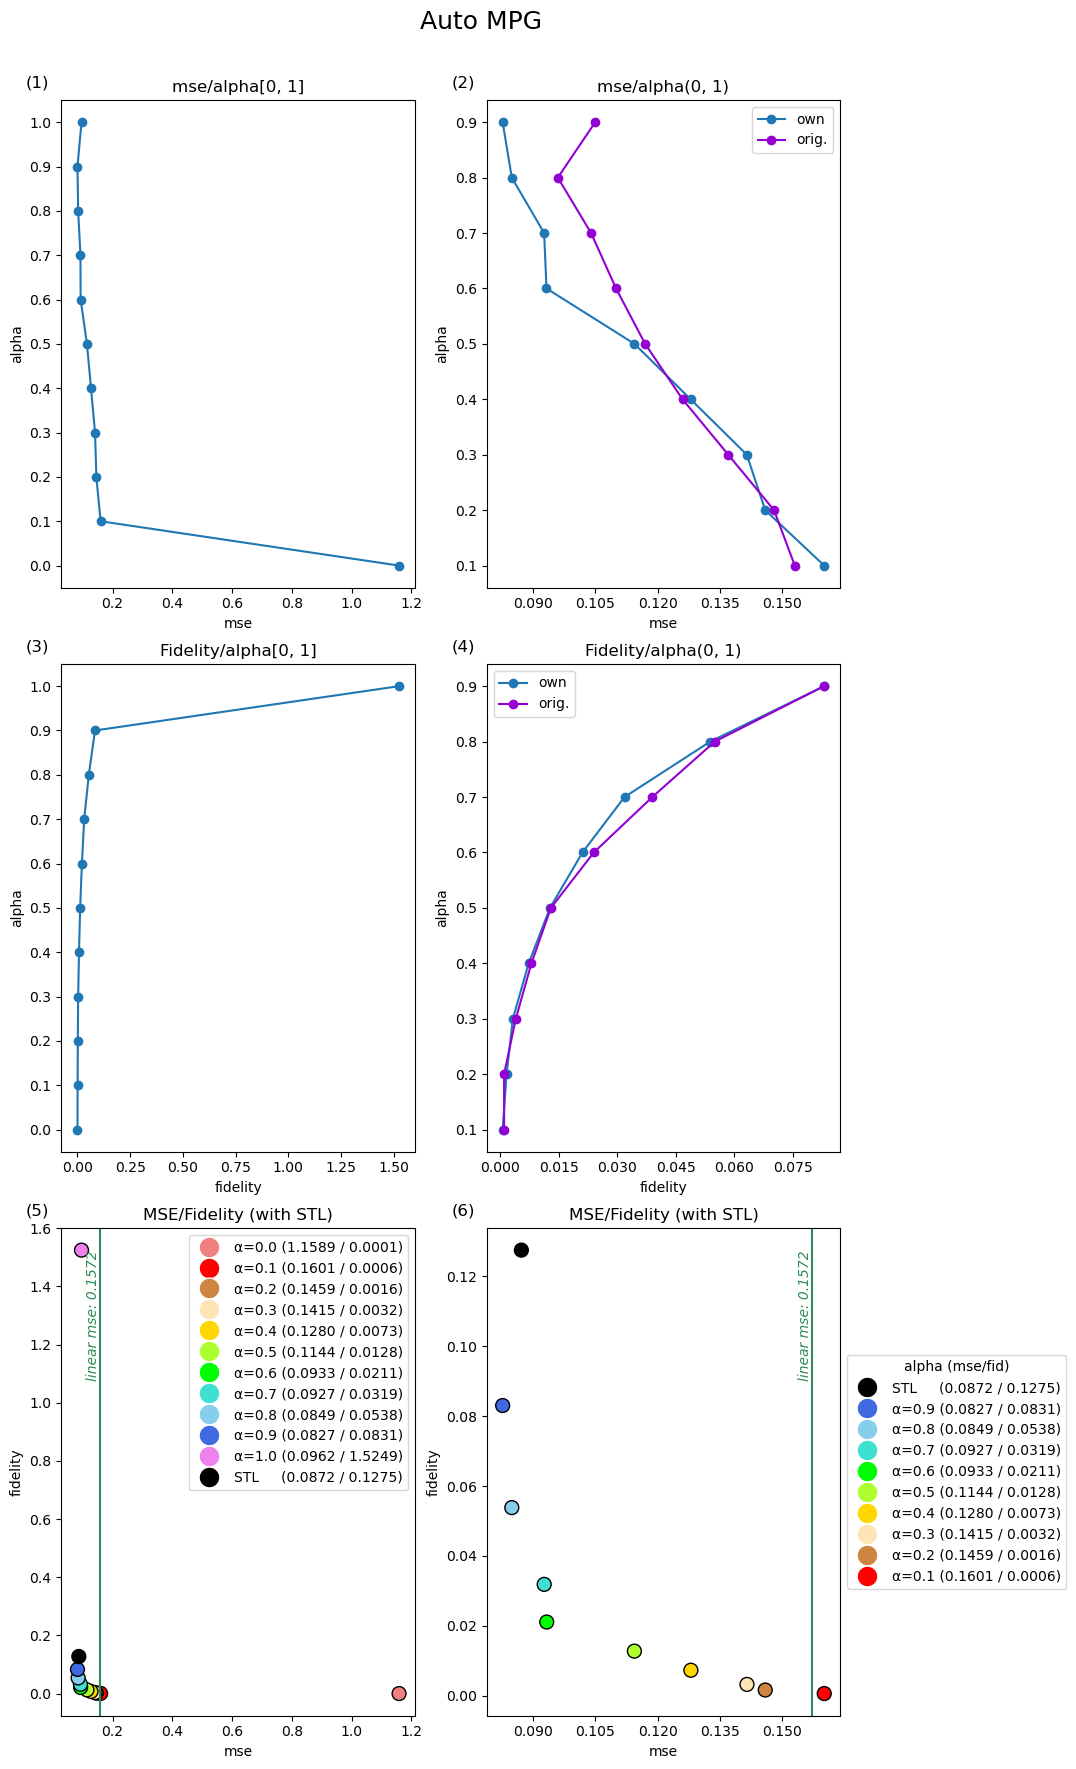

In [268]:
auto_org_results_met = [0.153, 0.148, 0.137, 0.126, 0.117, 0.110, 0.104, 0.096, 0.105]
auto_org_results_gf = [0.001, 0.001, 0.004, 0.008, 0.013, 0.024, 0.039, 0.055, 0.083]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=auto_cfg,
    org_met=auto_org_results_met,
    org_fid=auto_org_results_gf,
    title='Auto MPG'
)

### Local Explainability Evaluation

Creating Explainer

In [269]:
auto_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=auto_X_train_np,
    mode='regression',
    feature_names=auto_cfg.features.names,
    verbose=False,
    class_names=['MPG'],
    categorical_features=auto_cfg.features.categorical_indices,
    categorical_names=auto_cfg.features.values_names,
    discretize_continuous = False
)
auto_explainer

Global Neighborhood Fidelity for STL MLP

In [270]:
# load model
mlp = MLP_reg(input_size=auto_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(auto_cfg.best_parameters, auto_cfg)).to(auto_cfg.device)
mlp.load_state_dict(torch.load(auto_cfg.models.mlp_opt + '0' + auto_cfg.models.ext))

# prediction function
auto_predict_lime = partial(predict_reg_for_lime, model=mlp, config=auto_cfg)

# neighbors dataset
print(auto_X_test_np.shape)


auto_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    config=auto_cfg,
    predict_func_lime=auto_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=auto_cfg.num
)
auto_cfg.results.stl_gnf

(40, 7)


[tensor(0.1937, dtype=torch.float64),
 tensor(0.1691, dtype=torch.float64),
 tensor(0.1838, dtype=torch.float64),
 tensor(0.1776, dtype=torch.float64),
 tensor(0.2052, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [271]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    model_params=auto_cfg.best_parameters,
    config=auto_cfg,
    n=auto_cfg.num
)

auto_cfg.results.mtl_gnf

Model: Auto/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0347, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0469, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0639, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0632, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0741, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0561, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1086, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0696, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1470, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1318, dtype=torch.float64)]
Model: Auto/mtl_alpha_1.0_0.pt, GNF: [tensor(0.1549, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0315, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0448, dtype=torch.float64)]
Model: Auto/mtl_alpha_0.2

{0: {'0.0': [tensor(0.0347, dtype=torch.float64)],
  '0.1': [tensor(0.0469, dtype=torch.float64)],
  '0.2': [tensor(0.0639, dtype=torch.float64)],
  '0.3': [tensor(0.0632, dtype=torch.float64)],
  '0.4': [tensor(0.0741, dtype=torch.float64)],
  '0.5': [tensor(0.0561, dtype=torch.float64)],
  '0.6': [tensor(0.1086, dtype=torch.float64)],
  '0.7': [tensor(0.0696, dtype=torch.float64)],
  '0.8': [tensor(0.1470, dtype=torch.float64)],
  '0.9': [tensor(0.1318, dtype=torch.float64)],
  '1.0': [tensor(0.1549, dtype=torch.float64)]},
 1: {'0.0': [tensor(0.0315, dtype=torch.float64)],
  '0.1': [tensor(0.0448, dtype=torch.float64)],
  '0.2': [tensor(0.0718, dtype=torch.float64)],
  '0.3': [tensor(0.0619, dtype=torch.float64)],
  '0.4': [tensor(0.0716, dtype=torch.float64)],
  '0.5': [tensor(0.0507, dtype=torch.float64)],
  '0.6': [tensor(0.0955, dtype=torch.float64)],
  '0.7': [tensor(0.0809, dtype=torch.float64)],
  '0.8': [tensor(0.1289, dtype=torch.float64)],
  '0.9': [tensor(0.1579, dtype=to

In [272]:
show_tables_lime(auto_cfg) 

## California Housing

### Preparation

#### Configuration Settings

In [194]:
housing_cfg = Config(
    folders=Folders(base="Housing/"),
    files=Files(
        data="housing_data.pkl", 
        targets="housing_targets.pkl", 
        study='Housing.plt'
    ),
    training=Training(batch_size=64, num_epochs=250, patience=12),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [195]:
# Data Loading
housing_df = pd.read_pickle(housing_cfg.paths.data)

housing_cfg.features.numerical = housing_df.select_dtypes(include='number').columns.values.tolist()
housing_cfg.features.numerical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.numerical]
housing_cfg.features.categorical = housing_df.select_dtypes(include='object').columns.values.tolist()
housing_cfg.features.categorical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.categorical]
housing_cfg.features.names = housing_df.columns.values.tolist()


# Creating Dictionary 
housing_cfg.features.values_names = {}
for feature, idx in zip(housing_cfg.features.categorical, housing_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(housing_df[feature])
    housing_df[feature] = le.transform(housing_df[feature])
    housing_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(
    housing_df,
    np.array(pd.read_pickle(housing_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

housing_X_eval, housing_X_test, housing_y_eval, housing_y_test = train_test_split(
    housing_X_test, 
    housing_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
housing_scaler = StandardScaler()
housing_X_train[housing_cfg.features.numerical] = housing_scaler.fit_transform(housing_X_train[housing_cfg.features.numerical]).astype(float)
housing_X_train[housing_cfg.features.categorical] = housing_X_train[housing_cfg.features.categorical].astype(float)

housing_X_eval[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_eval[housing_cfg.features.numerical]).astype(float)
housing_X_eval[housing_cfg.features.categorical] = housing_X_eval[housing_cfg.features.categorical].astype(float)

housing_X_test[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_test[housing_cfg.features.numerical]).astype(float)
housing_X_test[housing_cfg.features.categorical] = housing_X_test[housing_cfg.features.categorical].astype(float)

housing_scaler_y = StandardScaler()
housing_y_train = housing_scaler_y.fit_transform(housing_y_train)
housing_y_eval = housing_scaler_y.transform(housing_y_eval)
housing_y_test = housing_scaler_y.transform(housing_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
housing_cfg.features.dummy = pd.get_dummies(housing_df.astype(float), columns=housing_cfg.features.categorical, dtype=float).columns 

housing_X_train_encoded = pd.get_dummies(housing_X_train, columns=housing_cfg.features.categorical, dtype=float)
housing_X_train_encoded = housing_X_train_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_eval_encoded = pd.get_dummies(housing_X_eval, columns=housing_cfg.features.categorical, dtype=float)
housing_X_eval_encoded = housing_X_eval_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_test_encoded = pd.get_dummies(housing_X_test, columns=housing_cfg.features.categorical, dtype=float)
housing_X_test_encoded = housing_X_test_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
housing_X_train_tensor = torch.tensor(housing_X_train_encoded, dtype=torch.float32)
housing_X_eval_tensor = torch.tensor(housing_X_eval_encoded, dtype=torch.float32)
housing_X_test_tensor = torch.tensor(housing_X_test_encoded, dtype=torch.float32)

housing_y_train_tensor = torch.tensor(housing_y_train, dtype=torch.float32)
housing_y_eval_tensor = torch.tensor(housing_y_eval, dtype=torch.float32)
housing_y_test_tensor = torch.tensor(housing_y_test, dtype=torch.float32)

housing_X_train_np = housing_X_train.values
housing_X_eval_np = housing_X_eval.values
housing_X_test_np = housing_X_test.values

# Updating Configuration 
housing_cfg.input_size = housing_X_train_tensor.shape[1]
housing_cfg.tuning.min_neurons = housing_cfg.input_size // 4 - 1
housing_cfg.tuning.max_neurons = housing_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [196]:
def train_and_optimize_housing(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=housing_X_train_tensor,
        target_train=housing_y_train_tensor,
        data_eval=housing_X_eval_tensor,
        target_eval=housing_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [197]:
def study_housing(config: Config):
    objective = partial(train_and_optimize_housing, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

housing_study = try_load_study(study_housing, housing_cfg)

In [199]:
housing_study_sorted = housing_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
housing_study_sorted.head(5)

number     value               duration  params_num_layers  \
13      13  0.191420 0 days 00:01:39.313130                  4   
15      15  0.200668 0 days 00:01:29.559918                  3   
20      20  0.201676 0 days 00:01:32.382260                  2   
23      23  0.201935 0 days 00:01:34.470497                  3   
16      16  0.202508 0 days 00:01:46.957893                  2   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
13                   32                 31.0                 16.0   
15                   26                 29.0                 15.0   
20                   30                 31.0                  NaN   
23                   30                 27.0                 15.0   
16                   33                 29.0                  NaN   

    params_num_neurons3  params_num_neurons4     state  
13                 25.0                  NaN  COMPLETE  
15                  NaN                  NaN  COMPLETE  
20                  NaN                  NaN  COMPLETE  
23                  NaN                  NaN  COMPLETE  
16                  NaN                  NaN  COMPLETE

In [201]:
housing_cfg.best_parameters = housing_study.trials[housing_study_sorted.iloc[0].number].params
housing_cfg.best_parameters 

{'num_layers': 4,
 'num_neurons0': 32,
 'num_neurons1': 31,
 'num_neurons2': 16,
 'num_neurons3': 25}

### Training and Testing MLP

In [202]:
train_and_test_mlp_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_mlp.values())))
housing_cfg.results.stl_mlp

Model Housing/mlp_opt_0.pt loaded successfully
Model Housing/mlp_opt_1.pt loaded successfully
Model Housing/mlp_opt_2.pt loaded successfully
Model Housing/mlp_opt_3.pt loaded successfully
Model Housing/mlp_opt_4.pt loaded successfully
0.20064730048179627


{0: 0.20798207819461823,
 1: 0.20043815672397614,
 2: 0.20340588688850403,
 3: 0.19917024672031403,
 4: 0.1922401338815689}

### Training and Testing Linear Model

In [203]:
train_and_test_lin_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.reg.values())))
housing_cfg.results.reg

Model Housing/reg_0.pt loaded successfully
Model Housing/reg_1.pt loaded successfully
Model Housing/reg_2.pt loaded successfully
Model Housing/reg_3.pt loaded successfully
Model Housing/reg_4.pt loaded successfully
0.36624855995178224


{0: 0.36559706926345825,
 1: 0.36614516377449036,
 2: 0.365366131067276,
 3: 0.36884424090385437,
 4: 0.36529019474983215}

### Training and Testing STL Surogate Model

Train Linear Regression to explain housing_mlp_stl model

In [204]:
train_and_test_stl_lin_reg(
    X_train=housing_X_train_tensor, 
    X_eval=housing_X_eval_tensor, 
    X_test=housing_X_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_reg.values())))
housing_cfg.results.stl_reg

Model Housing/stl_reg_0.pt loaded successfully
Model Housing/stl_reg_1.pt loaded successfully
Model Housing/stl_reg_2.pt loaded successfully
Model Housing/stl_reg_3.pt loaded successfully
Model Housing/stl_reg_4.pt loaded successfully
0.16986579000949859


{0: 0.16158492863178253,
 1: 0.15607431530952454,
 2: 0.17409038543701172,
 3: 0.16523195803165436,
 4: 0.19234736263751984}

### Train and test models in MTL approach 

MLP + LogReg, alpha in range 0, 1 with step 0.1, Fidelity on rounded outputs

In [207]:
train_and_test_mtl_reg_n_times(
    data_train=housing_X_train_tensor,
    target_train=housing_y_train_tensor,
    data_eval=housing_X_eval_tensor, 
    target_eval=housing_y_eval_tensor, 
    data_test=housing_X_test_tensor, 
    target_test=housing_y_test_tensor, 
    config=housing_cfg
)
housing_cfg.results.mtl

Model for alpha: 0.0
Model Housing/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Housing/mtl_alpha_0.0_0.pt, MSE: 0.9553137421607971, Fidelity: 1.1394337207093486e-07
Model for alpha: 0.1
Model Housing/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Housing/mtl_alpha_0.1_0.pt, MSE: 0.35353296995162964, Fidelity: 0.00029729100060649216
Model for alpha: 0.2
Model Housing/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Housing/mtl_alpha_0.2_0.pt, MSE: 0.33889710903167725, Fidelity: 0.0012965775094926357
Model for alpha: 0.3
Model Housing/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Housing/mtl_alpha_0.3_0.pt, MSE: 0.32125547528266907, Fidelity: 0.003668379271402955
Model for alpha: 0.4
Model Housing/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Housing/mtl_alpha_0.4_0.pt, MSE: 0.30351483821868896, Fidelity: 0.007401301991194487
Model for alpha: 0.5
Model Housing/mtl_alpha_0.5_0.pt loaded successfully
Result 

{0: {'0.0': Result(metrics=0.9553137421607971, fid=1.1394337207093486e-07),
  '0.1': Result(metrics=0.35353296995162964, fid=0.00029729100060649216),
  '0.2': Result(metrics=0.33889710903167725, fid=0.0012965775094926357),
  '0.3': Result(metrics=0.32125547528266907, fid=0.003668379271402955),
  '0.4': Result(metrics=0.30351483821868896, fid=0.007401301991194487),
  '0.5': Result(metrics=0.2868957817554474, fid=0.013045482337474823),
  '0.6': Result(metrics=0.2623261511325836, fid=0.02502136304974556),
  '0.7': Result(metrics=0.23611564934253693, fid=0.045424334704875946),
  '0.8': Result(metrics=0.215031698346138, fid=0.07340043038129807),
  '0.9': Result(metrics=0.20896241068840027, fid=0.10871388763189316),
  '1.0': Result(metrics=0.2042314112186432, fid=1.308787226676941)},
 1: {'0.0': Result(metrics=1.4932563304901123, fid=1.207726768370776e-06),
  '0.1': Result(metrics=0.35419267416000366, fid=0.00029137072851881385),
  '0.2': Result(metrics=0.34019801020622253, fid=0.00146699731

### Comparison of STL with MTL

In [273]:
housing_cfg.metrics_label = 'MSE'
show_tables(housing_cfg) 

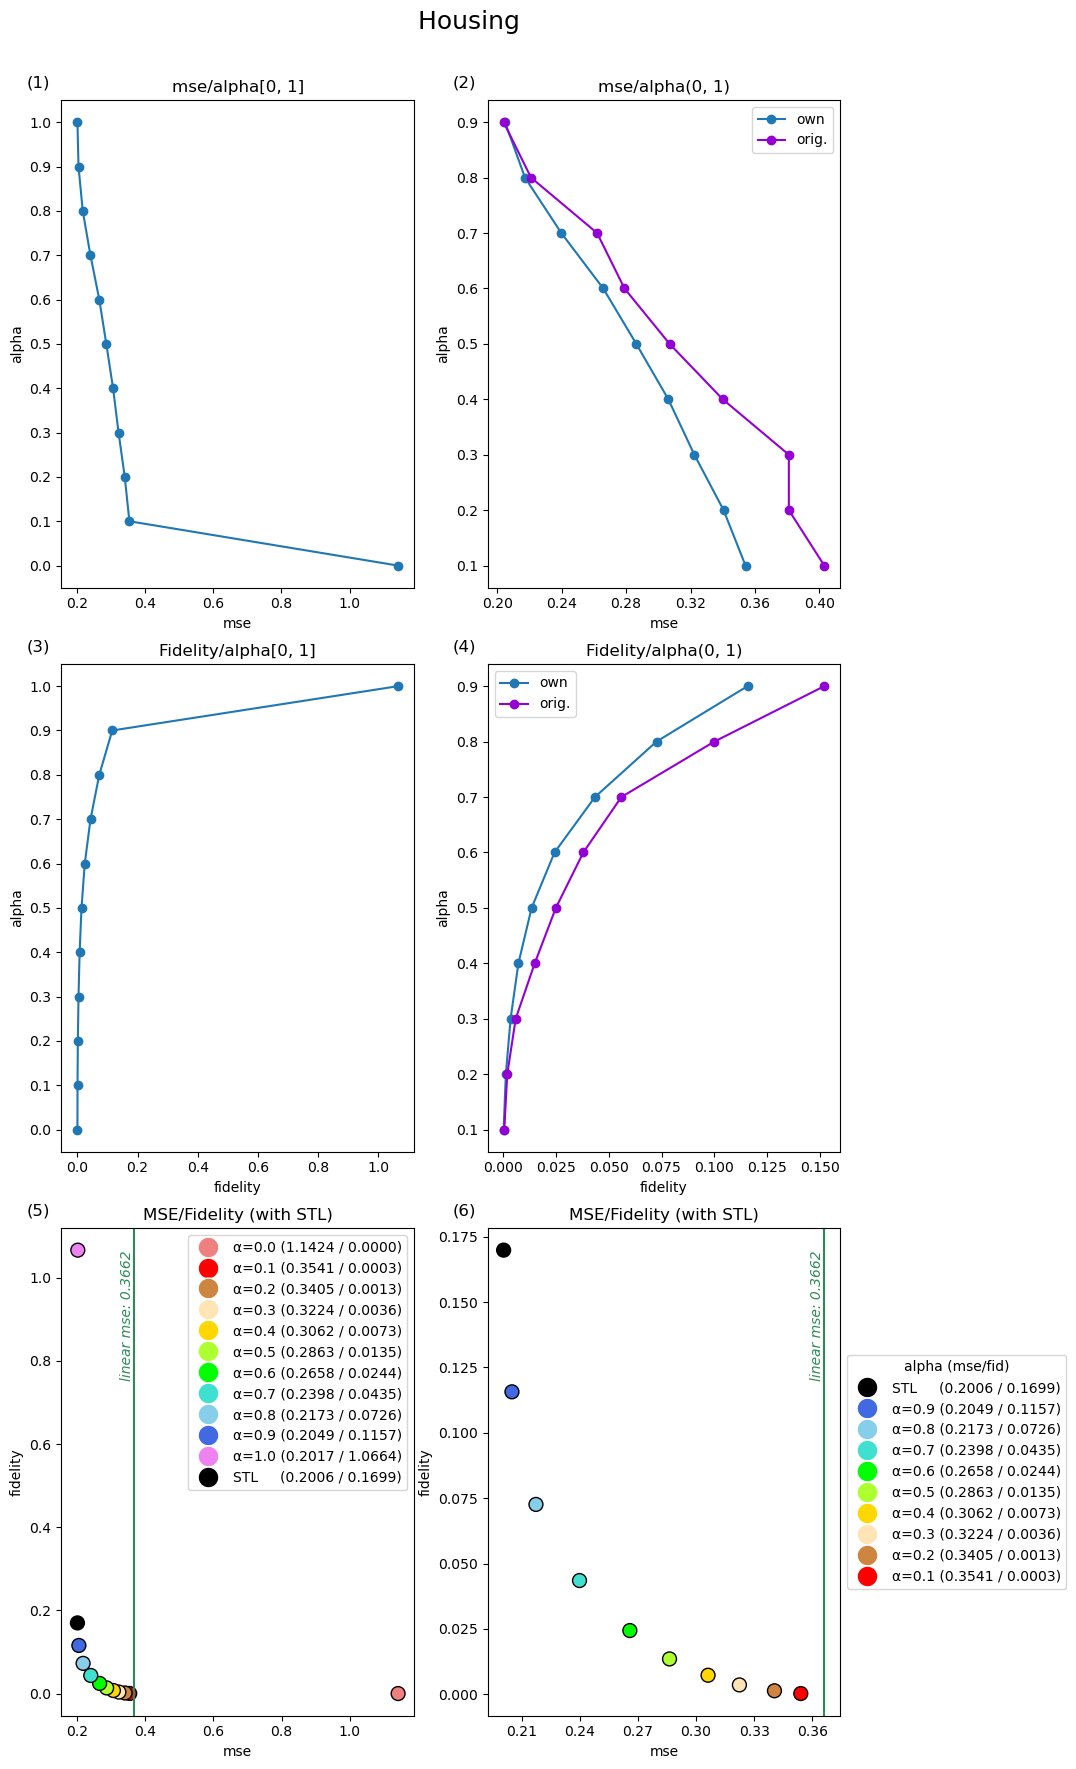

In [209]:
housing_org_results_met = [0.403, 0.381, 0.381, 0.340, 0.307, 0.279, 0.262, 0.221, 0.204]
housing_org_results_gf = [0.0006, 0.002, 0.006, 0.015, 0.025, 0.038, 0.056, 0.100, 0.152]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=housing_cfg,
    org_met=housing_org_results_met,
    org_fid=housing_org_results_gf,
    title='Housing   '
)

### Local Explainability Evaluation

Creating Explainer

In [210]:
housing_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=housing_X_train_np,
    mode='regression',
    feature_names=housing_cfg.features.names,
    verbose=False,
    class_names=['Value'],
    categorical_features=housing_cfg.features.categorical_indices,
    categorical_names=housing_cfg.features.values_names,
    discretize_continuous = False
)
housing_explainer

Global Neighborhood Fidelity for STL MLP

In [211]:
# load model
mlp = MLP_reg(input_size=housing_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(housing_cfg.best_parameters, housing_cfg)).to(housing_cfg.device)
mlp.load_state_dict(torch.load(housing_cfg.models.mlp_opt + '0' + housing_cfg.models.ext))

# prediction functinon
housing_predict_lime = partial(predict_reg_for_lime, model=mlp, config=housing_cfg)

# neighbors dataset
num_rows = 500
housing_indices = torch.randperm(housing_X_test_np.shape[0])[:num_rows]
housing_neighbors_dataset = housing_X_test_np[housing_indices]
print(housing_neighbors_dataset.shape)


housing_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=housing_neighbors_dataset,
    explainer=housing_explainer,
    config=housing_cfg,
    predict_func_lime=housing_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=auto_cfg.num
)
housing_cfg.results.stl_gnf

(500, 8)


[tensor(0.6377, dtype=torch.float64),
 tensor(0.6185, dtype=torch.float64),
 tensor(0.6567, dtype=torch.float64),
 tensor(0.6689, dtype=torch.float64),
 tensor(0.6407, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [275]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=housing_neighbors_dataset,
    explainer=housing_explainer,
    model_params=housing_cfg.best_parameters,
    config=housing_cfg,
    n=housing_cfg.num
)

Model: Housing/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0014, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.1_0.pt, GNF: [tensor(0.3051, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.2_0.pt, GNF: [tensor(0.3316, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.3_0.pt, GNF: [tensor(0.3230, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.4_0.pt, GNF: [tensor(0.3516, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.5_0.pt, GNF: [tensor(0.3758, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.6_0.pt, GNF: [tensor(0.4298, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.7_0.pt, GNF: [tensor(0.4387, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.8_0.pt, GNF: [tensor(0.5705, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.9_0.pt, GNF: [tensor(0.5763, dtype=torch.float64)]
Model: Housing/mtl_alpha_1.0_0.pt, GNF: [tensor(0.8253, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0014, dtype=torch.float64)]
Model: Housing/mtl_alpha_0.1_0.pt, GNF: [tensor(0.3211, dtype=to

In [276]:
show_tables_lime(housing_cfg) 

## Wine

### Preparation

#### Configuration Settings

In [216]:
wine_cfg = Config(
    folders=Folders(base="Wine/"),
    files=Files(
        data="wine_data.pkl", 
        targets="wine_targets.pkl", 
        study='Wine.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=32),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [217]:
# Data Loading
wine_df = pd.read_pickle(wine_cfg.paths.data)

wine_cfg.features.numerical = wine_df.select_dtypes(include='number').columns.values.tolist()
wine_cfg.features.numerical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.numerical]
wine_cfg.features.categorical = wine_df.select_dtypes(include='object').columns.values.tolist()
wine_cfg.features.categorical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.categorical]
wine_cfg.features.names = wine_df.columns.values.tolist()


# Creating Dictionary 
wine_cfg.features.values_names = {}
for feature, idx in zip(wine_cfg.features.categorical, wine_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(wine_df[feature])
    wine_df[feature] = le.transform(wine_df[feature])
    wine_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine_df,
    np.array(pd.read_pickle(wine_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

wine_X_eval, wine_X_test, wine_y_eval, wine_y_test = train_test_split(
    wine_X_test, 
    wine_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
wine_scaler = StandardScaler()
wine_X_train[wine_cfg.features.numerical] = wine_scaler.fit_transform(wine_X_train[wine_cfg.features.numerical]).astype(float)
wine_X_train[wine_cfg.features.categorical] = wine_X_train[wine_cfg.features.categorical].astype(float)

wine_X_eval[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_eval[wine_cfg.features.numerical]).astype(float)
wine_X_eval[wine_cfg.features.categorical] = wine_X_eval[wine_cfg.features.categorical].astype(float)

wine_X_test[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_test[wine_cfg.features.numerical]).astype(float)
wine_X_test[wine_cfg.features.categorical] = wine_X_test[wine_cfg.features.categorical].astype(float)


wine_scaler_y = StandardScaler()
wine_y_train = wine_scaler_y.fit_transform(wine_y_train)
wine_y_eval = wine_scaler_y.transform(wine_y_eval)
wine_y_test = wine_scaler_y.transform(wine_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
wine_cfg.features.dummy = pd.get_dummies(wine_df.astype(float), columns=wine_cfg.features.categorical, dtype=float).columns 

wine_X_train_encoded = pd.get_dummies(wine_X_train, columns=wine_cfg.features.categorical, dtype=float)
wine_X_train_encoded = wine_X_train_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_eval_encoded = pd.get_dummies(wine_X_eval, columns=wine_cfg.features.categorical, dtype=float)
wine_X_eval_encoded = wine_X_eval_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_test_encoded = pd.get_dummies(wine_X_test, columns=wine_cfg.features.categorical, dtype=float)
wine_X_test_encoded = wine_X_test_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
wine_X_train_tensor = torch.tensor(wine_X_train_encoded, dtype=torch.float32)
wine_X_eval_tensor = torch.tensor(wine_X_eval_encoded, dtype=torch.float32)
wine_X_test_tensor = torch.tensor(wine_X_test_encoded, dtype=torch.float32)

wine_y_train_tensor = torch.tensor(wine_y_train, dtype=torch.float32)
wine_y_eval_tensor = torch.tensor(wine_y_eval, dtype=torch.float32)
wine_y_test_tensor = torch.tensor(wine_y_test, dtype=torch.float32)

wine_X_train_np = wine_X_train.values
wine_X_eval_np = wine_X_eval.values
wine_X_test_np = wine_X_test.values

# Updating Configuration 
wine_cfg.input_size = wine_X_train_tensor.shape[1]
wine_cfg.tuning.min_neurons = wine_cfg.input_size // 4 - 1
wine_cfg.tuning.max_neurons = wine_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [218]:
def train_and_optimize_wine(trial, config: Config):
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=wine_X_train_tensor,
        target_train=wine_y_train_tensor,
        data_eval=wine_X_eval_tensor,
        target_eval=wine_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [219]:
def study_wine(config: Config):
    objective = partial(train_and_optimize_wine, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

wine_study = try_load_study(study_wine, wine_cfg)

In [220]:
wine_study_sorted = wine_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
wine_study_sorted.head(5)

number     value               duration  params_num_layers  \
33      33  0.500907 0 days 00:00:07.761408                  2   
43      43  0.510618 0 days 00:00:06.457184                  4   
7        7  0.515078 0 days 00:00:15.047941                  2   
19      19  0.520246 0 days 00:00:06.776386                  2   
41      41  0.520530 0 days 00:00:04.329740                  4   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
33                   42                 24.0                  NaN   
43                   36                 44.0                  5.0   
7                    38                  3.0                  NaN   
19                   30                 12.0                  NaN   
41                   39                 36.0                 17.0   

    params_num_neurons3  params_num_neurons4     state  
33                  NaN                  NaN  COMPLETE  
43                 24.0                  NaN  COMPLETE  
7                   NaN                  NaN  COMPLETE  
19                  NaN                  NaN  COMPLETE  
41                 26.0                  NaN  COMPLETE

In [221]:
wine_cfg.best_parameters = wine_study.trials[wine_study_sorted.iloc[0].number].params
wine_cfg.best_parameters

{'num_layers': 2, 'num_neurons0': 42, 'num_neurons1': 24}

### Training and Testing MLP

In [222]:
train_and_test_mlp_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_mlp.values())))
wine_cfg.results.stl_mlp

Model Wine/mlp_opt_0.pt loaded successfully
Model Wine/mlp_opt_1.pt loaded successfully
Model Wine/mlp_opt_2.pt loaded successfully
Model Wine/mlp_opt_3.pt loaded successfully
Model Wine/mlp_opt_4.pt loaded successfully
0.6265387058258056


{0: 0.6444972157478333,
 1: 0.6329270005226135,
 2: 0.6132732033729553,
 3: 0.6196596622467041,
 4: 0.6223364472389221}

### Training and Testing Linear Model

In [223]:
train_and_test_lin_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.reg.values())))
wine_cfg.results.reg

Model Wine/reg_0.pt loaded successfully
Model Wine/reg_1.pt loaded successfully
Model Wine/reg_2.pt loaded successfully
Model Wine/reg_3.pt loaded successfully
Model Wine/reg_4.pt loaded successfully
0.6557277083396912


{0: 0.6487641930580139,
 1: 0.6670450568199158,
 2: 0.656655490398407,
 3: 0.6469407081604004,
 4: 0.6592330932617188}

### Training and Testing STL Surogate Model

Train Linear Regression to explain wine_mlp_stl model

In [224]:
train_and_test_stl_lin_reg(
    X_train=wine_X_train_tensor, 
    X_eval=wine_X_eval_tensor, 
    X_test=wine_X_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_reg.values())))
wine_cfg.results.stl_reg

Model Wine/stl_reg_0.pt loaded successfully
Model Wine/stl_reg_1.pt loaded successfully
Model Wine/stl_reg_2.pt loaded successfully
Model Wine/stl_reg_3.pt loaded successfully
Model Wine/stl_reg_4.pt loaded successfully
0.06951482072472573


{0: 0.08603735268115997,
 1: 0.07350988686084747,
 2: 0.06872521340847015,
 3: 0.05231377109885216,
 4: 0.06698787957429886}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [228]:
train_and_test_mtl_reg_n_times(
    data_train=wine_X_train_tensor,
    target_train=wine_y_train_tensor,
    data_eval=wine_X_eval_tensor, 
    target_eval=wine_y_eval_tensor, 
    data_test=wine_X_test_tensor, 
    target_test=wine_y_test_tensor, 
    config=wine_cfg
)
wine_cfg.results.mtl

Model for alpha: 0.0
Model Wine/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.0_0.pt, MSE: 1.378847360610962, Fidelity: 1.7606520486879162e-05
Model for alpha: 0.1
Model Wine/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.1_0.pt, MSE: 0.6471073031425476, Fidelity: 0.0007901379722170532
Model for alpha: 0.2
Model Wine/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.2_0.pt, MSE: 0.6388683319091797, Fidelity: 0.002186032710596919
Model for alpha: 0.3
Model Wine/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.3_0.pt, MSE: 0.6264545321464539, Fidelity: 0.0062066600657999516
Model for alpha: 0.4
Model Wine/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.4_0.pt, MSE: 0.62045818567276, Fidelity: 0.007078320719301701
Model for alpha: 0.5
Model Wine/mtl_alpha_0.5_0.pt loaded successfully
Result on test dataset: Wine/mtl_alpha_0.5_0.pt,

{0: {'0.0': Result(metrics=1.378847360610962, fid=1.7606520486879162e-05),
  '0.1': Result(metrics=0.6471073031425476, fid=0.0007901379722170532),
  '0.2': Result(metrics=0.6388683319091797, fid=0.002186032710596919),
  '0.3': Result(metrics=0.6264545321464539, fid=0.0062066600657999516),
  '0.4': Result(metrics=0.62045818567276, fid=0.007078320719301701),
  '0.5': Result(metrics=0.6108199954032898, fid=0.017435012385249138),
  '0.6': Result(metrics=0.6176782250404358, fid=0.028662946075201035),
  '0.7': Result(metrics=0.6077611446380615, fid=0.03796644136309624),
  '0.8': Result(metrics=0.6152499318122864, fid=0.05672808364033699),
  '0.9': Result(metrics=0.6026071310043335, fid=0.06694678962230682),
  '1.0': Result(metrics=0.6000400185585022, fid=0.8952798247337341)},
 1: {'0.0': Result(metrics=1.3306323289871216, fid=2.4134038540069014e-05),
  '0.1': Result(metrics=0.6363160610198975, fid=0.001116522355005145),
  '0.2': Result(metrics=0.6273491978645325, fid=0.0013772008242085576),


### Comparison of STL with MTL

In [243]:
wine_cfg.metrics_label = 'MSE'
show_tables(wine_cfg) 

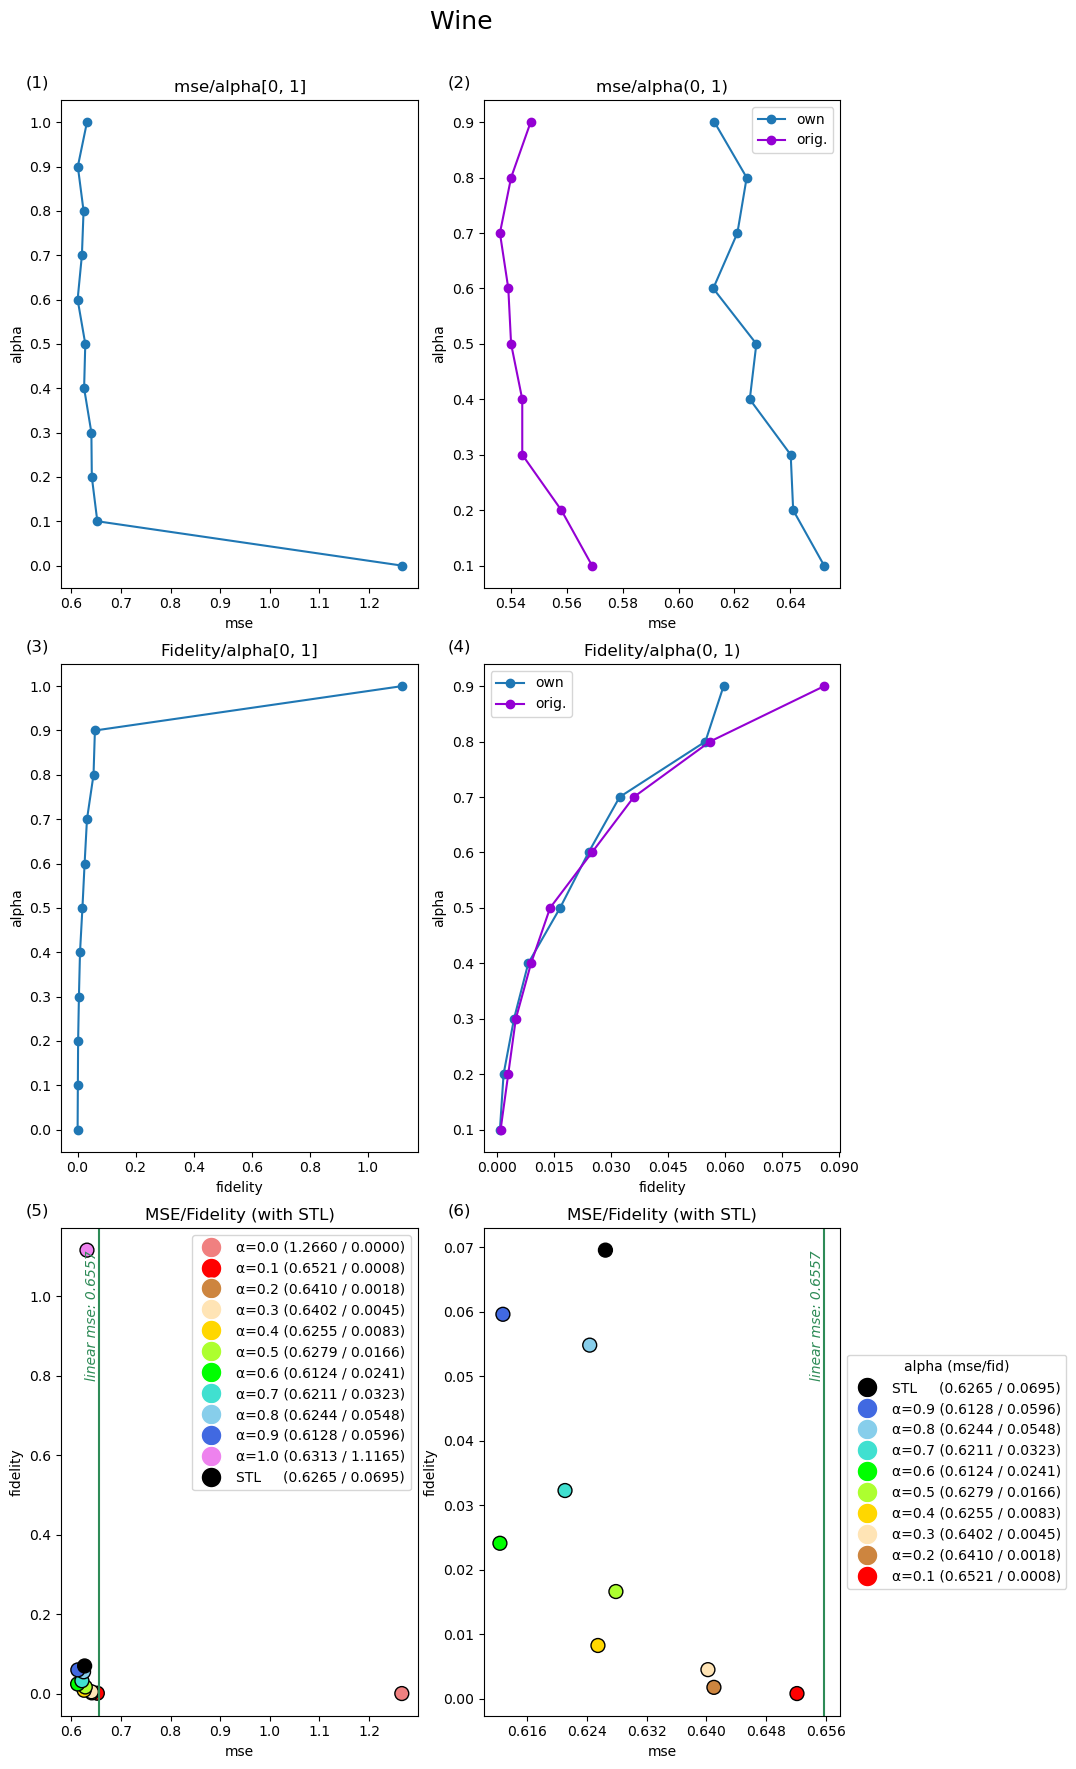

In [230]:
wine_org_results_met = [0.569, 0.558, 0.544, 0.544, 0.540, 0.539, 0.536, 0.540, 0.547]
wine_org_results_gf = [0.001, 0.003, 0.005, 0.009, 0.014, 0.025, 0.036, 0.056, 0.086]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=wine_cfg,
    org_met=wine_org_results_met,
    org_fid=wine_org_results_gf,
    title='Wine     '
)

### Local Explainability Evaluation

Creating Explainer

In [231]:
wine_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=wine_X_train_np,
    mode='regression',
    feature_names=wine_cfg.features.names,
    verbose=False,
    class_names=['quality'],
    categorical_features=wine_cfg.features.categorical_indices,
    categorical_names=wine_cfg.features.values_names,
    discretize_continuous=False
)
wine_explainer

Global Neighborhood Fidelity for STL MLP

In [232]:
# load model
mlp = MLP_reg(input_size=wine_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(wine_cfg.best_parameters, wine_cfg)).to(wine_cfg.device)
mlp.load_state_dict(torch.load(wine_cfg.models.mlp_opt + '0' + wine_cfg.models.ext))

# prediction function
wine_predict_lime = partial(predict_reg_for_lime, model=mlp, config=wine_cfg)

# neighbors dataset
wine_neighbors_dataset = wine_X_test_np
print(wine_neighbors_dataset.shape)


wine_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=wine_neighbors_dataset,
    explainer=wine_explainer,
    config=wine_cfg,
    predict_func_lime=wine_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=wine_cfg.num
)
wine_cfg.results.stl_gnf

(136, 11)


[tensor(0.1479, dtype=torch.float64),
 tensor(0.1599, dtype=torch.float64),
 tensor(0.1568, dtype=torch.float64),
 tensor(0.1588, dtype=torch.float64),
 tensor(0.1550, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [249]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=wine_neighbors_dataset,
    explainer=wine_explainer,
    model_params=wine_cfg.best_parameters,
    config=wine_cfg,
    n=wine_cfg.num
)

Model: Wine/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0073, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0489, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0489, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0538, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0533, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0600, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.6_0.pt, GNF: [tensor(0.0970, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0902, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1309, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1217, dtype=torch.float64)]
Model: Wine/mtl_alpha_1.0_0.pt, GNF: [tensor(0.0977, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0076, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0476, dtype=torch.float64)]
Model: Wine/mtl_alpha_0.2

In [254]:
show_tables_lime(wine_cfg) 

## Adult

### Preparation

#### Configuration Settings

In [277]:
adult_cfg = Config(
    folders=Folders(base="Adult/"),
    files=Files(
        data="adult_data.pkl", 
        targets="adult_targets.pkl", 
        study='Adult.plt'
    ),
    training=Training(batch_size=64),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [278]:
# Data Loading
adult_df = pd.read_pickle(adult_cfg.paths.data)

adult_cfg.features.numerical = adult_df.select_dtypes(include='number').columns.values.tolist()
adult_cfg.features.numerical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.numerical]
adult_cfg.features.categorical = adult_df.select_dtypes(include='object').columns.values.tolist()
adult_cfg.features.categorical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.categorical]
adult_cfg.features.names = adult_df.columns.values.tolist()


# Creating Dictionary 
adult_cfg.features.values_names = {}
for feature, idx in zip(adult_cfg.features.categorical, adult_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(adult_df[feature])
    adult_df[feature] = le.transform(adult_df[feature])
    adult_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
adult_X_train, adult_X_test, adult_y_train, adult_y_test = train_test_split(
    adult_df,
    np.array(pd.read_pickle(adult_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

adult_X_eval, adult_X_test, adult_y_eval, adult_y_test = train_test_split(
    adult_X_test, 
    adult_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
adult_scaler = StandardScaler()
adult_X_train[adult_cfg.features.numerical] = adult_scaler.fit_transform(adult_X_train[adult_cfg.features.numerical]).astype(float)
adult_X_train[adult_cfg.features.categorical] = adult_X_train[adult_cfg.features.categorical].astype(float)

adult_X_eval[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_eval[adult_cfg.features.numerical]).astype(float)
adult_X_eval[adult_cfg.features.categorical] = adult_X_eval[adult_cfg.features.categorical].astype(float)

adult_X_test[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_test[adult_cfg.features.numerical]).astype(float)
adult_X_test[adult_cfg.features.categorical] = adult_X_test[adult_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
adult_cfg.features.dummy = pd.get_dummies(adult_df.astype(float), columns=adult_cfg.features.categorical, dtype=float).columns 

adult_X_train_encoded = pd.get_dummies(adult_X_train, columns=adult_cfg.features.categorical, dtype=float)
adult_X_train_encoded = adult_X_train_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_eval_encoded = pd.get_dummies(adult_X_eval, columns=adult_cfg.features.categorical, dtype=float)
adult_X_eval_encoded = adult_X_eval_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_test_encoded = pd.get_dummies(adult_X_test, columns=adult_cfg.features.categorical, dtype=float)
adult_X_test_encoded = adult_X_test_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
adult_X_train_tensor = torch.tensor(adult_X_train_encoded, dtype=torch.float32)
adult_X_eval_tensor = torch.tensor(adult_X_eval_encoded, dtype=torch.float32)
adult_X_test_tensor = torch.tensor(adult_X_test_encoded, dtype=torch.float32)

adult_y_train_tensor = torch.tensor(adult_y_train, dtype=torch.float32)
adult_y_eval_tensor = torch.tensor(adult_y_eval, dtype=torch.float32)
adult_y_test_tensor = torch.tensor(adult_y_test, dtype=torch.float32)

adult_X_train_np = adult_X_train.values
adult_X_eval_np = adult_X_eval.values
adult_X_test_np = adult_X_test.values

# Updating Configuration 
adult_cfg.input_size = adult_X_train_tensor.shape[1]
adult_cfg.tuning.min_neurons = adult_cfg.input_size // 4 - 1
adult_cfg.tuning.max_neurons = adult_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [279]:
def train_and_optimize_adult(trial, config: Config):
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_with_early_stopping(
        data_train=adult_X_train_tensor,
        target_train=adult_y_train_tensor,
        data_eval=adult_X_eval_tensor,
        target_eval=adult_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [280]:
def study_adult(config: Config):
    objective = partial(train_and_optimize_adult, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

adult_study = try_load_study(study_adult, adult_cfg)

In [281]:
adult_study_sorted = adult_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1)
adult_study_sorted.head(5)

number     value               duration  params_num_layers  \
9        9  0.857269 0 days 00:00:24.640187                  2   
17      17  0.855942 0 days 00:00:34.097176                  2   
14      14  0.855278 0 days 00:00:32.678021                  2   
8        8  0.855056 0 days 00:00:38.689916                  1   
24      24  0.854171 0 days 00:00:25.166934                  3   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
9                   132                273.0                  NaN   
17                   35                406.0                  NaN   
14                   94                339.0                  NaN   
8                   311                  NaN                  NaN   
24                  169                310.0                384.0   

    params_num_neurons3  params_num_neurons4     state  
9                   NaN                  NaN  COMPLETE  
17                  NaN                  NaN  COMPLETE  
14                  NaN                  NaN  COMPLETE  
8                   NaN                  NaN  COMPLETE  
24                  NaN                  NaN  COMPLETE

In [282]:
adult_cfg.best_parameters = adult_study.trials[adult_study_sorted.iloc[0].number].params
adult_cfg.best_parameters

{'num_layers': 2, 'num_neurons0': 132, 'num_neurons1': 273}

### Training and Testing MLP

In [283]:
train_and_test_mlp_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_mlp.values())))
adult_cfg.results.stl_mlp

Model Adult/mlp_opt_0.pt loaded successfully
Model Adult/mlp_opt_1.pt loaded successfully
Model Adult/mlp_opt_2.pt loaded successfully
Model Adult/mlp_opt_3.pt loaded successfully
Model Adult/mlp_opt_4.pt loaded successfully
0.8519468903541565


{0: 0.8513274192810059,
 1: 0.8504424691200256,
 2: 0.8480088710784912,
 3: 0.8559734225273132,
 4: 0.8539822697639465}

### Training and Testing Linear Model

In [284]:
train_and_test_lin_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.reg.values())))
adult_cfg.results.reg

Model Adult/reg_0.pt loaded successfully
Model Adult/reg_1.pt loaded successfully
Model Adult/reg_2.pt loaded successfully
Model Adult/reg_3.pt loaded successfully
Model Adult/reg_4.pt loaded successfully
0.8504867315292358


{0: 0.8506637215614319,
 1: 0.8506637215614319,
 2: 0.8504424691200256,
 3: 0.8500000238418579,
 4: 0.8506637215614319}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [285]:
train_and_test_stl_lin_cls(
    X_train=adult_X_train_tensor, 
    X_eval=adult_X_eval_tensor, 
    X_test=adult_X_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_reg.values())))
adult_cfg.results.stl_reg

Model Adult/stl_reg_0.pt loaded successfully
Model Adult/stl_reg_1.pt loaded successfully
Model Adult/stl_reg_2.pt loaded successfully
Model Adult/stl_reg_3.pt loaded successfully
Model Adult/stl_reg_4.pt loaded successfully
0.04287610650062561


{0: 0.04668141528964043,
 1: 0.0358407087624073,
 2: 0.05309734493494034,
 3: 0.04402654990553856,
 4: 0.034734513610601425}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [293]:
train_and_test_mtl_cls_n_times(
    data_train=adult_X_train_tensor,
    target_train=adult_y_train_tensor,
    data_eval=adult_X_eval_tensor, 
    target_eval=adult_y_eval_tensor, 
    data_test=adult_X_test_tensor, 
    target_test=adult_y_test_tensor, 
    config=adult_cfg
)
adult_cfg.results.mtl

Model for alpha: 0.0
Model Adult/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.0_0.pt, Accuracy: 0.7484513521194458, Fidelity: 0.00022123893722891808
Model for alpha: 0.1
Model Adult/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.1_0.pt, Accuracy: 0.8497787714004517, Fidelity: 0.014823008328676224
Model for alpha: 0.2
Model Adult/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.2_0.pt, Accuracy: 0.8526548743247986, Fidelity: 0.01902654767036438
Model for alpha: 0.3
Model Adult/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.3_0.pt, Accuracy: 0.8530973196029663, Fidelity: 0.03362831845879555
Model for alpha: 0.4
Model Adult/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.4_0.pt, Accuracy: 0.8533185720443726, Fidelity: 0.03694690391421318
Model for alpha: 0.5
Model Adult/mtl_alpha_0.5_0.pt loaded successfully
Result on test

{0: {'0.0': Result(metrics=0.7484513521194458, fid=0.00022123893722891808),
  '0.1': Result(metrics=0.8497787714004517, fid=0.014823008328676224),
  '0.2': Result(metrics=0.8526548743247986, fid=0.01902654767036438),
  '0.3': Result(metrics=0.8530973196029663, fid=0.03362831845879555),
  '0.4': Result(metrics=0.8533185720443726, fid=0.03694690391421318),
  '0.5': Result(metrics=0.8515486717224121, fid=0.0358407087624073),
  '0.6': Result(metrics=0.8488938212394714, fid=0.04247787594795227),
  '0.7': Result(metrics=0.855088472366333, fid=0.04800884798169136),
  '0.8': Result(metrics=0.8522123694419861, fid=0.05287610739469528),
  '0.9': Result(metrics=0.8524336218833923, fid=0.06305309385061264),
  '1.0': Result(metrics=0.8559734225273132, fid=0.5119469165802002)},
 1: {'0.0': Result(metrics=0.7464601993560791, fid=0.0),
  '0.1': Result(metrics=0.8539822697639465, fid=0.014823008328676224),
  '0.2': Result(metrics=0.8519911766052246, fid=0.024115044623613358),
  '0.3': Result(metrics=0.

### Comparison of STL with MTL

In [294]:
adult_cfg.metrics_label = "ACC"
show_tables(adult_cfg) 

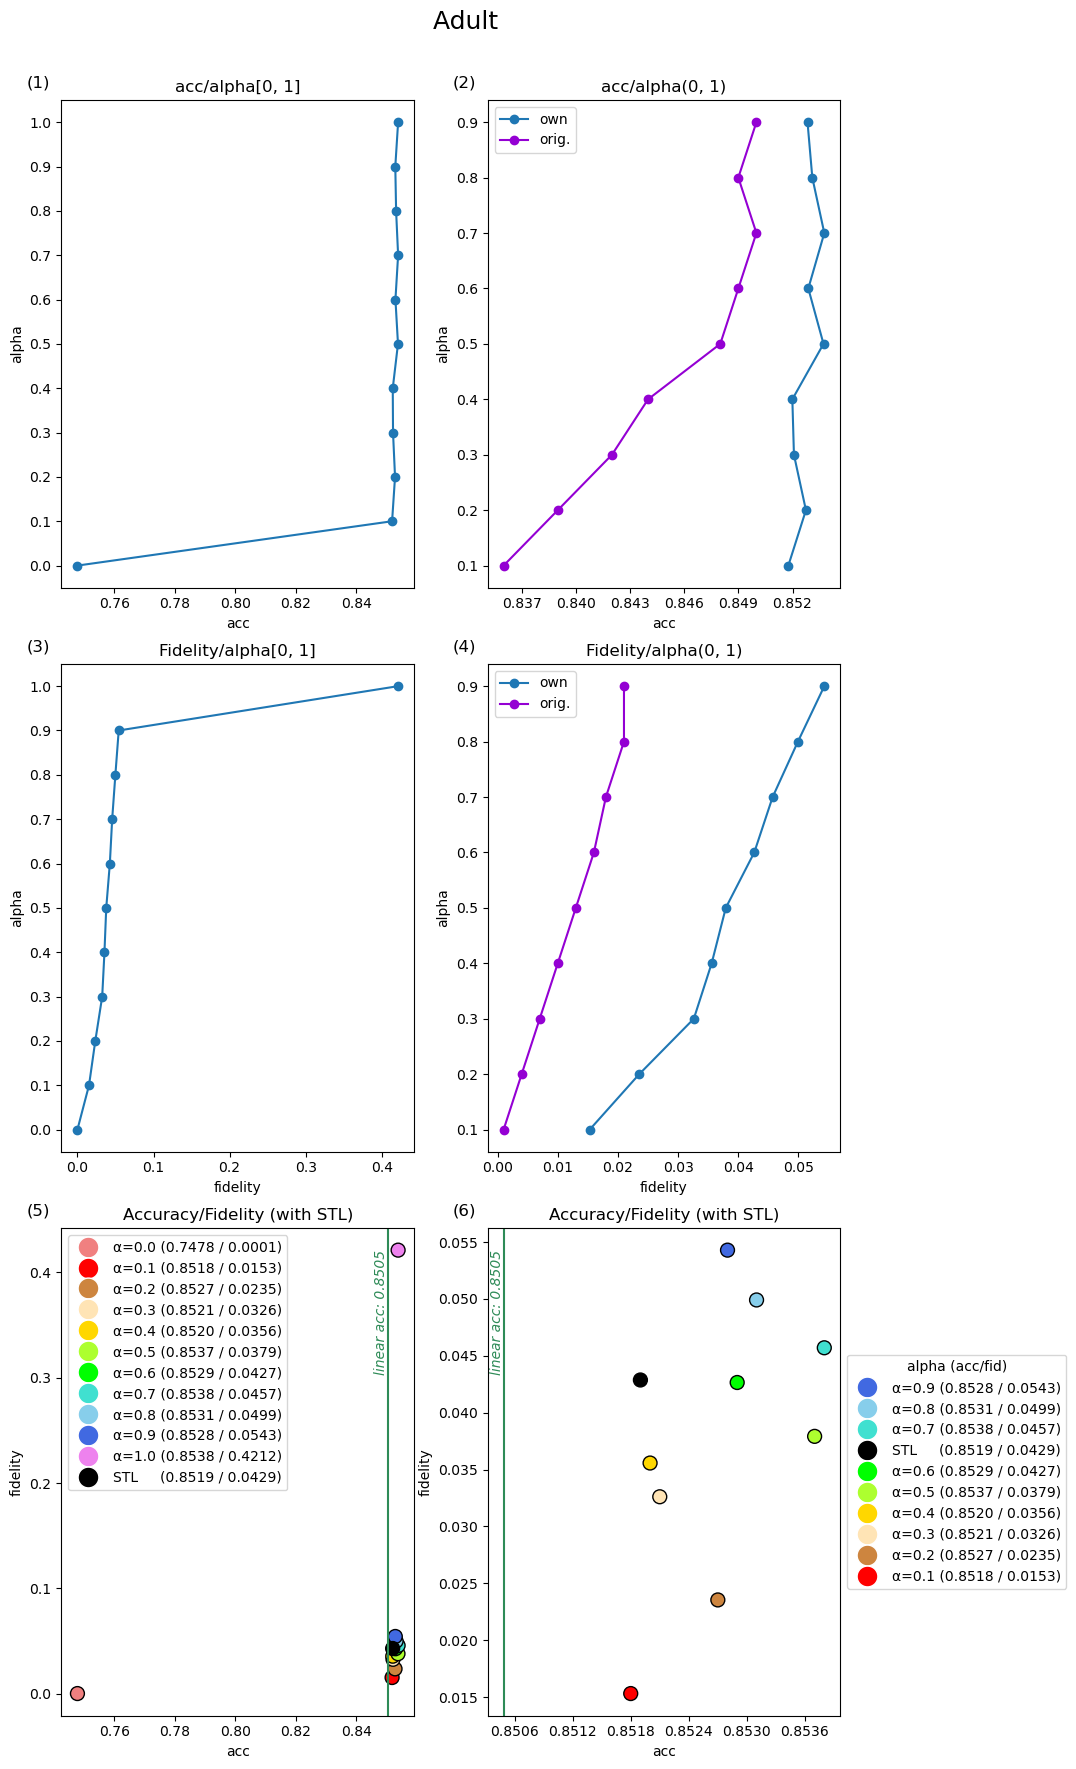

In [295]:
adult_org_results_met = [0.836,0.839,0.842,0.844,0.848,0.849,0.850,0.849,0.850]
adult_org_results_gf = [0.001,0.004,0.007,0.010,0.013,0.016,0.018,0.021,0.021]

draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=adult_cfg,
    org_met=adult_org_results_met,
    org_fid=adult_org_results_gf,
    title='Adult    '
)

### Local Explainability Evaluation

Creating Explainer

In [296]:
adult_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=adult_X_train_np,
    mode='classification',
    feature_names=adult_cfg.features.names,
    verbose=False,
    class_names=['below 50k', 'above 50k'],
    categorical_features=adult_cfg.features.categorical_indices,
    categorical_names=adult_cfg.features.values_names,
    discretize_continuous=False
)
adult_explainer

Global Neighborhood Fidelity for STL MLP

In [297]:
# load model
mlp = MLP_cls(input_size=adult_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(adult_cfg.best_parameters, adult_cfg)).to(adult_cfg.device)
mlp.load_state_dict(torch.load(adult_cfg.models.mlp_opt + '0' + adult_cfg.models.ext))

# prediction function
adult_predict_lime = partial(predict_cls_for_lime, model=mlp, config=adult_cfg)

# neighbors dataset
num_rows = 500
adult_indices = torch.randperm(adult_X_test_np.shape[0])[:num_rows]
adult_neighbors_dataset = adult_X_test_np[adult_indices]
print(adult_neighbors_dataset.shape)


adult_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    config=adult_cfg,
    predict_func_lime=adult_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=adult_cfg.num
)
adult_cfg.results.stl_gnf

(500, 13)


[tensor(0.0658),
 tensor(0.0632),
 tensor(0.0612),
 tensor(0.0668),
 tensor(0.0692)]

Global Neighborhood Fidelity for MTL

In [298]:
gnf_for_mtl_cls_for_alpha_list(
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    model_params=adult_cfg.best_parameters,
    config=adult_cfg,
    n=adult_cfg.num
)

Model: Adult/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0004)]
Model: Adult/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0308)]
Model: Adult/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0430)]
Model: Adult/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0582)]
Model: Adult/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0436)]
Model: Adult/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0592)]
Model: Adult/mtl_alpha_0.6_0.pt, GNF: [tensor(0.0690)]
Model: Adult/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0836)]
Model: Adult/mtl_alpha_0.8_0.pt, GNF: [tensor(0.0768)]
Model: Adult/mtl_alpha_0.9_0.pt, GNF: [tensor(0.0514)]
Model: Adult/mtl_alpha_1.0_0.pt, GNF: [tensor(0.0560)]
Model: Adult/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0008)]
Model: Adult/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0316)]
Model: Adult/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0394)]
Model: Adult/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0526)]
Model: Adult/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0434)]
Model: Adult/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0540)]
Model: Adult/mtl_alpha_0.6_0.pt, GNF: [tensor(0.0644)]
Model: Adu

In [299]:
show_tables_lime(adult_cfg) 

## Titanic

### Preparation

#### Configuration Settings

In [300]:
titanic_cfg = Config(
    folders=Folders(base="Titanic/"),
    files=Files(
        data="titanic_data.pkl", 
        targets="titanic_targets.pkl", 
        study='Titanic.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [301]:
# Data Loading
titanic_df = pd.read_pickle(titanic_cfg.paths.data)

titanic_cfg.features.numerical = titanic_df.select_dtypes(include='number').columns.values.tolist()
titanic_cfg.features.numerical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.numerical]
titanic_cfg.features.categorical = titanic_df.select_dtypes(include='object').columns.values.tolist()
titanic_cfg.features.categorical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.categorical]
titanic_cfg.features.names = titanic_df.columns.values.tolist()


# Creating Dictionary 
titanic_cfg.features.values_names = {}
for feature, idx in zip(titanic_cfg.features.categorical, titanic_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(titanic_df[feature])
    titanic_df[feature] = le.transform(titanic_df[feature])
    titanic_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(
    titanic_df,
    np.array(pd.read_pickle(titanic_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

titanic_X_eval, titanic_X_test, titanic_y_eval, titanic_y_test = train_test_split(
    titanic_X_test, 
    titanic_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
titanic_scaler = StandardScaler()
titanic_X_train[titanic_cfg.features.numerical] = titanic_scaler.fit_transform(titanic_X_train[titanic_cfg.features.numerical]).astype(float)
titanic_X_train[titanic_cfg.features.categorical] = titanic_X_train[titanic_cfg.features.categorical].astype(float)

titanic_X_eval[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_eval[titanic_cfg.features.numerical]).astype(float)
titanic_X_eval[titanic_cfg.features.categorical] = titanic_X_eval[titanic_cfg.features.categorical].astype(float)

titanic_X_test[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_test[titanic_cfg.features.numerical]).astype(float)
titanic_X_test[titanic_cfg.features.categorical] = titanic_X_test[titanic_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
titanic_cfg.features.dummy = pd.get_dummies(titanic_df.astype(float), columns=titanic_cfg.features.categorical, dtype=float).columns 

titanic_X_train_encoded = pd.get_dummies(titanic_X_train, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_train_encoded = titanic_X_train_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_eval_encoded = pd.get_dummies(titanic_X_eval, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_eval_encoded = titanic_X_eval_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_test_encoded = pd.get_dummies(titanic_X_test, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_test_encoded = titanic_X_test_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
titanic_X_train_tensor = torch.tensor(titanic_X_train_encoded, dtype=torch.float32)
titanic_X_eval_tensor = torch.tensor(titanic_X_eval_encoded, dtype=torch.float32)
titanic_X_test_tensor = torch.tensor(titanic_X_test_encoded, dtype=torch.float32)

titanic_y_train_tensor = torch.tensor(titanic_y_train, dtype=torch.float32)
titanic_y_eval_tensor = torch.tensor(titanic_y_eval, dtype=torch.float32)
titanic_y_test_tensor = torch.tensor(titanic_y_test, dtype=torch.float32)

titanic_X_train_np = titanic_X_train.values
titanic_X_eval_np = titanic_X_eval.values
titanic_X_test_np = titanic_X_test.values

# Updating Configuration 
titanic_cfg.input_size = titanic_X_train_tensor.shape[1]
titanic_cfg.tuning.min_neurons = titanic_cfg.input_size // 4 - 1
titanic_cfg.tuning.max_neurons = titanic_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [302]:
def train_and_optimize_titanic(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_with_early_stopping(
        data_train=titanic_X_train_tensor,
        target_train=titanic_y_train_tensor,
        data_eval=titanic_X_eval_tensor,
        target_eval=titanic_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [303]:
def study_titanic(config: Config):
    objective = partial(train_and_optimize_titanic, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

titanic_study = try_load_study(study_titanic, titanic_cfg)

In [304]:
titanic_study_sorted = titanic_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1)
titanic_study_sorted.head(5)

number     value               duration  params_num_layers  \
44      44  0.793893 0 days 00:00:06.046427                  4   
9        9  0.793893 0 days 00:00:02.251064                  3   
15      15  0.786260 0 days 00:00:04.866650                  4   
28      28  0.786260 0 days 00:00:02.412571                  5   
34      34  0.786260 0 days 00:00:02.244581                  3   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
44                    7                 39.0                 45.0   
9                    20                 47.0                 40.0   
15                    9                 37.0                 20.0   
28                    6                 40.0                 34.0   
34                   11                 41.0                 18.0   

    params_num_neurons3  params_num_neurons4     state  
44                 43.0                  NaN  COMPLETE  
9                   NaN                  NaN  COMPLETE  
15                  5.0                  NaN  COMPLETE  
28                 31.0                 25.0  COMPLETE  
34                  NaN                  NaN  COMPLETE

In [305]:
titanic_cfg.best_parameters = titanic_study.trials[titanic_study_sorted.iloc[1].number].params
titanic_cfg.best_parameters

{'num_layers': 3, 'num_neurons0': 20, 'num_neurons1': 47, 'num_neurons2': 40}

### Training and Testing MLP

In [306]:
train_and_test_mlp_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_mlp.values())))
titanic_cfg.results.stl_mlp

Model Titanic/mlp_opt_0.pt loaded successfully
Model Titanic/mlp_opt_1.pt loaded successfully
Model Titanic/mlp_opt_2.pt loaded successfully
Model Titanic/mlp_opt_3.pt loaded successfully
Model Titanic/mlp_opt_4.pt loaded successfully
0.7816793918609619


{0: 0.7709923982620239,
 1: 0.8015267252922058,
 2: 0.7480915784835815,
 3: 0.7862595319747925,
 4: 0.8015267252922058}

### Training and Testing Linear Model

In [307]:
train_and_test_lin_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.reg.values())))
titanic_cfg.results.reg

Model Titanic/reg_0.pt loaded successfully
Model Titanic/reg_1.pt loaded successfully
Model Titanic/reg_2.pt loaded successfully
Model Titanic/reg_3.pt loaded successfully
Model Titanic/reg_4.pt loaded successfully
0.7374045848846436


{0: 0.7557252049446106,
 1: 0.7557252049446106,
 2: 0.7480915784835815,
 3: 0.694656491279602,
 4: 0.732824444770813}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [308]:
train_and_test_stl_lin_cls(
    X_train=titanic_X_train_tensor, 
    X_eval=titanic_X_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_reg.values())))
titanic_cfg.results.stl_reg

Model Titanic/stl_reg_0.pt loaded successfully
Model Titanic/stl_reg_1.pt loaded successfully
Model Titanic/stl_reg_2.pt loaded successfully
Model Titanic/stl_reg_3.pt loaded successfully
Model Titanic/stl_reg_4.pt loaded successfully
0.03816793896257877


{0: 0.04580152779817581,
 1: 0.022900763899087906,
 2: 0.05343511328101158,
 3: 0.038167938590049744,
 4: 0.030534351244568825}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [310]:
train_and_test_mtl_cls_n_times(
    data_train=titanic_X_train_tensor,
    target_train=titanic_y_train_tensor,
    data_eval=titanic_X_eval_tensor, 
    target_eval=titanic_y_eval_tensor, 
    data_test=titanic_X_test_tensor, 
    target_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
titanic_cfg.results.mtl

Model for alpha: 0.0
Model Titanic/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.0_0.pt, Accuracy: 0.4580152630805969, Fidelity: 0.015267175622284412
Model for alpha: 0.1
Model Titanic/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.1_0.pt, Accuracy: 0.7557252049446106, Fidelity: 0.030534351244568825
Model for alpha: 0.2
Model Titanic/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.2_0.pt, Accuracy: 0.7709923982620239, Fidelity: 0.030534351244568825
Model for alpha: 0.3
Model Titanic/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.3_0.pt, Accuracy: 0.7633587718009949, Fidelity: 0.05343511328101158
Model for alpha: 0.4
Model Titanic/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.4_0.pt, Accuracy: 0.8015267252922058, Fidelity: 0.05343511328101158
Model for alpha: 0.5
Model Titanic/mtl_alpha_0.5_0.pt loaded succes

{0: {'0.0': Result(metrics=0.4580152630805969, fid=0.015267175622284412),
  '0.1': Result(metrics=0.7557252049446106, fid=0.030534351244568825),
  '0.2': Result(metrics=0.7709923982620239, fid=0.030534351244568825),
  '0.3': Result(metrics=0.7633587718009949, fid=0.05343511328101158),
  '0.4': Result(metrics=0.8015267252922058, fid=0.05343511328101158),
  '0.5': Result(metrics=0.7862595319747925, fid=0.038167938590049744),
  '0.6': Result(metrics=0.8091602921485901, fid=0.05343511328101158),
  '0.7': Result(metrics=0.7862595319747925, fid=0.09160305559635162),
  '0.8': Result(metrics=0.7938931584358215, fid=0.09160305559635162),
  '0.9': Result(metrics=0.7938931584358215, fid=0.022900763899087906),
  '1.0': Result(metrics=0.7938931584358215, fid=0.6259542107582092)},
 1: {'0.0': Result(metrics=0.38167938590049744, fid=0.0),
  '0.1': Result(metrics=0.7557252049446106, fid=0.022900763899087906),
  '0.2': Result(metrics=0.7557252049446106, fid=0.05343511328101158),
  '0.3': Result(metrics

### Comparison of STL with MTL

In [311]:
titanic_cfg.metrics_label = 'ACC'
show_tables(titanic_cfg) 

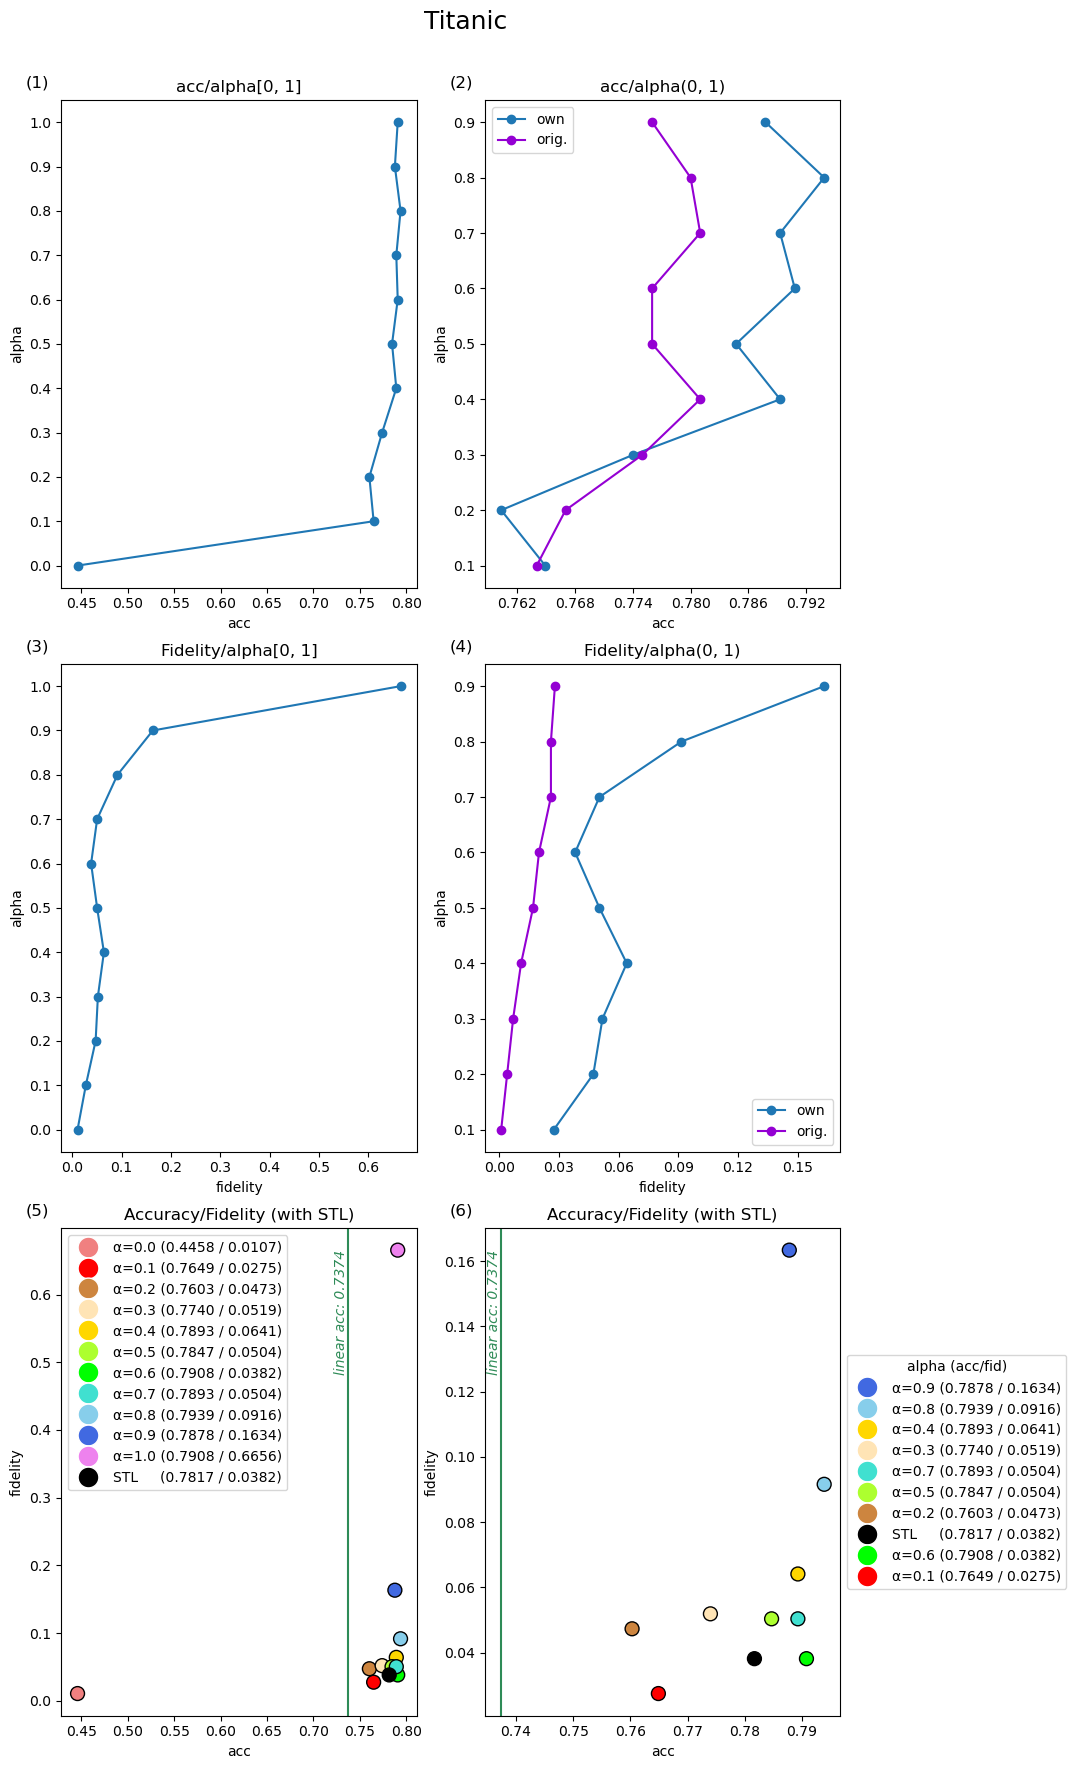

In [312]:
titanic_org_results_met = [0.764, 0.767, 0.775, 0.781, 0.776, 0.776, 0.781, 0.780, 0.776]
titanic_org_results_gf = [0.001, 0.004, 0.007, 0.011, 0.017, 0.020, 0.026, 0.026, 0.028]

draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=titanic_cfg,
    org_met=titanic_org_results_met,
    org_fid=titanic_org_results_gf,
    title='Titanic    '
)

### Local Explainability Evaluation

Creating Explainer

In [313]:
titanic_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=titanic_X_train_np,
    mode='classification',
    feature_names=titanic_cfg.features.names,
    verbose=False,
    class_names=['not survived', 'survived'],
    categorical_features=titanic_cfg.features.categorical_indices,
    categorical_names=titanic_cfg.features.values_names,
    discretize_continuous=False
)
titanic_explainer

Global Neighborhood Fidelity for STL MLP

In [314]:
# load model
mlp = MLP_cls(input_size=titanic_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(titanic_cfg.best_parameters, titanic_cfg)).to(titanic_cfg.device)
mlp.load_state_dict(torch.load(titanic_cfg.models.mlp_opt + '0' + titanic_cfg.models.ext))

# prediction function
titanic_predict_lime = partial(predict_cls_for_lime, model=mlp, config=titanic_cfg)

# neighbors dataset
print(titanic_X_test_np.shape)


titanic_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    config=titanic_cfg,
    predict_func_lime=titanic_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=titanic_cfg.num
)
titanic_cfg.results.stl_gnf

(131, 7)


[tensor(0.0504),
 tensor(0.0504),
 tensor(0.0504),
 tensor(0.0489),
 tensor(0.0519)]

Global Neighborhood Fidelity for MTL

In [315]:
gnf_for_mtl_cls_for_alpha_list(
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    model_params=titanic_cfg.best_parameters,
    config=titanic_cfg
)

Model: Titanic/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0160)]
Model: Titanic/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0389)]
Model: Titanic/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0733)]
Model: Titanic/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0397)]
Model: Titanic/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0802)]
Model: Titanic/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0786)]
Model: Titanic/mtl_alpha_0.6_0.pt, GNF: [tensor(0.0649)]
Model: Titanic/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0702)]
Model: Titanic/mtl_alpha_0.8_0.pt, GNF: [tensor(0.0656)]
Model: Titanic/mtl_alpha_0.9_0.pt, GNF: [tensor(0.0588)]
Model: Titanic/mtl_alpha_1.0_0.pt, GNF: [tensor(0.0473)]
Model: Titanic/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0153)]
Model: Titanic/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0420)]
Model: Titanic/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0725)]
Model: Titanic/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0397)]
Model: Titanic/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0786)]
Model: Titanic/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0817)]
Model: Titanic/mtl_alpha_0.6_0.

In [317]:
show_tables_lime(titanic_cfg) 

# Training and Testing Models for Additional Datasets

For additional datasets I will apply a workflow analogical to that used for the datasets from the original study.

## Concrete Dataset

### Preparation

#### Configuration Settings

In [520]:
concrete_cfg = Config(
    folders=Folders(base="Concrete/"),
    files=Files(
        data="concrete_data.pkl", 
        targets="concrete_targets.pkl", 
        study='Concrete.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 40),
)

#### Data Loading and Standardization

In [521]:
# Data Loading
concrete_df = pd.read_pickle(concrete_cfg.paths.data)

concrete_cfg.features.numerical = concrete_df.select_dtypes(include='number').columns.values.tolist()
concrete_cfg.features.numerical_indices = [concrete_df.columns.get_loc(feature) for feature in concrete_cfg.features.numerical]
concrete_cfg.features.categorical = concrete_df.select_dtypes(include='object').columns.values.tolist()
concrete_cfg.features.categorical_indices = [concrete_df.columns.get_loc(feature) for feature in concrete_cfg.features.categorical]
concrete_cfg.features.names = concrete_df.columns.values.tolist()

# Creating Dictionary 
concrete_cfg.features.values_names = {}
for feature, idx in zip(concrete_cfg.features.categorical, concrete_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(concrete_df[feature])
    concrete_df[feature] = le.transform(concrete_df[feature])
    concrete_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
concrete_X_train, concrete_X_test, concrete_y_train, concrete_y_test = train_test_split(
    concrete_df,
    np.array(pd.read_pickle(concrete_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

concrete_X_eval, concrete_X_test, concrete_y_eval, concrete_y_test = train_test_split(
    concrete_X_test, 
    concrete_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
concrete_scaler = StandardScaler()
concrete_X_train[concrete_cfg.features.numerical] = concrete_scaler.fit_transform(concrete_X_train[concrete_cfg.features.numerical]).astype(float)
concrete_X_train[concrete_cfg.features.categorical] = concrete_X_train[concrete_cfg.features.categorical].astype(float)

concrete_X_eval[concrete_cfg.features.numerical] = concrete_scaler.transform(concrete_X_eval[concrete_cfg.features.numerical]).astype(float)
concrete_X_eval[concrete_cfg.features.categorical] = concrete_X_eval[concrete_cfg.features.categorical].astype(float)

concrete_X_test[concrete_cfg.features.numerical] = concrete_scaler.transform(concrete_X_test[concrete_cfg.features.numerical]).astype(float)
concrete_X_test[concrete_cfg.features.categorical] = concrete_X_test[concrete_cfg.features.categorical].astype(float)

concrete_scaler_y = StandardScaler()
concrete_y_train = concrete_scaler_y.fit_transform(concrete_y_train)
concrete_y_eval = concrete_scaler_y.transform(concrete_y_eval)
concrete_y_test = concrete_scaler_y.transform(concrete_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
concrete_cfg.features.dummy = pd.get_dummies(concrete_df.astype(float), columns=concrete_cfg.features.categorical, dtype=float).columns 

concrete_X_train_encoded = pd.get_dummies(concrete_X_train, columns=concrete_cfg.features.categorical, dtype=float)
concrete_X_train_encoded = concrete_X_train_encoded.reindex(columns=concrete_cfg.features.dummy, fill_value=0.0).values

concrete_X_eval_encoded = pd.get_dummies(concrete_X_eval, columns=concrete_cfg.features.categorical, dtype=float)
concrete_X_eval_encoded = concrete_X_eval_encoded.reindex(columns=concrete_cfg.features.dummy, fill_value=0.0).values

concrete_X_test_encoded = pd.get_dummies(concrete_X_test, columns=concrete_cfg.features.categorical, dtype=float)
concrete_X_test_encoded = concrete_X_test_encoded.reindex(columns=concrete_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
concrete_X_train_tensor = torch.tensor(concrete_X_train_encoded, dtype=torch.float32)
concrete_X_eval_tensor = torch.tensor(concrete_X_eval_encoded, dtype=torch.float32)
concrete_X_test_tensor = torch.tensor(concrete_X_test_encoded, dtype=torch.float32)

concrete_y_train_tensor = torch.tensor(concrete_y_train, dtype=torch.float32)
concrete_y_eval_tensor = torch.tensor(concrete_y_eval, dtype=torch.float32)
concrete_y_test_tensor = torch.tensor(concrete_y_test, dtype=torch.float32)

concrete_X_train_np = concrete_X_train.values
concrete_X_eval_np = concrete_X_eval.values
concrete_X_test_np = concrete_X_test.values

# Updating Configuration 
concrete_cfg.input_size = concrete_X_train_tensor.shape[1]
concrete_cfg.tuning.min_neurons = concrete_cfg.input_size // 4 - 1
concrete_cfg.tuning.max_neurons = concrete_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [522]:
def train_and_optimize_concrete(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=concrete_X_train_tensor,
        target_train=concrete_y_train_tensor,
        data_eval=concrete_X_eval_tensor,
        target_eval=concrete_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [523]:
def study_concrete(config: Config):
    objective = partial(train_and_optimize_concrete, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

concrete_study = try_load_study(study_concrete, concrete_cfg)

[I 2024-09-03 01:53:47,789] A new study created in memory with name: Concrete.plt


  0%|          | 0/40 [00:00<?, ?it/s]

Trial: <optuna.trial._trial.Trial object at 0x000001EBF4B52840>
Epoch: 0, result (MSELoss): 0.9802136421203613
Epoch: 5, result (MSELoss): 0.6839168071746826
Epoch: 10, result (MSELoss): 0.2994062602519989
Epoch: 15, result (MSELoss): 0.23745866119861603
Epoch: 20, result (MSELoss): 0.21001915633678436
Epoch: 25, result (MSELoss): 0.18256492912769318
Epoch: 30, result (MSELoss): 0.15629364550113678
Epoch: 35, result (MSELoss): 0.1407143473625183
Epoch: 40, result (MSELoss): 0.12895973026752472
Epoch: 45, result (MSELoss): 0.11932529509067535
Epoch: 50, result (MSELoss): 0.11277971416711807
Epoch: 55, result (MSELoss): 0.10909213870763779
Epoch: 60, result (MSELoss): 0.10755183547735214
Epoch: 65, result (MSELoss): 0.10837265104055405
Epoch: 70, result (MSELoss): 0.1106971800327301
Epoch: 75, result (MSELoss): 0.11053688824176788
Epoch: 80, result (MSELoss): 0.11230368912220001
Early stopping on epoch: 84, best results from epoch: 60 result (MSELoss): 0.10755183547735214
[I 2024-09-03 0

In [524]:
concrete_study_sorted = concrete_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
concrete_study_sorted.head(5)

number     value               duration  params_num_layers  \
18      18  0.081328 0 days 00:00:10.208120                  3   
8        8  0.082196 0 days 00:00:24.441813                  3   
34      34  0.083319 0 days 00:00:17.680904                  4   
24      24  0.091690 0 days 00:00:06.486573                  4   
28      28  0.094160 0 days 00:00:06.306478                  3   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
18                   26                 17.0                 22.0   
8                    17                 16.0                  2.0   
34                   15                 16.0                  4.0   
24                   17                 14.0                 16.0   
28                   18                 19.0                  6.0   

    params_num_neurons3  params_num_neurons4     state  
18                  NaN                  NaN  COMPLETE  
8                   NaN                  NaN  COMPLETE  
34                 23.0                  NaN  COMPLETE  
24                 18.0                  NaN  COMPLETE  
28                  NaN                  NaN  COMPLETE

In [525]:
concrete_cfg.best_parameters = concrete_study.trials[concrete_study_sorted.iloc[0].number].params
concrete_cfg.best_parameters

{'num_layers': 3, 'num_neurons0': 26, 'num_neurons1': 17, 'num_neurons2': 22}

### Training and Testing MLP

In [526]:
train_and_test_mlp_reg(
    X_train=concrete_X_train_tensor, 
    y_train=concrete_y_train_tensor,
    X_eval=concrete_X_eval_tensor, 
    y_eval=concrete_y_eval_tensor, 
    X_test=concrete_X_test_tensor, 
    y_test=concrete_y_test_tensor, 
    config=concrete_cfg
)
print(np.mean(list(concrete_cfg.results.stl_mlp.values())))
concrete_cfg.results.stl_mlp

Model Concrete/mlp_opt_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 0.8921419978141785
Epoch: 5, result (MSELoss): 0.350996732711792
Epoch: 10, result (MSELoss): 0.25529077649116516
Epoch: 15, result (MSELoss): 0.18612049520015717
Epoch: 20, result (MSELoss): 0.14763478934764862
Epoch: 25, result (MSELoss): 0.12735696136951447
Epoch: 30, result (MSELoss): 0.12318307906389236
Epoch: 35, result (MSELoss): 0.1152159720659256
Epoch: 40, result (MSELoss): 0.1103861927986145
Epoch: 45, result (MSELoss): 0.1061958372592926
Epoch: 50, result (MSELoss): 0.10582862794399261
Epoch: 55, result (MSELoss): 0.10534738749265671
Epoch: 60, result (MSELoss): 0.10247393697500229
Epoch: 65, result (MSELoss): 0.10539114475250244
Epoch: 70, result (MSELoss): 0.10365477204322815
Epoch: 75, result (MSELoss): 0.10396941006183624
Epoch: 80, result (MSELoss): 0.10484445840120316
Early stopping on epoch: 84, best results from epoch: 60 result (MSELoss): 0.10247393697500229
Model Conc

{0: 0.12632493674755096,
 1: 0.12233775109052658,
 2: 0.1011430025100708,
 3: 0.10459177196025848,
 4: 0.14891941845417023}

### Training and Testing Linear Model

In [527]:
train_and_test_lin_reg(
    X_train=concrete_X_train_tensor, 
    y_train=concrete_y_train_tensor,
    X_eval=concrete_X_eval_tensor, 
    y_eval=concrete_y_eval_tensor, 
    X_test=concrete_X_test_tensor, 
    y_test=concrete_y_test_tensor, 
    config=concrete_cfg
)
print(np.mean(list(concrete_cfg.results.reg.values())))
concrete_cfg.results.reg

Model Concrete/reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 1.7066541910171509
Epoch: 5, result (MSELoss): 1.3604180812835693
Epoch: 10, result (MSELoss): 1.0884671211242676
Epoch: 15, result (MSELoss): 0.8820048570632935
Epoch: 20, result (MSELoss): 0.7262035012245178
Epoch: 25, result (MSELoss): 0.6102315187454224
Epoch: 30, result (MSELoss): 0.5265355706214905
Epoch: 35, result (MSELoss): 0.46704429388046265
Epoch: 40, result (MSELoss): 0.4249798357486725
Epoch: 45, result (MSELoss): 0.39634889364242554
Epoch: 50, result (MSELoss): 0.3764845132827759
Epoch: 55, result (MSELoss): 0.3638290762901306
Epoch: 60, result (MSELoss): 0.3559167683124542
Epoch: 65, result (MSELoss): 0.3494551181793213
Epoch: 70, result (MSELoss): 0.3451063334941864
Epoch: 75, result (MSELoss): 0.34396713972091675
Epoch: 80, result (MSELoss): 0.3412656784057617
Epoch: 85, result (MSELoss): 0.3397854268550873
Epoch: 90, result (MSELoss): 0.33902859687805176
Epoch: 95, result (M

{0: 0.36040347814559937,
 1: 0.36279430985450745,
 2: 0.38332462310791016,
 3: 0.3811423182487488,
 4: 0.36049705743789673}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [528]:
train_and_test_stl_lin_reg(
    X_train=concrete_X_train_tensor, 
    X_eval=concrete_X_eval_tensor, 
    X_test=concrete_X_test_tensor, 
    config=concrete_cfg
)
print(np.mean(list(concrete_cfg.results.stl_reg.values())))
concrete_cfg.results.stl_reg

Model Concrete/stl_reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 0.905865490436554
Epoch: 5, result (GlobalFidelity): 0.7237300276756287
Epoch: 10, result (GlobalFidelity): 0.5945740938186646
Epoch: 15, result (GlobalFidelity): 0.501300573348999
Epoch: 20, result (GlobalFidelity): 0.43458664417266846
Epoch: 25, result (GlobalFidelity): 0.3866496682167053
Epoch: 30, result (GlobalFidelity): 0.35351672768592834
Epoch: 35, result (GlobalFidelity): 0.32939308881759644
Epoch: 40, result (GlobalFidelity): 0.3146139085292816
Epoch: 45, result (GlobalFidelity): 0.3029085099697113
Epoch: 50, result (GlobalFidelity): 0.2953658699989319
Epoch: 55, result (GlobalFidelity): 0.29056668281555176
Epoch: 60, result (GlobalFidelity): 0.2861748933792114
Epoch: 65, result (GlobalFidelity): 0.2848479151725769
Epoch: 70, result (GlobalFidelity): 0.28218787908554077
Epoch: 75, result (GlobalFidelity): 0.28173476457595825
Epoch: 80, result (GlobalFidelity): 0.2808034121

{0: 0.25698015093803406,
 1: 0.2797200381755829,
 2: 0.33294862508773804,
 3: 0.3005014955997467,
 4: 0.25085702538490295}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [529]:
train_and_test_mtl_reg_n_times(
    data_train=concrete_X_train_tensor,
    target_train=concrete_y_train_tensor,
    data_eval=concrete_X_eval_tensor, 
    target_eval=concrete_y_eval_tensor, 
    data_test=concrete_X_test_tensor, 
    target_test=concrete_y_test_tensor, 
    config=concrete_cfg
)
concrete_cfg.results.mtl

Model for alpha: 0.0
Model Concrete/mtl_alpha_0.0_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 0.8853068947792053, fid: 0.3948412835597992
Epoch: 5, mse: 0.9969448447227478, fid: 0.08775540441274643
Epoch: 10, mse: 0.8720861077308655, fid: 0.006150459870696068
Epoch: 15, mse: 0.8552954196929932, fid: 0.0024217853788286448
Epoch: 20, mse: 0.8509657382965088, fid: 0.0016756794648244977
Epoch: 25, mse: 0.844802737236023, fid: 0.0012657524785026908
Epoch: 30, mse: 0.8470410704612732, fid: 0.0010060705244541168
Epoch: 35, mse: 0.8447247743606567, fid: 0.0008363751112483442
Epoch: 40, mse: 0.8419902324676514, fid: 0.0007651031482964754
Epoch: 45, mse: 0.843913733959198, fid: 0.0006346863228827715
Epoch: 50, mse: 0.8431021571159363, fid: 0.000578502775169909
Epoch: 55, mse: 0.8453656435012817, fid: 0.0005126695614308119
Epoch: 60, mse: 0.8390920162200928, fid: 0.0005490012699738145
Epoch: 65, mse: 0.8449422717094421, fid: 0.0004377134027890861
Epoch: 70, mse: 0.84328347444534

{0: {'0.0': Result(metrics=0.9710423946380615, fid=0.00010346382623538375),
  '0.1': Result(metrics=0.36007240414619446, fid=0.000834769569337368),
  '0.2': Result(metrics=0.337934285402298, fid=0.0031573616433888674),
  '0.3': Result(metrics=0.30128732323646545, fid=0.007100783754140139),
  '0.4': Result(metrics=0.2698676586151123, fid=0.014586294069886208),
  '0.5': Result(metrics=0.2546597719192505, fid=0.024913383647799492),
  '0.6': Result(metrics=0.18703079223632812, fid=0.055803559720516205),
  '0.7': Result(metrics=0.1738511323928833, fid=0.08702082931995392),
  '0.8': Result(metrics=0.1479528546333313, fid=0.13286516070365906),
  '0.9': Result(metrics=0.11910755187273026, fid=0.2022962123155594),
  '1.0': Result(metrics=0.15684469044208527, fid=1.2744768857955933)},
 1: {'0.0': Result(metrics=1.2508965730667114, fid=5.073343709227629e-05),
  '0.1': Result(metrics=0.39696672558784485, fid=0.0007039565243758261),
  '0.2': Result(metrics=0.3300808072090149, fid=0.0023769605904817

### Comparison of STL with MTL

In [530]:
concrete_cfg.metrics_label='MSE'
show_tables(concrete_cfg) 

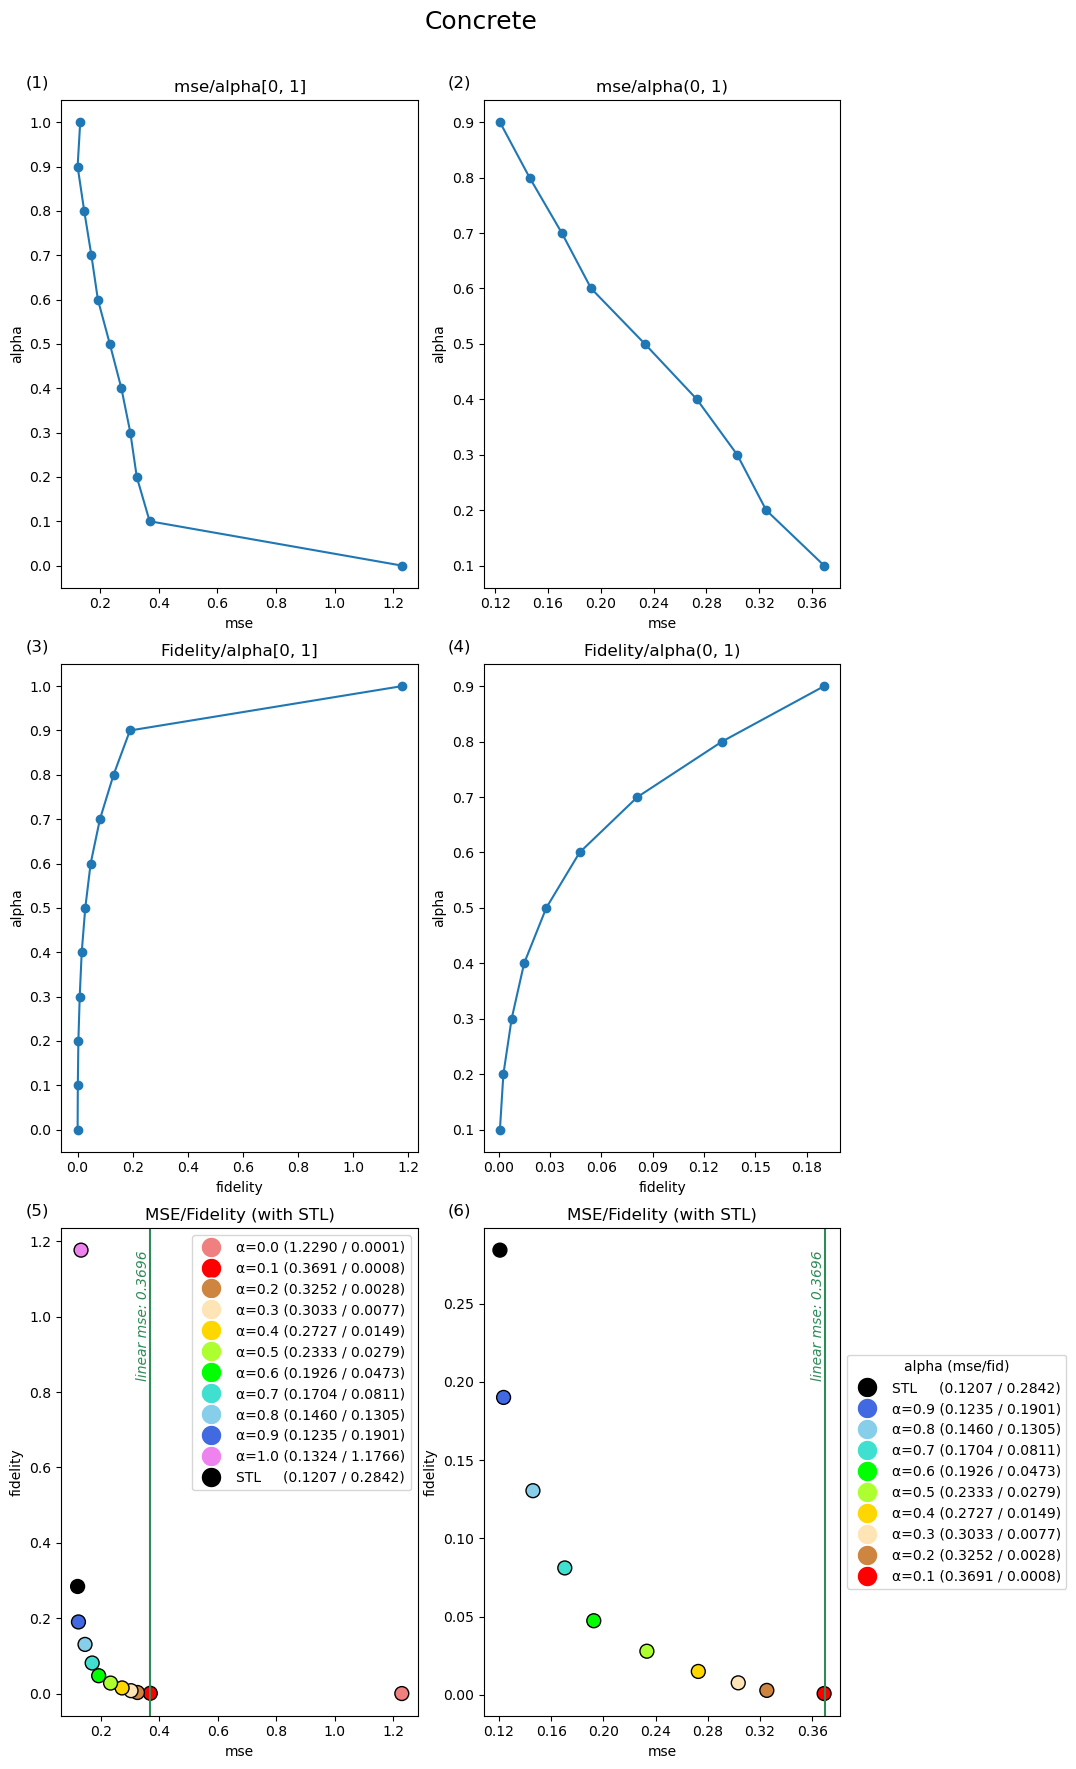

In [531]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=concrete_cfg,
    title='Concrete'
)

### Local Explainability Evaluation

Creating Explainer

In [532]:
concrete_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=concrete_X_train_np,
    mode='regression',
    feature_names=concrete_cfg.features.names,
    verbose=False,
    class_names=['CCS'],
    categorical_features=concrete_cfg.features.categorical_indices,
    categorical_names=concrete_cfg.features.values_names,
    discretize_continuous = False
)
concrete_explainer

Global Neighborhood Fidelity for STL MLP

In [533]:
# load model
mlp = MLP_reg(input_size=concrete_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(concrete_cfg.best_parameters, concrete_cfg)).to(concrete_cfg.device)
mlp.load_state_dict(torch.load(concrete_cfg.models.mlp_opt + '0' + concrete_cfg.models.ext))

# prediction function
concrete_predict_lime = partial(predict_reg_for_lime, model=mlp, config=concrete_cfg)

# neighbors dataset
print(concrete_X_test_np.shape)


concrete_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=concrete_X_test_np,
    explainer=concrete_explainer,
    config=concrete_cfg,
    predict_func_lime=concrete_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=concrete_cfg.num
)
concrete_cfg.results.stl_gnf

(103, 8)


[tensor(1.1575, dtype=torch.float64),
 tensor(1.1775, dtype=torch.float64),
 tensor(1.1357, dtype=torch.float64),
 tensor(1.1928, dtype=torch.float64),
 tensor(1.1479, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [536]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=concrete_X_test_np,
    explainer=concrete_explainer,
    model_params=concrete_cfg.best_parameters,
    config=concrete_cfg,
    n=concrete_cfg.num
)

concrete_cfg.results.mtl_gnf

Model: Concrete/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0443, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1173, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.2_0.pt, GNF: [tensor(0.1193, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.3_0.pt, GNF: [tensor(0.1453, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.4_0.pt, GNF: [tensor(0.2008, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.5_0.pt, GNF: [tensor(0.2075, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.6_0.pt, GNF: [tensor(0.3357, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.7_0.pt, GNF: [tensor(0.4373, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.8_0.pt, GNF: [tensor(0.4963, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.9_0.pt, GNF: [tensor(0.7854, dtype=torch.float64)]
Model: Concrete/mtl_alpha_1.0_0.pt, GNF: [tensor(0.7838, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0458, dtype=torch.float64)]
Model: Concrete/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1

{0: {'0.0': [tensor(0.0443, dtype=torch.float64)],
  '0.1': [tensor(0.1173, dtype=torch.float64)],
  '0.2': [tensor(0.1193, dtype=torch.float64)],
  '0.3': [tensor(0.1453, dtype=torch.float64)],
  '0.4': [tensor(0.2008, dtype=torch.float64)],
  '0.5': [tensor(0.2075, dtype=torch.float64)],
  '0.6': [tensor(0.3357, dtype=torch.float64)],
  '0.7': [tensor(0.4373, dtype=torch.float64)],
  '0.8': [tensor(0.4963, dtype=torch.float64)],
  '0.9': [tensor(0.7854, dtype=torch.float64)],
  '1.0': [tensor(0.7838, dtype=torch.float64)]},
 1: {'0.0': [tensor(0.0458, dtype=torch.float64)],
  '0.1': [tensor(0.1194, dtype=torch.float64)],
  '0.2': [tensor(0.1204, dtype=torch.float64)],
  '0.3': [tensor(0.1386, dtype=torch.float64)],
  '0.4': [tensor(0.1830, dtype=torch.float64)],
  '0.5': [tensor(0.1990, dtype=torch.float64)],
  '0.6': [tensor(0.3370, dtype=torch.float64)],
  '0.7': [tensor(0.4503, dtype=torch.float64)],
  '0.8': [tensor(0.5480, dtype=torch.float64)],
  '0.9': [tensor(0.7546, dtype=to

In [537]:
show_tables_lime(concrete_cfg) 

## Yacht Hydrodynamics

### Preparation

#### Configuration Settings

In [538]:
yacht_cfg = Config(
    folders=Folders(base="Yacht/"),
    files=Files(
        data="yacht_data.pkl", 
        targets="yacht_targets.pkl", 
        study='Yacht.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 40),
)

#### Data Loading and Standardization

In [539]:
# Data Loading
yacht_df = pd.read_pickle(yacht_cfg.paths.data)

yacht_cfg.features.numerical = yacht_df.select_dtypes(include='number').columns.values.tolist()
yacht_cfg.features.numerical_indices = [yacht_df.columns.get_loc(feature) for feature in yacht_cfg.features.numerical]
yacht_cfg.features.categorical = yacht_df.select_dtypes(include='object').columns.values.tolist()
yacht_cfg.features.categorical_indices = [yacht_df.columns.get_loc(feature) for feature in yacht_cfg.features.categorical]
yacht_cfg.features.names = yacht_df.columns.values.tolist()

# Creating Dictionary 
yacht_cfg.features.values_names = {}
for feature, idx in zip(yacht_cfg.features.categorical, yacht_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(yacht_df[feature])
    yacht_df[feature] = le.transform(yacht_df[feature])
    yacht_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
yacht_X_train, yacht_X_test, yacht_y_train, yacht_y_test = train_test_split(
    yacht_df,
    np.array(pd.read_pickle(yacht_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

yacht_X_eval, yacht_X_test, yacht_y_eval, yacht_y_test = train_test_split(
    yacht_X_test, 
    yacht_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
yacht_scaler = StandardScaler()
yacht_X_train[yacht_cfg.features.numerical] = yacht_scaler.fit_transform(yacht_X_train[yacht_cfg.features.numerical]).astype(float)
yacht_X_train[yacht_cfg.features.categorical] = yacht_X_train[yacht_cfg.features.categorical].astype(float)

yacht_X_eval[yacht_cfg.features.numerical] = yacht_scaler.transform(yacht_X_eval[yacht_cfg.features.numerical]).astype(float)
yacht_X_eval[yacht_cfg.features.categorical] = yacht_X_eval[yacht_cfg.features.categorical].astype(float)

yacht_X_test[yacht_cfg.features.numerical] = yacht_scaler.transform(yacht_X_test[yacht_cfg.features.numerical]).astype(float)
yacht_X_test[yacht_cfg.features.categorical] = yacht_X_test[yacht_cfg.features.categorical].astype(float)

yacht_scaler_y = StandardScaler()
yacht_y_train = yacht_scaler_y.fit_transform(yacht_y_train)
yacht_y_eval = yacht_scaler_y.transform(yacht_y_eval)
yacht_y_test = yacht_scaler_y.transform(yacht_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
yacht_cfg.features.dummy = pd.get_dummies(yacht_df.astype(float), columns=yacht_cfg.features.categorical, dtype=float).columns 

yacht_X_train_encoded = pd.get_dummies(yacht_X_train, columns=yacht_cfg.features.categorical, dtype=float)
yacht_X_train_encoded = yacht_X_train_encoded.reindex(columns=yacht_cfg.features.dummy, fill_value=0.0).values

yacht_X_eval_encoded = pd.get_dummies(yacht_X_eval, columns=yacht_cfg.features.categorical, dtype=float)
yacht_X_eval_encoded = yacht_X_eval_encoded.reindex(columns=yacht_cfg.features.dummy, fill_value=0.0).values

yacht_X_test_encoded = pd.get_dummies(yacht_X_test, columns=yacht_cfg.features.categorical, dtype=float)
yacht_X_test_encoded = yacht_X_test_encoded.reindex(columns=yacht_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
yacht_X_train_tensor = torch.tensor(yacht_X_train_encoded, dtype=torch.float32)
yacht_X_eval_tensor = torch.tensor(yacht_X_eval_encoded, dtype=torch.float32)
yacht_X_test_tensor = torch.tensor(yacht_X_test_encoded, dtype=torch.float32)

yacht_y_train_tensor = torch.tensor(yacht_y_train, dtype=torch.float32)
yacht_y_eval_tensor = torch.tensor(yacht_y_eval, dtype=torch.float32)
yacht_y_test_tensor = torch.tensor(yacht_y_test, dtype=torch.float32)

yacht_X_train_np = yacht_X_train.values
yacht_X_eval_np = yacht_X_eval.values
yacht_X_test_np = yacht_X_test.values

# Updating Configuration 
yacht_cfg.input_size = yacht_X_train_tensor.shape[1]
yacht_cfg.tuning.min_neurons = yacht_cfg.input_size // 4 - 1
yacht_cfg.tuning.max_neurons = yacht_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [540]:
def train_and_optimize_yacht(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=yacht_X_train_tensor,
        target_train=yacht_y_train_tensor,
        data_eval=yacht_X_eval_tensor,
        target_eval=yacht_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [541]:
def study_yacht(config: Config):
    objective = partial(train_and_optimize_yacht, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

yacht_study = try_load_study(study_yacht, yacht_cfg)

[I 2024-09-03 02:25:39,166] A new study created in memory with name: Yacht.plt


  0%|          | 0/40 [00:00<?, ?it/s]

Trial: <optuna.trial._trial.Trial object at 0x000001EBF77094F0>
Epoch: 0, result (MSELoss): 0.5519891977310181
Epoch: 5, result (MSELoss): 0.5311658382415771
Epoch: 10, result (MSELoss): 0.512127697467804
Epoch: 15, result (MSELoss): 0.4944460988044739
Epoch: 20, result (MSELoss): 0.4773079454898834
Epoch: 25, result (MSELoss): 0.4590721130371094
Epoch: 30, result (MSELoss): 0.4402323067188263
Epoch: 35, result (MSELoss): 0.4208066165447235
Epoch: 40, result (MSELoss): 0.40017348527908325
Epoch: 45, result (MSELoss): 0.37786993384361267
Epoch: 50, result (MSELoss): 0.3552718460559845
Epoch: 55, result (MSELoss): 0.3329320251941681
Epoch: 60, result (MSELoss): 0.31097787618637085
Epoch: 65, result (MSELoss): 0.2894027829170227
Epoch: 70, result (MSELoss): 0.26858165860176086
Epoch: 75, result (MSELoss): 0.24903444945812225
Epoch: 80, result (MSELoss): 0.2307104617357254
Epoch: 85, result (MSELoss): 0.21338218450546265
Epoch: 90, result (MSELoss): 0.19777442514896393
Epoch: 95, result (M

C:\Users\adria\anaconda3\envs\master_env\Lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 0, result (MSELoss): 0.610759973526001
Epoch: 5, result (MSELoss): 0.568992018699646
Epoch: 10, result (MSELoss): 0.5450792908668518
Epoch: 15, result (MSELoss): 0.5375984907150269
Epoch: 20, result (MSELoss): 0.5370376110076904
Epoch: 25, result (MSELoss): 0.5370227098464966
Epoch: 30, result (MSELoss): 0.5374740362167358
Epoch: 35, result (MSELoss): 0.5375373363494873
Epoch: 40, result (MSELoss): 0.5379636883735657
Early stopping on epoch: 43, best results from epoch: 19 result (MSELoss): 0.5367332696914673
[I 2024-09-03 02:26:00,151] Trial 2 finished with value: 0.5367332696914673 and parameters: {'num_layers': 4, 'num_neurons0': 0, 'num_neurons1': 5, 'num_neurons2': 15, 'num_neurons3': 16}. Best is trial 1 with value: 0.010461807250976562.
Trial: <optuna.trial._trial.Trial object at 0x000001EBF770B4D0>
Epoch: 0, result (MSELoss): 0.5741758942604065
Epoch: 5, result (MSELoss): 0.530753493309021
Epoch: 10, result (MSELoss): 0.4790276288986206
Epoch: 15, result (MSELoss): 0.349

In [542]:
yacht_study_sorted = yacht_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
yacht_study_sorted.head(5)

number     value               duration  params_num_layers  \
36      36  0.002376 0 days 00:00:08.010541                  4   
31      31  0.002787 0 days 00:00:07.618398                  4   
14      14  0.002956 0 days 00:00:09.276168                  3   
9        9  0.003050 0 days 00:00:11.387996                  4   
38      38  0.003057 0 days 00:00:05.002484                  4   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
36                   11                  4.0                  5.0   
31                    9                 11.0                  4.0   
14                   18                 15.0                  8.0   
9                    22                 23.0                  3.0   
38                   12                 19.0                  6.0   

    params_num_neurons3  params_num_neurons4     state  
36                 15.0                  NaN  COMPLETE  
31                  8.0                  NaN  COMPLETE  
14                  NaN                  NaN  COMPLETE  
9                  16.0                  NaN  COMPLETE  
38                 15.0                  NaN  COMPLETE

In [543]:
yacht_cfg.best_parameters = yacht_study.trials[yacht_study_sorted.iloc[0].number].params
yacht_cfg.best_parameters

{'num_layers': 4,
 'num_neurons0': 11,
 'num_neurons1': 4,
 'num_neurons2': 5,
 'num_neurons3': 15}

### Training and Testing MLP

In [544]:
train_and_test_mlp_reg(
    X_train=yacht_X_train_tensor, 
    y_train=yacht_y_train_tensor,
    X_eval=yacht_X_eval_tensor, 
    y_eval=yacht_y_eval_tensor, 
    X_test=yacht_X_test_tensor, 
    y_test=yacht_y_test_tensor, 
    config=yacht_cfg
)
print(np.mean(list(yacht_cfg.results.stl_mlp.values())))
yacht_cfg.results.stl_mlp

Model Yacht/mlp_opt_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 0.8764316439628601
Epoch: 5, result (MSELoss): 0.8064119815826416
Epoch: 10, result (MSELoss): 0.7583792805671692
Epoch: 15, result (MSELoss): 0.7193909883499146
Epoch: 20, result (MSELoss): 0.6866956949234009
Epoch: 25, result (MSELoss): 0.6585137248039246
Epoch: 30, result (MSELoss): 0.6343493461608887
Epoch: 35, result (MSELoss): 0.6102871894836426
Epoch: 40, result (MSELoss): 0.5697759985923767
Epoch: 45, result (MSELoss): 0.4917202591896057
Epoch: 50, result (MSELoss): 0.37180742621421814
Epoch: 55, result (MSELoss): 0.26998162269592285
Epoch: 60, result (MSELoss): 0.17999204993247986
Epoch: 65, result (MSELoss): 0.11536270380020142
Epoch: 70, result (MSELoss): 0.07098344713449478
Epoch: 75, result (MSELoss): 0.04309649392962456
Epoch: 80, result (MSELoss): 0.02585659548640251
Epoch: 85, result (MSELoss): 0.021995343267917633
Epoch: 90, result (MSELoss): 0.02188749797642231
Epoch: 95, re

{0: 0.0017991414060816169,
 1: 0.0022005902137607336,
 2: 0.0028754975646734238,
 3: 0.0014838222414255142,
 4: 0.0033511812798678875}

### Training and Testing Linear Model

In [545]:
train_and_test_lin_reg(
    X_train=yacht_X_train_tensor, 
    y_train=yacht_y_train_tensor,
    X_eval=yacht_X_eval_tensor, 
    y_eval=yacht_y_eval_tensor, 
    X_test=yacht_X_test_tensor, 
    y_test=yacht_y_test_tensor, 
    config=yacht_cfg
)
print(np.mean(list(yacht_cfg.results.reg.values())))
yacht_cfg.results.reg

Model Yacht/reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 0.6484533548355103
Epoch: 5, result (MSELoss): 0.5999545454978943
Epoch: 10, result (MSELoss): 0.5555497407913208
Epoch: 15, result (MSELoss): 0.5153825879096985
Epoch: 20, result (MSELoss): 0.47937729954719543
Epoch: 25, result (MSELoss): 0.4465802013874054
Epoch: 30, result (MSELoss): 0.41786229610443115
Epoch: 35, result (MSELoss): 0.3919374346733093
Epoch: 40, result (MSELoss): 0.3692018389701843
Epoch: 45, result (MSELoss): 0.3486904799938202
Epoch: 50, result (MSELoss): 0.33047452569007874
Epoch: 55, result (MSELoss): 0.31442102789878845
Epoch: 60, result (MSELoss): 0.3001335859298706
Epoch: 65, result (MSELoss): 0.28741833567619324
Epoch: 70, result (MSELoss): 0.2762163579463959
Epoch: 75, result (MSELoss): 0.26628023386001587
Epoch: 80, result (MSELoss): 0.25750115513801575
Epoch: 85, result (MSELoss): 0.24969078600406647
Epoch: 90, result (MSELoss): 0.24276041984558105
Epoch: 95, result 

{0: 0.303026020526886,
 1: 0.30132046341896057,
 2: 0.3012146055698395,
 3: 0.3028589189052582,
 4: 0.3183716833591461}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [546]:
train_and_test_stl_lin_reg(
    X_train=yacht_X_train_tensor, 
    X_eval=yacht_X_eval_tensor, 
    X_test=yacht_X_test_tensor, 
    config=yacht_cfg
)
print(np.mean(list(yacht_cfg.results.stl_reg.values())))
yacht_cfg.results.stl_reg

Model Yacht/stl_reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 0.40212273597717285
Epoch: 5, result (GlobalFidelity): 0.36542588472366333
Epoch: 10, result (GlobalFidelity): 0.33436742424964905
Epoch: 15, result (GlobalFidelity): 0.3085815906524658
Epoch: 20, result (GlobalFidelity): 0.28713616728782654
Epoch: 25, result (GlobalFidelity): 0.26972147822380066
Epoch: 30, result (GlobalFidelity): 0.2546156942844391
Epoch: 35, result (GlobalFidelity): 0.2419765442609787
Epoch: 40, result (GlobalFidelity): 0.23109155893325806
Epoch: 45, result (GlobalFidelity): 0.2215655893087387
Epoch: 50, result (GlobalFidelity): 0.21338054537773132
Epoch: 55, result (GlobalFidelity): 0.2066582590341568
Epoch: 60, result (GlobalFidelity): 0.20089885592460632
Epoch: 65, result (GlobalFidelity): 0.19604076445102692
Epoch: 70, result (GlobalFidelity): 0.1918954849243164
Epoch: 75, result (GlobalFidelity): 0.1884232461452484
Epoch: 80, result (GlobalFidelity): 0.18572878

{0: 0.30700764060020447,
 1: 0.27183330059051514,
 2: 0.2906027138233185,
 3: 0.30621591210365295,
 4: 0.2724074721336365}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [547]:
train_and_test_mtl_reg_n_times(
    data_train=yacht_X_train_tensor,
    target_train=yacht_y_train_tensor,
    data_eval=yacht_X_eval_tensor, 
    target_eval=yacht_y_eval_tensor, 
    data_test=yacht_X_test_tensor, 
    target_test=yacht_y_test_tensor, 
    config=yacht_cfg
)
yacht_cfg.results.mtl

Model for alpha: 0.0
Model Yacht/mtl_alpha_0.0_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 0.6959813833236694, fid: 0.48450055718421936
Epoch: 5, mse: 0.7921081185340881, fid: 0.3481513559818268
Epoch: 10, mse: 0.8989933729171753, fid: 0.25165241956710815
Epoch: 15, mse: 0.9907233119010925, fid: 0.18638502061367035
Epoch: 20, mse: 1.0453819036483765, fid: 0.1403873860836029
Epoch: 25, mse: 1.1045669317245483, fid: 0.09597504884004593
Epoch: 30, mse: 1.2039014101028442, fid: 0.05263541266322136
Epoch: 35, mse: 1.3223077058792114, fid: 0.024364886805415154
Epoch: 40, mse: 1.4002676010131836, fid: 0.012558253481984138
Epoch: 45, mse: 1.4386812448501587, fid: 0.007937283255159855
Epoch: 50, mse: 1.4502041339874268, fid: 0.0054199364967644215
Epoch: 55, mse: 1.4509769678115845, fid: 0.00369691732339561
Epoch: 60, mse: 1.4424023628234863, fid: 0.0027297951746731997
Epoch: 65, mse: 1.443758487701416, fid: 0.002186243422329426
Epoch: 70, mse: 1.4426746368408203, fid: 0.001827

{0: {'0.0': Result(metrics=1.581695795059204, fid=0.00024915271205827594),
  '0.1': Result(metrics=0.29002100229263306, fid=0.0015302792889997363),
  '0.2': Result(metrics=0.24608196318149567, fid=0.0031241090036928654),
  '0.3': Result(metrics=0.23063015937805176, fid=0.006463557481765747),
  '0.4': Result(metrics=0.20208090543746948, fid=0.0112559599801898),
  '0.5': Result(metrics=0.16146504878997803, fid=0.022831644862890244),
  '0.6': Result(metrics=0.10513509809970856, fid=0.05698651820421219),
  '0.7': Result(metrics=0.08006345480680466, fid=0.07196272909641266),
  '0.8': Result(metrics=0.04480535537004471, fid=0.13112539052963257),
  '0.9': Result(metrics=0.010182446800172329, fid=0.21618039906024933),
  '1.0': Result(metrics=0.00403440510854125, fid=1.1999837160110474)},
 1: {'0.0': Result(metrics=0.5216530561447144, fid=0.00013051032146904618),
  '0.1': Result(metrics=0.2598360776901245, fid=0.0015558231389150023),
  '0.2': Result(metrics=0.2907034158706665, fid=0.00412015011

### Comparison of STL with MTL

In [548]:
yacht_cfg.metrics_label='MSE'
show_tables(yacht_cfg) 

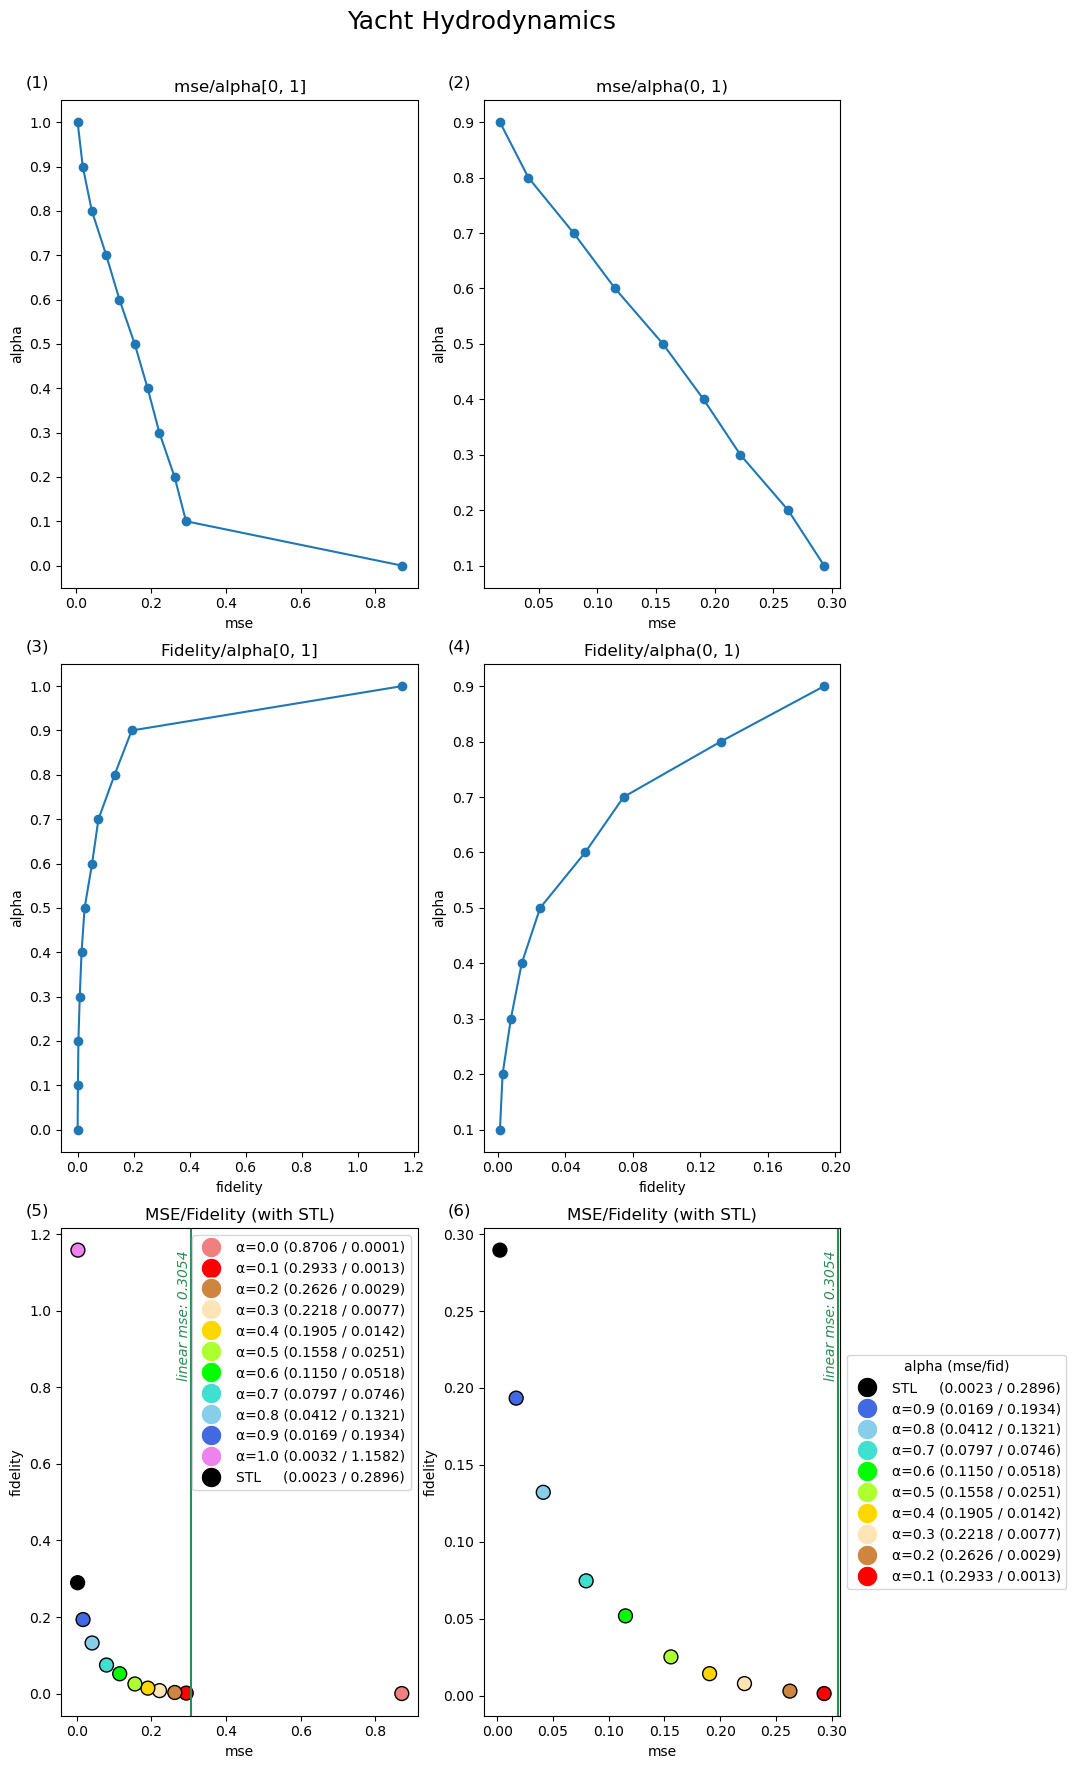

In [554]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=yacht_cfg,
    title='Yacht Hydrodynamics'
)

### Local Explainability Evaluation

Creating Explainer

In [550]:
yacht_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=yacht_X_train_np,
    mode='regression',
    feature_names=yacht_cfg.features.names,
    verbose=False,
    class_names=['Residuary Res.'],
    categorical_features=yacht_cfg.features.categorical_indices,
    categorical_names=yacht_cfg.features.values_names,
    discretize_continuous = False
)
yacht_explainer

Global Neighborhood Fidelity for STL MLP

In [551]:
# load model
mlp = MLP_reg(input_size=yacht_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(yacht_cfg.best_parameters, yacht_cfg)).to(yacht_cfg.device)
mlp.load_state_dict(torch.load(yacht_cfg.models.mlp_opt + '0' + yacht_cfg.models.ext))

# prediction function
yacht_predict_lime = partial(predict_reg_for_lime, model=mlp, config=yacht_cfg)

# neighbors dataset
print(yacht_X_test_np.shape)


yacht_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=yacht_X_test_np,
    explainer=yacht_explainer,
    config=yacht_cfg,
    predict_func_lime=yacht_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=yacht_cfg.num
)
yacht_cfg.results.stl_gnf

(31, 6)


[tensor(0.3128, dtype=torch.float64),
 tensor(0.3504, dtype=torch.float64),
 tensor(0.3275, dtype=torch.float64),
 tensor(0.3707, dtype=torch.float64),
 tensor(0.3083, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [552]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=yacht_X_test_np,
    explainer=yacht_explainer,
    model_params=yacht_cfg.best_parameters,
    config=yacht_cfg,
    n=yacht_cfg.num
)

yacht_cfg.results.mtl_gnf

Model: Yacht/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0174, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0832, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0746, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0753, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0875, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0990, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1405, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.7_0.pt, GNF: [tensor(0.1309, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1821, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.9_0.pt, GNF: [tensor(0.2652, dtype=torch.float64)]
Model: Yacht/mtl_alpha_1.0_0.pt, GNF: [tensor(0.3267, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0182, dtype=torch.float64)]
Model: Yacht/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0862, dtype=torch.float64)]
Model: Yacht

{0: {'0.0': [tensor(0.0174, dtype=torch.float64)],
  '0.1': [tensor(0.0832, dtype=torch.float64)],
  '0.2': [tensor(0.0746, dtype=torch.float64)],
  '0.3': [tensor(0.0753, dtype=torch.float64)],
  '0.4': [tensor(0.0875, dtype=torch.float64)],
  '0.5': [tensor(0.0990, dtype=torch.float64)],
  '0.6': [tensor(0.1405, dtype=torch.float64)],
  '0.7': [tensor(0.1309, dtype=torch.float64)],
  '0.8': [tensor(0.1821, dtype=torch.float64)],
  '0.9': [tensor(0.2652, dtype=torch.float64)],
  '1.0': [tensor(0.3267, dtype=torch.float64)]},
 1: {'0.0': [tensor(0.0182, dtype=torch.float64)],
  '0.1': [tensor(0.0862, dtype=torch.float64)],
  '0.2': [tensor(0.0671, dtype=torch.float64)],
  '0.3': [tensor(0.0795, dtype=torch.float64)],
  '0.4': [tensor(0.0767, dtype=torch.float64)],
  '0.5': [tensor(0.0924, dtype=torch.float64)],
  '0.6': [tensor(0.1644, dtype=torch.float64)],
  '0.7': [tensor(0.1214, dtype=torch.float64)],
  '0.8': [tensor(0.1903, dtype=torch.float64)],
  '0.9': [tensor(0.2673, dtype=to

In [553]:
show_tables_lime(yacht_cfg) 

## Energy Efficiency Dataset

### Preparation

#### Configuration Settings

In [556]:
energy_cfg = Config(
    folders=Folders(base="Energy/"),
    files=Files(
        data="energy_data.pkl", 
        targets="energy_targets.pkl", 
        study='Energy.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 40),
)

#### Data Loading and Standardization

In [557]:
# Data Loading
energy_df = pd.read_pickle(energy_cfg.paths.data)

energy_cfg.features.numerical = energy_df.select_dtypes(include='number').columns.values.tolist()
energy_cfg.features.numerical_indices = [energy_df.columns.get_loc(feature) for feature in energy_cfg.features.numerical]
energy_cfg.features.categorical = energy_df.select_dtypes(include='object').columns.values.tolist()
energy_cfg.features.categorical_indices = [energy_df.columns.get_loc(feature) for feature in energy_cfg.features.categorical]
energy_cfg.features.names = energy_df.columns.values.tolist()

# Creating Dictionary 
energy_cfg.features.values_names = {}
for feature, idx in zip(energy_cfg.features.categorical, energy_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(energy_df[feature])
    energy_df[feature] = le.transform(energy_df[feature])
    energy_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
energy_X_train, energy_X_test, energy_y_train, energy_y_test = train_test_split(
    energy_df,
    np.array(pd.read_pickle(energy_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

energy_X_eval, energy_X_test, energy_y_eval, energy_y_test = train_test_split(
    energy_X_test, 
    energy_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
energy_scaler = StandardScaler()
energy_X_train[energy_cfg.features.numerical] = energy_scaler.fit_transform(energy_X_train[energy_cfg.features.numerical]).astype(float)
energy_X_train[energy_cfg.features.categorical] = energy_X_train[energy_cfg.features.categorical].astype(float)

energy_X_eval[energy_cfg.features.numerical] = energy_scaler.transform(energy_X_eval[energy_cfg.features.numerical]).astype(float)
energy_X_eval[energy_cfg.features.categorical] = energy_X_eval[energy_cfg.features.categorical].astype(float)

energy_X_test[energy_cfg.features.numerical] = energy_scaler.transform(energy_X_test[energy_cfg.features.numerical]).astype(float)
energy_X_test[energy_cfg.features.categorical] = energy_X_test[energy_cfg.features.categorical].astype(float)

energy_scaler_y = StandardScaler()
energy_y_train = energy_scaler_y.fit_transform(energy_y_train)
energy_y_eval = energy_scaler_y.transform(energy_y_eval)
energy_y_test = energy_scaler_y.transform(energy_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
energy_cfg.features.dummy = pd.get_dummies(energy_df.astype(float), columns=energy_cfg.features.categorical, dtype=float).columns 

energy_X_train_encoded = pd.get_dummies(energy_X_train, columns=energy_cfg.features.categorical, dtype=float)
energy_X_train_encoded = energy_X_train_encoded.reindex(columns=energy_cfg.features.dummy, fill_value=0.0).values

energy_X_eval_encoded = pd.get_dummies(energy_X_eval, columns=energy_cfg.features.categorical, dtype=float)
energy_X_eval_encoded = energy_X_eval_encoded.reindex(columns=energy_cfg.features.dummy, fill_value=0.0).values

energy_X_test_encoded = pd.get_dummies(energy_X_test, columns=energy_cfg.features.categorical, dtype=float)
energy_X_test_encoded = energy_X_test_encoded.reindex(columns=energy_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
energy_X_train_tensor = torch.tensor(energy_X_train_encoded, dtype=torch.float32)
energy_X_eval_tensor = torch.tensor(energy_X_eval_encoded, dtype=torch.float32)
energy_X_test_tensor = torch.tensor(energy_X_test_encoded, dtype=torch.float32)

energy_y_train_tensor = torch.tensor(energy_y_train, dtype=torch.float32)
energy_y_eval_tensor = torch.tensor(energy_y_eval, dtype=torch.float32)
energy_y_test_tensor = torch.tensor(energy_y_test, dtype=torch.float32)

energy_X_train_np = energy_X_train.values
energy_X_eval_np = energy_X_eval.values
energy_X_test_np = energy_X_test.values

# Updating Configuration 
energy_cfg.input_size = energy_X_train_tensor.shape[1]
energy_cfg.tuning.min_neurons = energy_cfg.input_size // 4 - 1
energy_cfg.tuning.max_neurons = energy_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [558]:
def train_and_optimize_energy(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_with_early_stopping(
        data_train=energy_X_train_tensor,
        target_train=energy_y_train_tensor,
        data_eval=energy_X_eval_tensor,
        target_eval=energy_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [559]:
def study_energy(config: Config):
    objective = partial(train_and_optimize_energy, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

energy_study = try_load_study(study_energy, energy_cfg)

[I 2024-09-03 02:51:58,149] A new study created in memory with name: Energy.plt


  0%|          | 0/40 [00:00<?, ?it/s]

Trial: <optuna.trial._trial.Trial object at 0x000001EBF87E8C50>
Epoch: 0, result (MSELoss): 1.0708879232406616
Epoch: 5, result (MSELoss): 0.9765418767929077
Epoch: 10, result (MSELoss): 0.31808868050575256
Epoch: 15, result (MSELoss): 0.16374187171459198
Epoch: 20, result (MSELoss): 0.14023573696613312
Epoch: 25, result (MSELoss): 0.12928637862205505
Epoch: 30, result (MSELoss): 0.12380067259073257
Epoch: 35, result (MSELoss): 0.12082165479660034
Epoch: 40, result (MSELoss): 0.11796968430280685
Epoch: 45, result (MSELoss): 0.11246561259031296
Epoch: 50, result (MSELoss): 0.10834574699401855
Epoch: 55, result (MSELoss): 0.10361151397228241
Epoch: 60, result (MSELoss): 0.09654618054628372
Epoch: 65, result (MSELoss): 0.09244696795940399
Epoch: 70, result (MSELoss): 0.08939439803361893
Epoch: 75, result (MSELoss): 0.08701501786708832
Epoch: 80, result (MSELoss): 0.08408789336681366
Epoch: 85, result (MSELoss): 0.08156777918338776
Epoch: 90, result (MSELoss): 0.07909548282623291
Epoch: 95

In [560]:
energy_study_sorted = energy_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1)
energy_study_sorted.head(5)

number     value               duration  params_num_layers  \
32      32  0.002394 0 days 00:00:11.629488                  3   
34      34  0.002424 0 days 00:00:11.694086                  3   
20      20  0.002533 0 days 00:00:16.634102                  3   
1        1  0.002689 0 days 00:00:22.760398                  3   
39      39  0.002691 0 days 00:00:05.969439                  3   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
32                    5                 25.0                 23.0   
34                    6                 24.0                 28.0   
20                   11                 23.0                 13.0   
1                     7                 30.0                 12.0   
39                   19                 12.0                 31.0   

    params_num_neurons3  params_num_neurons4     state  
32                  NaN                  NaN  COMPLETE  
34                  NaN                  NaN  COMPLETE  
20                  NaN                  NaN  COMPLETE  
1                   NaN                  NaN  COMPLETE  
39                  NaN                  NaN  COMPLETE

In [561]:
energy_cfg.best_parameters = energy_study.trials[energy_study_sorted.iloc[0].number].params
energy_cfg.best_parameters

{'num_layers': 3, 'num_neurons0': 5, 'num_neurons1': 25, 'num_neurons2': 23}

### Training and Testing MLP

In [562]:
train_and_test_mlp_reg(
    X_train=energy_X_train_tensor, 
    y_train=energy_y_train_tensor,
    X_eval=energy_X_eval_tensor, 
    y_eval=energy_y_eval_tensor, 
    X_test=energy_X_test_tensor, 
    y_test=energy_y_test_tensor, 
    config=energy_cfg
)
print(np.mean(list(energy_cfg.results.stl_mlp.values())))
energy_cfg.results.stl_mlp

Model Energy/mlp_opt_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 1.164095163345337
Epoch: 5, result (MSELoss): 0.8392473459243774
Epoch: 10, result (MSELoss): 0.2715955376625061
Epoch: 15, result (MSELoss): 0.14251463115215302
Epoch: 20, result (MSELoss): 0.12085112184286118
Epoch: 25, result (MSELoss): 0.11338125914335251
Epoch: 30, result (MSELoss): 0.10849405080080032
Epoch: 35, result (MSELoss): 0.10431385040283203
Epoch: 40, result (MSELoss): 0.10358939319849014
Epoch: 45, result (MSELoss): 0.10234954208135605
Epoch: 50, result (MSELoss): 0.10149556398391724
Epoch: 55, result (MSELoss): 0.10059548914432526
Epoch: 60, result (MSELoss): 0.10039763152599335
Epoch: 65, result (MSELoss): 0.10019633919000626
Epoch: 70, result (MSELoss): 0.09894225746393204
Epoch: 75, result (MSELoss): 0.09828609973192215
Epoch: 80, result (MSELoss): 0.0973564013838768
Epoch: 85, result (MSELoss): 0.09643889963626862
Epoch: 90, result (MSELoss): 0.09413713216781616
Epoch: 9

{0: 0.008261820301413536,
 1: 0.002421455690637231,
 2: 0.007999872788786888,
 3: 0.0076262084767222404,
 4: 0.0024576550349593163}

### Training and Testing Linear Model

In [563]:
train_and_test_lin_reg(
    X_train=energy_X_train_tensor, 
    y_train=energy_y_train_tensor,
    X_eval=energy_X_eval_tensor, 
    y_eval=energy_y_eval_tensor, 
    X_test=energy_X_test_tensor, 
    y_test=energy_y_test_tensor, 
    config=energy_cfg
)
print(np.mean(list(energy_cfg.results.reg.values())))
energy_cfg.results.reg

Model Energy/reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (MSELoss): 1.5574250221252441
Epoch: 5, result (MSELoss): 1.1039066314697266
Epoch: 10, result (MSELoss): 0.7648786306381226
Epoch: 15, result (MSELoss): 0.5250552296638489
Epoch: 20, result (MSELoss): 0.3685830235481262
Epoch: 25, result (MSELoss): 0.27359387278556824
Epoch: 30, result (MSELoss): 0.21790486574172974
Epoch: 35, result (MSELoss): 0.18489064276218414
Epoch: 40, result (MSELoss): 0.16516342759132385
Epoch: 45, result (MSELoss): 0.15283748507499695
Epoch: 50, result (MSELoss): 0.14448998868465424
Epoch: 55, result (MSELoss): 0.1388101875782013
Epoch: 60, result (MSELoss): 0.13495439291000366
Epoch: 65, result (MSELoss): 0.13212721049785614
Epoch: 70, result (MSELoss): 0.1301584094762802
Epoch: 75, result (MSELoss): 0.12863095104694366
Epoch: 80, result (MSELoss): 0.12761200964450836
Epoch: 85, result (MSELoss): 0.12671153247356415
Epoch: 90, result (MSELoss): 0.12602517008781433
Epoch: 95, res

{0: 0.07021527737379074,
 1: 0.07024595141410828,
 2: 0.07076876610517502,
 3: 0.06977982074022293,
 4: 0.07089050859212875}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [564]:
train_and_test_stl_lin_reg(
    X_train=energy_X_train_tensor, 
    X_eval=energy_X_eval_tensor, 
    X_test=energy_X_test_tensor, 
    config=energy_cfg
)
print(np.mean(list(energy_cfg.results.stl_reg.values())))
energy_cfg.results.stl_reg

Model Energy/stl_reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 2.5444705486297607
Epoch: 5, result (GlobalFidelity): 1.9942809343338013
Epoch: 10, result (GlobalFidelity): 1.5555890798568726
Epoch: 15, result (GlobalFidelity): 1.2115073204040527
Epoch: 20, result (GlobalFidelity): 0.9484963417053223
Epoch: 25, result (GlobalFidelity): 0.7489960193634033
Epoch: 30, result (GlobalFidelity): 0.6001566052436829
Epoch: 35, result (GlobalFidelity): 0.49065250158309937
Epoch: 40, result (GlobalFidelity): 0.4097400903701782
Epoch: 45, result (GlobalFidelity): 0.3490815758705139
Epoch: 50, result (GlobalFidelity): 0.30391934514045715
Epoch: 55, result (GlobalFidelity): 0.26928281784057617
Epoch: 60, result (GlobalFidelity): 0.24204415082931519
Epoch: 65, result (GlobalFidelity): 0.22117483615875244
Epoch: 70, result (GlobalFidelity): 0.20463311672210693
Epoch: 75, result (GlobalFidelity): 0.19141237437725067
Epoch: 80, result (GlobalFidelity): 0.180591434

{0: 0.06449664384126663,
 1: 0.06238946691155434,
 2: 0.05953586846590042,
 3: 0.06665787100791931,
 4: 0.06569191068410873}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [565]:
train_and_test_mtl_reg_n_times(
    data_train=energy_X_train_tensor,
    target_train=energy_y_train_tensor,
    data_eval=energy_X_eval_tensor, 
    target_eval=energy_y_eval_tensor, 
    data_test=energy_X_test_tensor, 
    target_test=energy_y_test_tensor, 
    config=energy_cfg
)
energy_cfg.results.mtl

Model for alpha: 0.0
Model Energy/mtl_alpha_0.0_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 1.246887445449829, fid: 0.25632795691490173
Epoch: 5, mse: 1.7849793434143066, fid: 0.02946026250720024
Epoch: 10, mse: 1.7701618671417236, fid: 0.008815285749733448
Epoch: 15, mse: 1.7084248065948486, fid: 0.005025034304708242
Epoch: 20, mse: 1.6652344465255737, fid: 0.0034114152658730745
Epoch: 25, mse: 1.6447620391845703, fid: 0.0022742764558643103
Epoch: 30, mse: 1.6184971332550049, fid: 0.0015142083866521716
Epoch: 35, mse: 1.602777123451233, fid: 0.0009728709701448679
Epoch: 40, mse: 1.5889559984207153, fid: 0.0006011106306686997
Epoch: 45, mse: 1.5774617195129395, fid: 0.0003977337328251451
Epoch: 50, mse: 1.5700078010559082, fid: 0.0002893342752940953
Epoch: 55, mse: 1.5579220056533813, fid: 0.0002395954797975719
Epoch: 60, mse: 1.5507920980453491, fid: 0.0001907416299218312
Epoch: 65, mse: 1.5462220907211304, fid: 0.00015637300384696573
Epoch: 70, mse: 1.54039394855499

{0: {'0.0': Result(metrics=1.083930492401123, fid=1.5110496860870626e-05),
  '0.1': Result(metrics=0.06622505933046341, fid=0.00019014198915101588),
  '0.2': Result(metrics=0.0582536906003952, fid=0.0007569081499241292),
  '0.3': Result(metrics=0.05419640615582466, fid=0.0020135429222136736),
  '0.4': Result(metrics=0.04364119470119476, fid=0.0034459077287465334),
  '0.5': Result(metrics=0.03508640080690384, fid=0.006875516381114721),
  '0.6': Result(metrics=0.026320965960621834, fid=0.011165423318743706),
  '0.7': Result(metrics=0.017900248989462852, fid=0.018561774864792824),
  '0.8': Result(metrics=0.010429625399410725, fid=0.029394565150141716),
  '0.9': Result(metrics=0.0054546077735722065, fid=0.042018186300992966),
  '1.0': Result(metrics=0.0038730010855942965, fid=1.9186733961105347)},
 1: {'0.0': Result(metrics=1.258312702178955, fid=3.0664484711451223e-06),
  '0.1': Result(metrics=0.06780586391687393, fid=0.0001696500403340906),
  '0.2': Result(metrics=0.06498978286981583, fi

### Comparison of STL with MTL

In [566]:
energy_cfg.metrics_label='MSE'
show_tables(energy_cfg) 

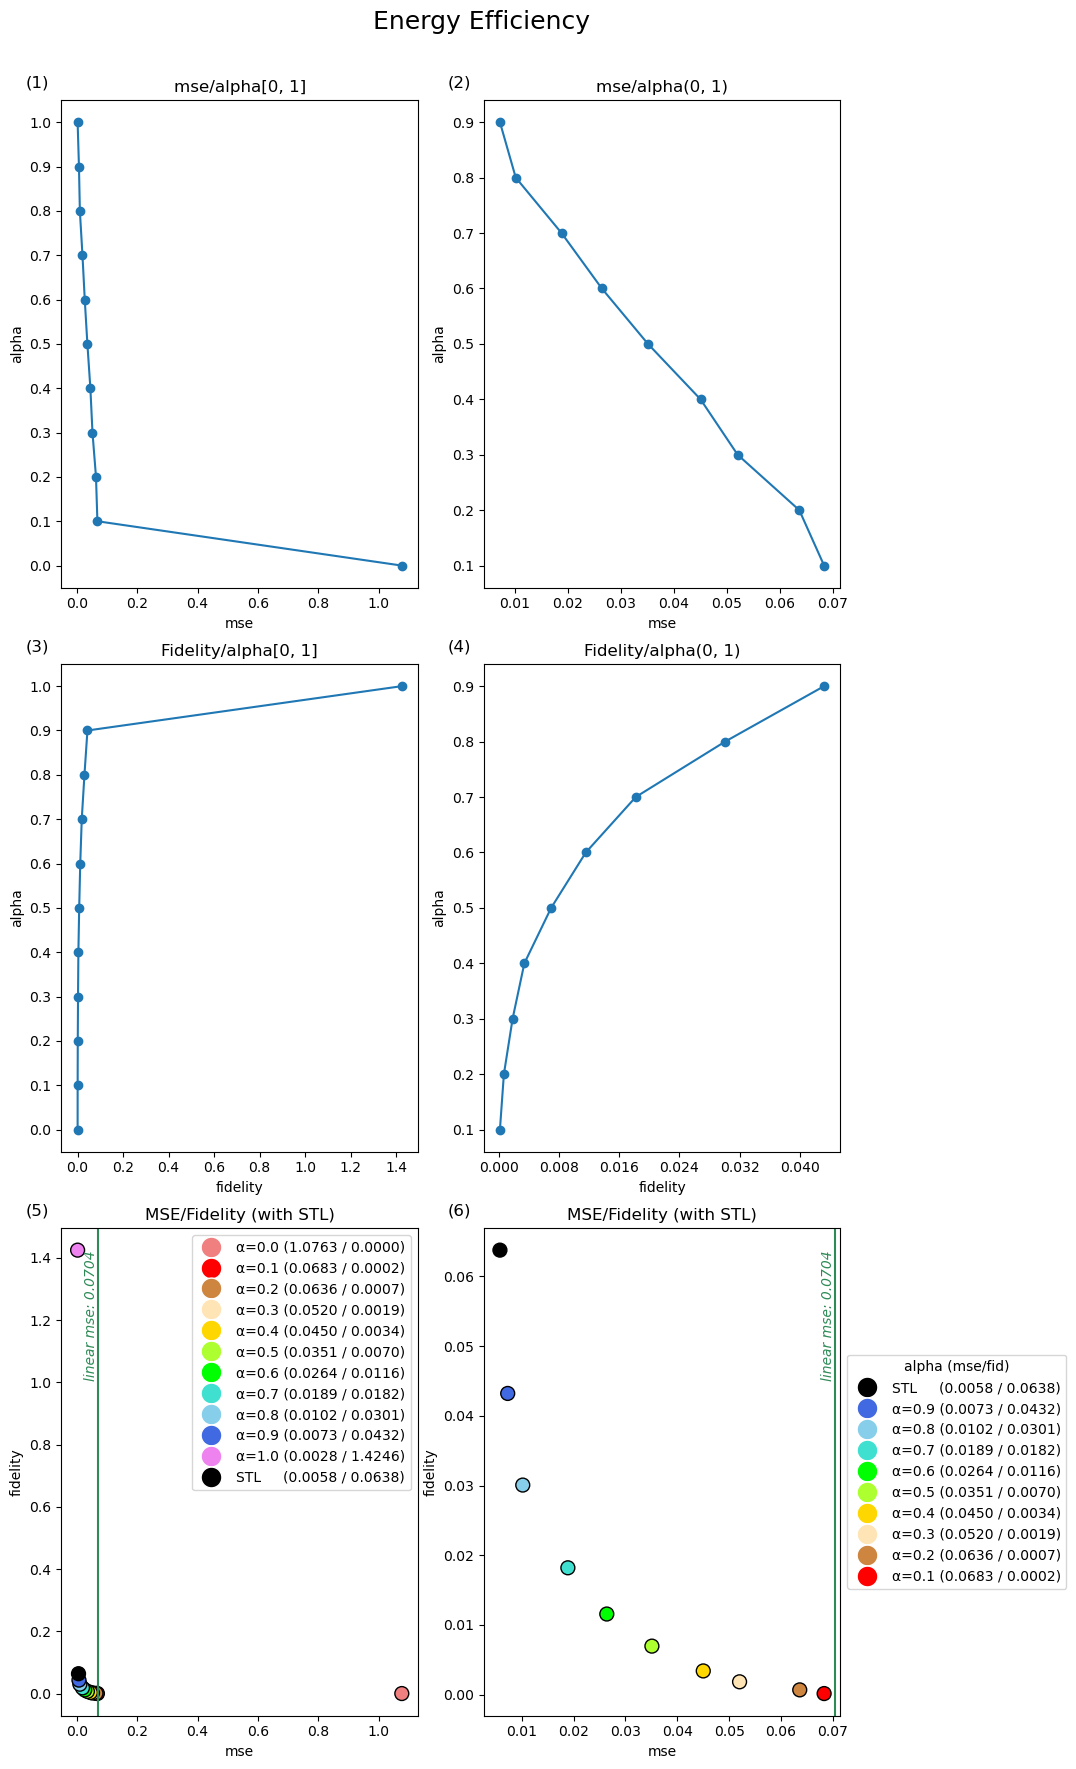

In [567]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=energy_cfg,
    title='Energy Efficiency'
)

### Local Explainability Evaluation

Creating Explainer

In [569]:
energy_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=energy_X_train_np,
    mode='regression',
    feature_names=energy_cfg.features.names,
    verbose=False,
    class_names=['Heating_Load'],
    categorical_features=energy_cfg.features.categorical_indices,
    categorical_names=energy_cfg.features.values_names,
    discretize_continuous = False
)
energy_explainer

Global Neighborhood Fidelity for STL MLP

In [570]:
# load model
mlp = MLP_reg(input_size=energy_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(energy_cfg.best_parameters, energy_cfg)).to(energy_cfg.device)
mlp.load_state_dict(torch.load(energy_cfg.models.mlp_opt + '0' + energy_cfg.models.ext))

# prediction function
energy_predict_lime = partial(predict_reg_for_lime, model=mlp, config=energy_cfg)

# neighbors dataset
print(energy_X_test_np.shape)


energy_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=energy_X_test_np,
    explainer=energy_explainer,
    config=energy_cfg,
    predict_func_lime=energy_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=energy_cfg.num
)
energy_cfg.results.stl_gnf

(77, 8)


[tensor(0.3248, dtype=torch.float64),
 tensor(0.2960, dtype=torch.float64),
 tensor(0.2905, dtype=torch.float64),
 tensor(0.2978, dtype=torch.float64),
 tensor(0.3270, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [571]:
gnf_for_mtl_reg_for_alpha_list(
    neighbors_dataset=energy_X_test_np,
    explainer=energy_explainer,
    model_params=energy_cfg.best_parameters,
    config=energy_cfg,
    n=energy_cfg.num
)

energy_cfg.results.mtl_gnf

Model: Energy/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0161, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1005, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.2_0.pt, GNF: [tensor(0.1194, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.3_0.pt, GNF: [tensor(0.1118, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.4_0.pt, GNF: [tensor(0.1968, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.5_0.pt, GNF: [tensor(0.1573, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1466, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.7_0.pt, GNF: [tensor(0.1667, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.8_0.pt, GNF: [tensor(0.2290, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.9_0.pt, GNF: [tensor(0.4340, dtype=torch.float64)]
Model: Energy/mtl_alpha_1.0_0.pt, GNF: [tensor(0.2542, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0161, dtype=torch.float64)]
Model: Energy/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0892, dtype=torch.float64)]

{0: {'0.0': [tensor(0.0161, dtype=torch.float64)],
  '0.1': [tensor(0.1005, dtype=torch.float64)],
  '0.2': [tensor(0.1194, dtype=torch.float64)],
  '0.3': [tensor(0.1118, dtype=torch.float64)],
  '0.4': [tensor(0.1968, dtype=torch.float64)],
  '0.5': [tensor(0.1573, dtype=torch.float64)],
  '0.6': [tensor(0.1466, dtype=torch.float64)],
  '0.7': [tensor(0.1667, dtype=torch.float64)],
  '0.8': [tensor(0.2290, dtype=torch.float64)],
  '0.9': [tensor(0.4340, dtype=torch.float64)],
  '1.0': [tensor(0.2542, dtype=torch.float64)]},
 1: {'0.0': [tensor(0.0161, dtype=torch.float64)],
  '0.1': [tensor(0.0892, dtype=torch.float64)],
  '0.2': [tensor(0.1078, dtype=torch.float64)],
  '0.3': [tensor(0.1052, dtype=torch.float64)],
  '0.4': [tensor(0.1997, dtype=torch.float64)],
  '0.5': [tensor(0.1597, dtype=torch.float64)],
  '0.6': [tensor(0.1397, dtype=torch.float64)],
  '0.7': [tensor(0.1554, dtype=torch.float64)],
  '0.8': [tensor(0.2301, dtype=torch.float64)],
  '0.9': [tensor(0.4582, dtype=to

In [ ]:
show_tables_lime(energy_cfg) 

## Blood Transfusion Service Center

### Preparation

#### Configuration Settings

In [666]:
blood_cfg = Config(
    folders=Folders(base="Blood/"),
    files=Files(
        data="blood_data.pkl", 
        targets="blood_targets.pkl", 
        study='Blood.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=34),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [667]:
# Data Loading
blood_df = pd.read_pickle(blood_cfg.paths.data)

blood_cfg.features.numerical = blood_df.select_dtypes(include='number').columns.values.tolist()
blood_cfg.features.numerical_indices = [blood_df.columns.get_loc(feature) for feature in blood_cfg.features.numerical]
blood_cfg.features.categorical = blood_df.select_dtypes(include='object').columns.values.tolist()
blood_cfg.features.categorical_indices = [blood_df.columns.get_loc(feature) for feature in blood_cfg.features.categorical]
blood_cfg.features.names = blood_df.columns.values.tolist()


# Creating Dictionary 
blood_cfg.features.values_names = {}
for feature, idx in zip(blood_cfg.features.categorical, blood_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(blood_df[feature])
    blood_df[feature] = le.transform(blood_df[feature])
    blood_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
blood_X_train, blood_X_test, blood_y_train, blood_y_test = train_test_split(
    blood_df,
    np.array(pd.read_pickle(blood_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

blood_X_eval, blood_X_test, blood_y_eval, blood_y_test = train_test_split(
    blood_X_test, 
    blood_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
blood_scaler = StandardScaler()
blood_X_train[blood_cfg.features.numerical] = blood_scaler.fit_transform(blood_X_train[blood_cfg.features.numerical]).astype(float)
blood_X_train[blood_cfg.features.categorical] = blood_X_train[blood_cfg.features.categorical].astype(float)

blood_X_eval[blood_cfg.features.numerical] = blood_scaler.transform(blood_X_eval[blood_cfg.features.numerical]).astype(float)
blood_X_eval[blood_cfg.features.categorical] = blood_X_eval[blood_cfg.features.categorical].astype(float)

blood_X_test[blood_cfg.features.numerical] = blood_scaler.transform(blood_X_test[blood_cfg.features.numerical]).astype(float)
blood_X_test[blood_cfg.features.categorical] = blood_X_test[blood_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
blood_cfg.features.dummy = pd.get_dummies(blood_df.astype(float), columns=blood_cfg.features.categorical, dtype=float).columns 

blood_X_train_encoded = pd.get_dummies(blood_X_train, columns=blood_cfg.features.categorical, dtype=float)
blood_X_train_encoded = blood_X_train_encoded.reindex(columns=blood_cfg.features.dummy, fill_value=0.0).values

blood_X_eval_encoded = pd.get_dummies(blood_X_eval, columns=blood_cfg.features.categorical, dtype=float)
blood_X_eval_encoded = blood_X_eval_encoded.reindex(columns=blood_cfg.features.dummy, fill_value=0.0).values

blood_X_test_encoded = pd.get_dummies(blood_X_test, columns=blood_cfg.features.categorical, dtype=float)
blood_X_test_encoded = blood_X_test_encoded.reindex(columns=blood_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
blood_X_train_tensor = torch.tensor(blood_X_train_encoded, dtype=torch.float32)
blood_X_eval_tensor = torch.tensor(blood_X_eval_encoded, dtype=torch.float32)
blood_X_test_tensor = torch.tensor(blood_X_test_encoded, dtype=torch.float32)

blood_y_train_tensor = torch.tensor(blood_y_train, dtype=torch.float32)
blood_y_eval_tensor = torch.tensor(blood_y_eval, dtype=torch.float32)
blood_y_test_tensor = torch.tensor(blood_y_test, dtype=torch.float32)

blood_X_train_np = blood_X_train.values
blood_X_eval_np = blood_X_eval.values
blood_X_test_np = blood_X_test.values

# Updating Configuration 
blood_cfg.input_size = blood_X_train_tensor.shape[1]
blood_cfg.tuning.min_neurons = blood_cfg.input_size // 4 - 1
blood_cfg.tuning.max_neurons = blood_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [668]:
def train_and_optimize_blood(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_with_early_stopping(
        data_train=blood_X_train_tensor,
        target_train=blood_y_train_tensor,
        data_eval=blood_X_eval_tensor,
        target_eval=blood_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [669]:
def study_blood(config: Config):
    objective = partial(train_and_optimize_blood, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

blood_study = try_load_study(study_blood, blood_cfg)

In [670]:
blood_study_sorted = blood_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1)
blood_study_sorted.head(5)

number     value               duration  params_num_layers  \
34      34  0.853333 0 days 00:00:02.545105                  5   
6        6  0.853333 0 days 00:00:02.850721                  1   
1        1  0.853333 0 days 00:00:02.928718                  5   
33      33  0.840000 0 days 00:00:02.633180                  4   
32      32  0.840000 0 days 00:00:02.249845                  4   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
34                   16                 12.0                  7.0   
6                     3                  NaN                  NaN   
1                    14                 12.0                 10.0   
33                   15                 10.0                 10.0   
32                   15                 14.0                  6.0   

    params_num_neurons3  params_num_neurons4     state  
34                 17.0                  9.0  COMPLETE  
6                   NaN                  NaN  COMPLETE  
1                  15.0                 16.0  COMPLETE  
33                 10.0                  NaN  COMPLETE  
32                 15.0                  NaN  COMPLETE

In [671]:
blood_cfg.best_parameters = blood_study.trials[blood_study_sorted.iloc[0].number].params
blood_cfg.best_parameters

{'num_layers': 5,
 'num_neurons0': 16,
 'num_neurons1': 12,
 'num_neurons2': 7,
 'num_neurons3': 17,
 'num_neurons4': 9}

### Training and Testing MLP

In [672]:
train_and_test_mlp_cls(
    X_train=blood_X_train_tensor, 
    y_train=blood_y_train_tensor,
    X_eval=blood_X_eval_tensor, 
    y_eval=blood_y_eval_tensor, 
    X_test=blood_X_test_tensor, 
    y_test=blood_y_test_tensor, 
    config=blood_cfg
)
print(np.mean(list(blood_cfg.results.stl_mlp.values())))
blood_cfg.results.stl_mlp

Model Blood/mlp_opt_0.pt cannot be loaded. Training has started...
Epoch: 0, result (AccuracyScore): 0.8133333325386047
Epoch: 5, result (AccuracyScore): 0.8133333325386047
Epoch: 10, result (AccuracyScore): 0.8133333325386047
Epoch: 15, result (AccuracyScore): 0.8133333325386047
Epoch: 20, result (AccuracyScore): 0.8533333539962769
Epoch: 25, result (AccuracyScore): 0.8400000333786011
Epoch: 30, result (AccuracyScore): 0.8400000333786011
Epoch: 35, result (AccuracyScore): 0.8400000333786011
Epoch: 40, result (AccuracyScore): 0.8266667127609253
Epoch: 45, result (AccuracyScore): 0.8133333325386047
Epoch: 50, result (AccuracyScore): 0.8400000333786011
Epoch: 55, result (AccuracyScore): 0.8266667127609253
Early stopping on epoch: 58, best results from epoch: 24 result (AccuracyScore): 0.8666666746139526
Model Blood/mlp_opt_1.pt cannot be loaded. Training has started...
Epoch: 0, result (AccuracyScore): 0.18666666746139526
Epoch: 5, result (AccuracyScore): 0.8266667127609253
Epoch: 10, re

{0: 0.7200000286102295,
 1: 0.7066667079925537,
 2: 0.6933333277702332,
 3: 0.6933333277702332,
 4: 0.6933333277702332}

### Training and Testing Linear Model

In [679]:
train_and_test_lin_cls(
    X_train=blood_X_train_tensor, 
    y_train=blood_y_train_tensor,
    X_eval=blood_X_eval_tensor, 
    y_eval=blood_y_eval_tensor, 
    X_test=blood_X_test_tensor, 
    y_test=blood_y_test_tensor, 
    config=blood_cfg
)
print(np.mean(list(blood_cfg.results.reg.values())))
blood_cfg.results.reg

Model Blood/reg_0.pt loaded successfully
Model Blood/reg_1.pt loaded successfully
Model Blood/reg_2.pt loaded successfully
Model Blood/reg_3.pt loaded successfully
Model Blood/reg_4.pt loaded successfully
0.7226666927337646


{0: 0.7066667079925537,
 1: 0.746666669845581,
 2: 0.7200000286102295,
 3: 0.7333333492279053,
 4: 0.7066667079925537}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [674]:
train_and_test_stl_lin_cls(
    X_train=blood_X_train_tensor, 
    X_eval=blood_X_eval_tensor, 
    X_test=blood_X_test_tensor, 
    config=blood_cfg
)
print(np.mean(list(blood_cfg.results.stl_reg.values())))
blood_cfg.results.stl_reg

Model Blood/stl_reg_0.pt loaded successfully
Model Blood/stl_reg_1.pt loaded successfully
Model Blood/stl_reg_2.pt loaded successfully
Model Blood/stl_reg_3.pt loaded successfully
Model Blood/stl_reg_4.pt loaded successfully
0.2906666725873947


{0: 0.1066666692495346,
 1: 0.14666667580604553,
 2: 0.1066666692495346,
 3: 0.9200000166893005,
 4: 0.1733333319425583}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [675]:
train_and_test_mtl_cls_n_times(
    data_train=blood_X_train_tensor,
    target_train=blood_y_train_tensor,
    data_eval=blood_X_eval_tensor, 
    target_eval=blood_y_eval_tensor, 
    data_test=blood_X_test_tensor, 
    target_test=blood_y_test_tensor, 
    config=blood_cfg
)
blood_cfg.results.mtl

Model for alpha: 0.0
Model Blood/mtl_alpha_0.0_0.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.18666666746139526, fid: 0.5600000023841858
Epoch: 5, acc: 0.18666666746139526, fid: 0.3466666638851166
Epoch: 10, acc: 0.2800000011920929, fid: 0.18666666746139526
Epoch: 15, acc: 0.41333335638046265, fid: 0.03999999910593033
Epoch: 20, acc: 0.41333335638046265, fid: 0.0533333346247673
Epoch: 25, acc: 0.4266666769981384, fid: 0.03999999910593033
Epoch: 30, acc: 0.3866666853427887, fid: 0.013333333656191826
Epoch: 35, acc: 0.3866666853427887, fid: 0.013333333656191826
Epoch: 40, acc: 0.3866666853427887, fid: 0.0
Epoch: 45, acc: 0.41333335638046265, fid: 0.02666666731238365
Epoch: 50, acc: 0.41333335638046265, fid: 0.013333333656191826
Epoch: 55, acc: 0.41333335638046265, fid: 0.013333333656191826
Epoch: 60, acc: 0.4000000059604645, fid: 0.02666666731238365
Epoch: 65, acc: 0.4000000059604645, fid: 0.02666666731238365
Early stopping on epoch: 68, best results from epoch: 34
Accur

{0: {'0.0': Result(metrics=0.4933333396911621, fid=0.02666666731238365),
  '0.1': Result(metrics=0.7066667079925537, fid=0.0),
  '0.2': Result(metrics=0.6933333277702332, fid=0.013333333656191826),
  '0.3': Result(metrics=0.6933333277702332, fid=0.0),
  '0.4': Result(metrics=0.6933333277702332, fid=0.0),
  '0.5': Result(metrics=0.6933333277702332, fid=0.0),
  '0.6': Result(metrics=0.6933333277702332, fid=0.0),
  '0.7': Result(metrics=0.7333333492279053, fid=0.1066666692495346),
  '0.8': Result(metrics=0.7200000286102295, fid=0.09333333373069763),
  '0.9': Result(metrics=0.7200000286102295, fid=0.1066666692495346),
  '1.0': Result(metrics=0.7200000286102295, fid=0.41333335638046265)},
 1: {'0.0': Result(metrics=0.7066667079925537, fid=0.0),
  '0.1': Result(metrics=0.6933333277702332, fid=0.0),
  '0.2': Result(metrics=0.6933333277702332, fid=0.013333333656191826),
  '0.3': Result(metrics=0.6933333277702332, fid=0.0),
  '0.4': Result(metrics=0.7066667079925537, fid=0.013333333656191826),


### Comparison of STL with MTL

In [677]:
blood_cfg.metrics_label = 'ACC'
show_tables(blood_cfg) 

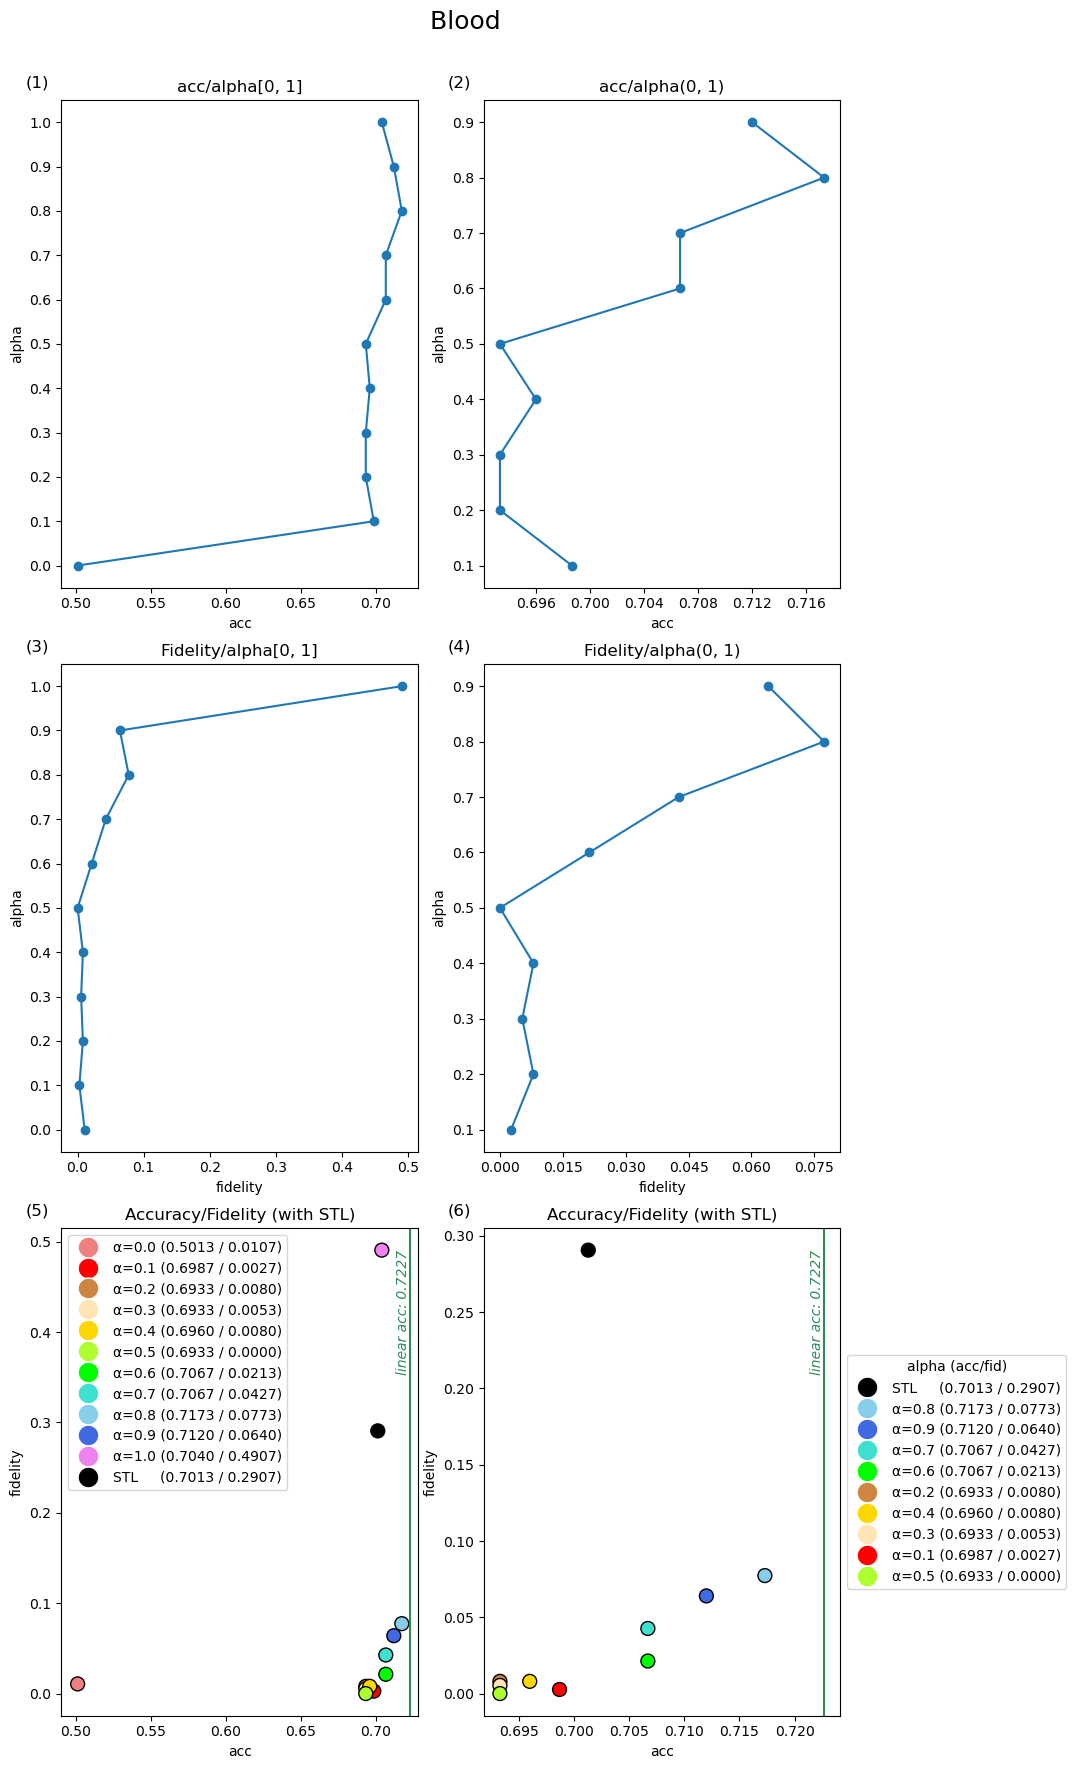

In [678]:
draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=blood_cfg,
    title='Blood    '
)

### Local Explainability Evaluation

Creating Explainer

In [680]:
blood_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=blood_X_train_np,
    mode='classification',
    feature_names=blood_cfg.features.names,
    verbose=False,
    class_names=['no blood donated', 'blood donated'],
    categorical_features=blood_cfg.features.categorical_indices,
    categorical_names=blood_cfg.features.values_names,
    discretize_continuous=False
)
blood_explainer

Global Neighborhood Fidelity for STL MLP

In [681]:
# load model
mlp = MLP_cls(input_size=blood_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(blood_cfg.best_parameters, blood_cfg)).to(blood_cfg.device)
mlp.load_state_dict(torch.load(blood_cfg.models.mlp_opt + '0' + blood_cfg.models.ext))

# prediction function
blood_predict_lime = partial(predict_cls_for_lime, model=mlp, config=blood_cfg)

# neighbors dataset
print(blood_X_test_np.shape)


blood_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=blood_X_test_np,
    explainer=blood_explainer,
    config=blood_cfg,
    predict_func_lime=blood_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=blood_cfg.num
)
blood_cfg.results.stl_gnf

(75, 4)


[tensor(0.0640),
 tensor(0.0547),
 tensor(0.0747),
 tensor(0.0693),
 tensor(0.0640)]

Global Neighborhood Fidelity for MTL

In [682]:
gnf_for_mtl_cls_for_alpha_list(
    neighbors_dataset=blood_X_test_np,
    explainer=blood_explainer,
    model_params=blood_cfg.best_parameters,
    config=blood_cfg
)

Model: Blood/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0107)]
Model: Blood/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0067)]
Model: Blood/mtl_alpha_0.2_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0573)]
Model: Blood/mtl_alpha_0.4_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.5_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.6_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0813)]
Model: Blood/mtl_alpha_0.8_0.pt, GNF: [tensor(0.0627)]
Model: Blood/mtl_alpha_0.9_0.pt, GNF: [tensor(0.0800)]
Model: Blood/mtl_alpha_1.0_0.pt, GNF: [tensor(0.0840)]
Model: Blood/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0147)]
Model: Blood/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0147)]
Model: Blood/mtl_alpha_0.2_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0533)]
Model: Blood/mtl_alpha_0.4_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.5_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.6_0.pt, GNF: [tensor(0.)]
Model: Blood/mtl_alpha_0.7_0.pt, GNF: [ten

In [683]:
show_tables_lime(blood_cfg) 

## Sonar

### Preparation

#### Configuration Settings

In [602]:
sonar_cfg = Config(
    folders=Folders(base="Sonar/"),
    files=Files(
        data="sonar_data.pkl", 
        targets="sonar_targets.pkl", 
        study='Sonar.plt'
    ),
    training=Training(batch_size=64),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [603]:
# Data Loading
sonar_df = pd.read_pickle(sonar_cfg.paths.data)

sonar_cfg.features.numerical = sonar_df.select_dtypes(include='number').columns.values.tolist()
sonar_cfg.features.numerical_indices = [sonar_df.columns.get_loc(feature) for feature in sonar_cfg.features.numerical]
sonar_cfg.features.categorical = sonar_df.select_dtypes(include='object').columns.values.tolist()
sonar_cfg.features.categorical_indices = [sonar_df.columns.get_loc(feature) for feature in sonar_cfg.features.categorical]
sonar_cfg.features.names = sonar_df.columns.values.tolist()


# Creating Dictionary 
sonar_cfg.features.values_names = {}
for feature, idx in zip(sonar_cfg.features.categorical, sonar_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(sonar_df[feature])
    sonar_df[feature] = le.transform(sonar_df[feature])
    sonar_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
sonar_X_train, sonar_X_test, sonar_y_train, sonar_y_test = train_test_split(
    sonar_df,
    np.array(pd.read_pickle(sonar_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

sonar_X_eval, sonar_X_test, sonar_y_eval, sonar_y_test = train_test_split(
    sonar_X_test, 
    sonar_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
sonar_scaler = StandardScaler()
sonar_X_train[sonar_cfg.features.numerical] = sonar_scaler.fit_transform(sonar_X_train[sonar_cfg.features.numerical]).astype(float)
sonar_X_train[sonar_cfg.features.categorical] = sonar_X_train[sonar_cfg.features.categorical].astype(float)

sonar_X_eval[sonar_cfg.features.numerical] = sonar_scaler.transform(sonar_X_eval[sonar_cfg.features.numerical]).astype(float)
sonar_X_eval[sonar_cfg.features.categorical] = sonar_X_eval[sonar_cfg.features.categorical].astype(float)

sonar_X_test[sonar_cfg.features.numerical] = sonar_scaler.transform(sonar_X_test[sonar_cfg.features.numerical]).astype(float)
sonar_X_test[sonar_cfg.features.categorical] = sonar_X_test[sonar_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
sonar_cfg.features.dummy = pd.get_dummies(sonar_df.astype(float), columns=sonar_cfg.features.categorical, dtype=float).columns 

sonar_X_train_encoded = pd.get_dummies(sonar_X_train, columns=sonar_cfg.features.categorical, dtype=float)
sonar_X_train_encoded = sonar_X_train_encoded.reindex(columns=sonar_cfg.features.dummy, fill_value=0.0).values

sonar_X_eval_encoded = pd.get_dummies(sonar_X_eval, columns=sonar_cfg.features.categorical, dtype=float)
sonar_X_eval_encoded = sonar_X_eval_encoded.reindex(columns=sonar_cfg.features.dummy, fill_value=0.0).values

sonar_X_test_encoded = pd.get_dummies(sonar_X_test, columns=sonar_cfg.features.categorical, dtype=float)
sonar_X_test_encoded = sonar_X_test_encoded.reindex(columns=sonar_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
sonar_X_train_tensor = torch.tensor(sonar_X_train_encoded, dtype=torch.float32)
sonar_X_eval_tensor = torch.tensor(sonar_X_eval_encoded, dtype=torch.float32)
sonar_X_test_tensor = torch.tensor(sonar_X_test_encoded, dtype=torch.float32)

sonar_y_train_tensor = torch.tensor(sonar_y_train, dtype=torch.float32)
sonar_y_eval_tensor = torch.tensor(sonar_y_eval, dtype=torch.float32)
sonar_y_test_tensor = torch.tensor(sonar_y_test, dtype=torch.float32)

sonar_X_train_np = sonar_X_train.values
sonar_X_eval_np = sonar_X_eval.values
sonar_X_test_np = sonar_X_test.values

# Updating Configuration 
sonar_cfg.input_size = sonar_X_train_tensor.shape[1]
sonar_cfg.tuning.min_neurons = sonar_cfg.input_size // 4 - 1
sonar_cfg.tuning.max_neurons = sonar_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [604]:
def train_and_optimize_sonar(trial, config: Config):
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_with_early_stopping(
        data_train=sonar_X_train_tensor,
        target_train=sonar_y_train_tensor,
        data_eval=sonar_X_eval_tensor,
        target_eval=sonar_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [605]:
def study_sonar(config: Config):
    objective = partial(train_and_optimize_sonar, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

sonar_study = try_load_study(study_sonar, sonar_cfg)

[I 2024-09-04 03:11:57,430] A new study created in memory with name: Sonar.plt


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, result (AccuracyScore): 0.761904776096344
Epoch: 5, result (AccuracyScore): 0.8095238208770752
Epoch: 10, result (AccuracyScore): 0.8095238208770752
Early stopping on epoch: 11, best results from epoch: 1 result (AccuracyScore): 0.8571428656578064
[I 2024-09-04 03:11:57,736] Trial 0 finished with value: 0.8571428656578064 and parameters: {'num_layers': 1, 'num_neurons0': 118}. Best is trial 0 with value: 0.8571428656578064.
Epoch: 0, result (AccuracyScore): 0.6190476417541504
Epoch: 5, result (AccuracyScore): 0.8095238208770752
Epoch: 10, result (AccuracyScore): 0.8571428656578064
Epoch: 15, result (AccuracyScore): 0.9047619104385376
Epoch: 20, result (AccuracyScore): 0.9047619104385376
Early stopping on epoch: 21, best results from epoch: 11 result (AccuracyScore): 0.9047619104385376
[I 2024-09-04 03:11:58,247] Trial 1 finished with value: 0.9047619104385376 and parameters: {'num_layers': 4, 'num_neurons0': 189, 'num_neurons1': 51, 'num_neurons2': 38, 'num_neurons3': 98}. Be

In [606]:
sonar_study_sorted = sonar_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1)
sonar_study_sorted.head(5)

number     value               duration  params_num_layers  \
12      12  0.952381 0 days 00:00:00.482000                  5   
16      16  0.952381 0 days 00:00:00.438994                  3   
9        9  0.952381 0 days 00:00:00.513609                  3   
10      10  0.952381 0 days 00:00:00.397728                  5   
11      11  0.952381 0 days 00:00:00.438311                  5   

    params_num_neurons0  params_num_neurons1  params_num_neurons2  \
12                   72                154.0                241.0   
16                   90                178.0                 99.0   
9                   102                220.0                108.0   
10                   49                154.0                238.0   
11                   44                153.0                231.0   

    params_num_neurons3  params_num_neurons4     state  
12                239.0                218.0  COMPLETE  
16                  NaN                  NaN  COMPLETE  
9                   NaN                  NaN  COMPLETE  
10                239.0                199.0  COMPLETE  
11                238.0                197.0  COMPLETE

In [607]:
sonar_cfg.best_parameters = sonar_study.trials[sonar_study_sorted.iloc[0].number].params
sonar_cfg.best_parameters

{'num_layers': 5,
 'num_neurons0': 72,
 'num_neurons1': 154,
 'num_neurons2': 241,
 'num_neurons3': 239,
 'num_neurons4': 218}

### Training and Testing MLP

In [608]:
train_and_test_mlp_cls(
    X_train=sonar_X_train_tensor, 
    y_train=sonar_y_train_tensor,
    X_eval=sonar_X_eval_tensor, 
    y_eval=sonar_y_eval_tensor, 
    X_test=sonar_X_test_tensor, 
    y_test=sonar_y_test_tensor, 
    config=sonar_cfg
)
print(np.mean(list(sonar_cfg.results.stl_mlp.values())))
sonar_cfg.results.stl_mlp

Model Sonar/mlp_opt_0.pt cannot be loaded. Training has started...
Epoch: 0, result (AccuracyScore): 0.4761904776096344
Epoch: 5, result (AccuracyScore): 0.7142857313156128
Epoch: 10, result (AccuracyScore): 0.8095238208770752
Epoch: 15, result (AccuracyScore): 0.8571428656578064
Early stopping on epoch: 19, best results from epoch: 9 result (AccuracyScore): 0.8571428656578064
Model Sonar/mlp_opt_1.pt cannot be loaded. Training has started...
Epoch: 0, result (AccuracyScore): 0.523809552192688
Epoch: 5, result (AccuracyScore): 0.761904776096344
Epoch: 10, result (AccuracyScore): 0.8095238208770752
Epoch: 15, result (AccuracyScore): 0.9047619104385376
Epoch: 20, result (AccuracyScore): 0.9047619104385376
Early stopping on epoch: 23, best results from epoch: 13 result (AccuracyScore): 0.9047619104385376
Model Sonar/mlp_opt_2.pt cannot be loaded. Training has started...
Epoch: 0, result (AccuracyScore): 0.8095238208770752
Epoch: 5, result (AccuracyScore): 0.9047619104385376
Epoch: 10, res

{0: 0.761904776096344,
 1: 0.9047619104385376,
 2: 0.9047619104385376,
 3: 0.9047619104385376,
 4: 0.9047619104385376}

### Training and Testing Linear Model

In [610]:
train_and_test_lin_cls(
    X_train=sonar_X_train_tensor, 
    y_train=sonar_y_train_tensor,
    X_eval=sonar_X_eval_tensor, 
    y_eval=sonar_y_eval_tensor, 
    X_test=sonar_X_test_tensor, 
    y_test=sonar_y_test_tensor, 
    config=sonar_cfg
)
print(np.mean(list(sonar_cfg.results.reg.values())))
sonar_cfg.results.reg

Model Sonar/reg_0.pt loaded successfully
Model Sonar/reg_1.pt loaded successfully
Model Sonar/reg_2.pt loaded successfully
Model Sonar/reg_3.pt loaded successfully
Model Sonar/reg_4.pt loaded successfully
0.7047619163990021


{0: 0.7142857313156128,
 1: 0.8571428656578064,
 2: 0.4761904776096344,
 3: 0.6666666865348816,
 4: 0.8095238208770752}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [611]:
train_and_test_stl_lin_cls(
    X_train=sonar_X_train_tensor, 
    X_eval=sonar_X_eval_tensor, 
    X_test=sonar_X_test_tensor, 
    config=sonar_cfg
)
print(np.mean(list(sonar_cfg.results.stl_reg.values())))
sonar_cfg.results.stl_reg

Model Sonar/stl_reg_0.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 0.380952388048172
Epoch: 5, result (GlobalFidelity): 0.2380952388048172
Epoch: 10, result (GlobalFidelity): 0.190476194024086
Epoch: 15, result (GlobalFidelity): 0.190476194024086
Early stopping on epoch: 19, best results from epoch: 9 result (GlobalFidelity): 0.190476194024086
Model Sonar/stl_reg_1.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 0.523809552192688
Epoch: 5, result (GlobalFidelity): 0.4761904776096344
Epoch: 10, result (GlobalFidelity): 0.4761904776096344
Early stopping on epoch: 11, best results from epoch: 1 result (GlobalFidelity): 0.4761904776096344
Model Sonar/stl_reg_2.pt cannot be loaded. Training has started...
Epoch: 0, result (GlobalFidelity): 0.523809552192688
Epoch: 5, result (GlobalFidelity): 0.4285714328289032
Epoch: 10, result (GlobalFidelity): 0.190476194024086
Epoch: 15, result (GlobalFidelity): 0.2380952388048172
Early s

{0: 0.190476194024086,
 1: 0.6190476417541504,
 2: 0.0476190485060215,
 3: 0.2857142984867096,
 4: 0.4285714328289032}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [612]:
train_and_test_mtl_cls_n_times(
    data_train=sonar_X_train_tensor,
    target_train=sonar_y_train_tensor,
    data_eval=sonar_X_eval_tensor, 
    target_eval=sonar_y_eval_tensor, 
    data_test=sonar_X_test_tensor, 
    target_test=sonar_y_test_tensor, 
    config=sonar_cfg
)
sonar_cfg.results.mtl

Model for alpha: 0.0
Model Sonar/mtl_alpha_0.0_0.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.523809552192688, fid: 0.380952388048172
Epoch: 5, acc: 0.3333333432674408, fid: 0.190476194024086
Epoch: 10, acc: 0.3333333432674408, fid: 0.095238097012043
Epoch: 15, acc: 0.2857142984867096, fid: 0.1428571492433548
Epoch: 20, acc: 0.3333333432674408, fid: 0.095238097012043
Early stopping on epoch: 20, best results from epoch: 10
Accuracy: 0.3333333432674408, Fidelity: 0.095238097012043
Result on test dataset: Sonar/mtl_alpha_0.0_0.pt, Accuracy: 0.4285714328289032, Fidelity: 0.1428571492433548
Model for alpha: 0.1
Model Sonar/mtl_alpha_0.1_0.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.6190476417541504, fid: 0.190476194024086
Epoch: 5, acc: 0.6666666865348816, fid: 0.190476194024086
Epoch: 10, acc: 0.761904776096344, fid: 0.190476194024086
Epoch: 15, acc: 0.8571428656578064, fid: 0.190476194024086
Epoch: 20, acc: 0.8571428656578064, fid: 0.0476190485060215
Ep

{0: {'0.0': Result(metrics=0.4285714328289032, fid=0.1428571492433548),
  '0.1': Result(metrics=0.761904776096344, fid=0.2857142984867096),
  '0.2': Result(metrics=0.6190476417541504, fid=0.190476194024086),
  '0.3': Result(metrics=0.8095238208770752, fid=0.2380952388048172),
  '0.4': Result(metrics=0.9523809552192688, fid=0.1428571492433548),
  '0.5': Result(metrics=0.761904776096344, fid=0.190476194024086),
  '0.6': Result(metrics=0.8571428656578064, fid=0.2857142984867096),
  '0.7': Result(metrics=0.761904776096344, fid=0.2857142984867096),
  '0.8': Result(metrics=0.9047619104385376, fid=0.2380952388048172),
  '0.9': Result(metrics=0.8571428656578064, fid=0.1428571492433548),
  '1.0': Result(metrics=0.8095238208770752, fid=0.5714285969734192)},
 1: {'0.0': Result(metrics=0.2857142984867096, fid=0.0476190485060215),
  '0.1': Result(metrics=0.8095238208770752, fid=0.2857142984867096),
  '0.2': Result(metrics=0.761904776096344, fid=0.190476194024086),
  '0.3': Result(metrics=0.90476191

### Comparison of STL with MTL

In [613]:
sonar_cfg.metrics_label = "ACC"
show_tables(sonar_cfg) 

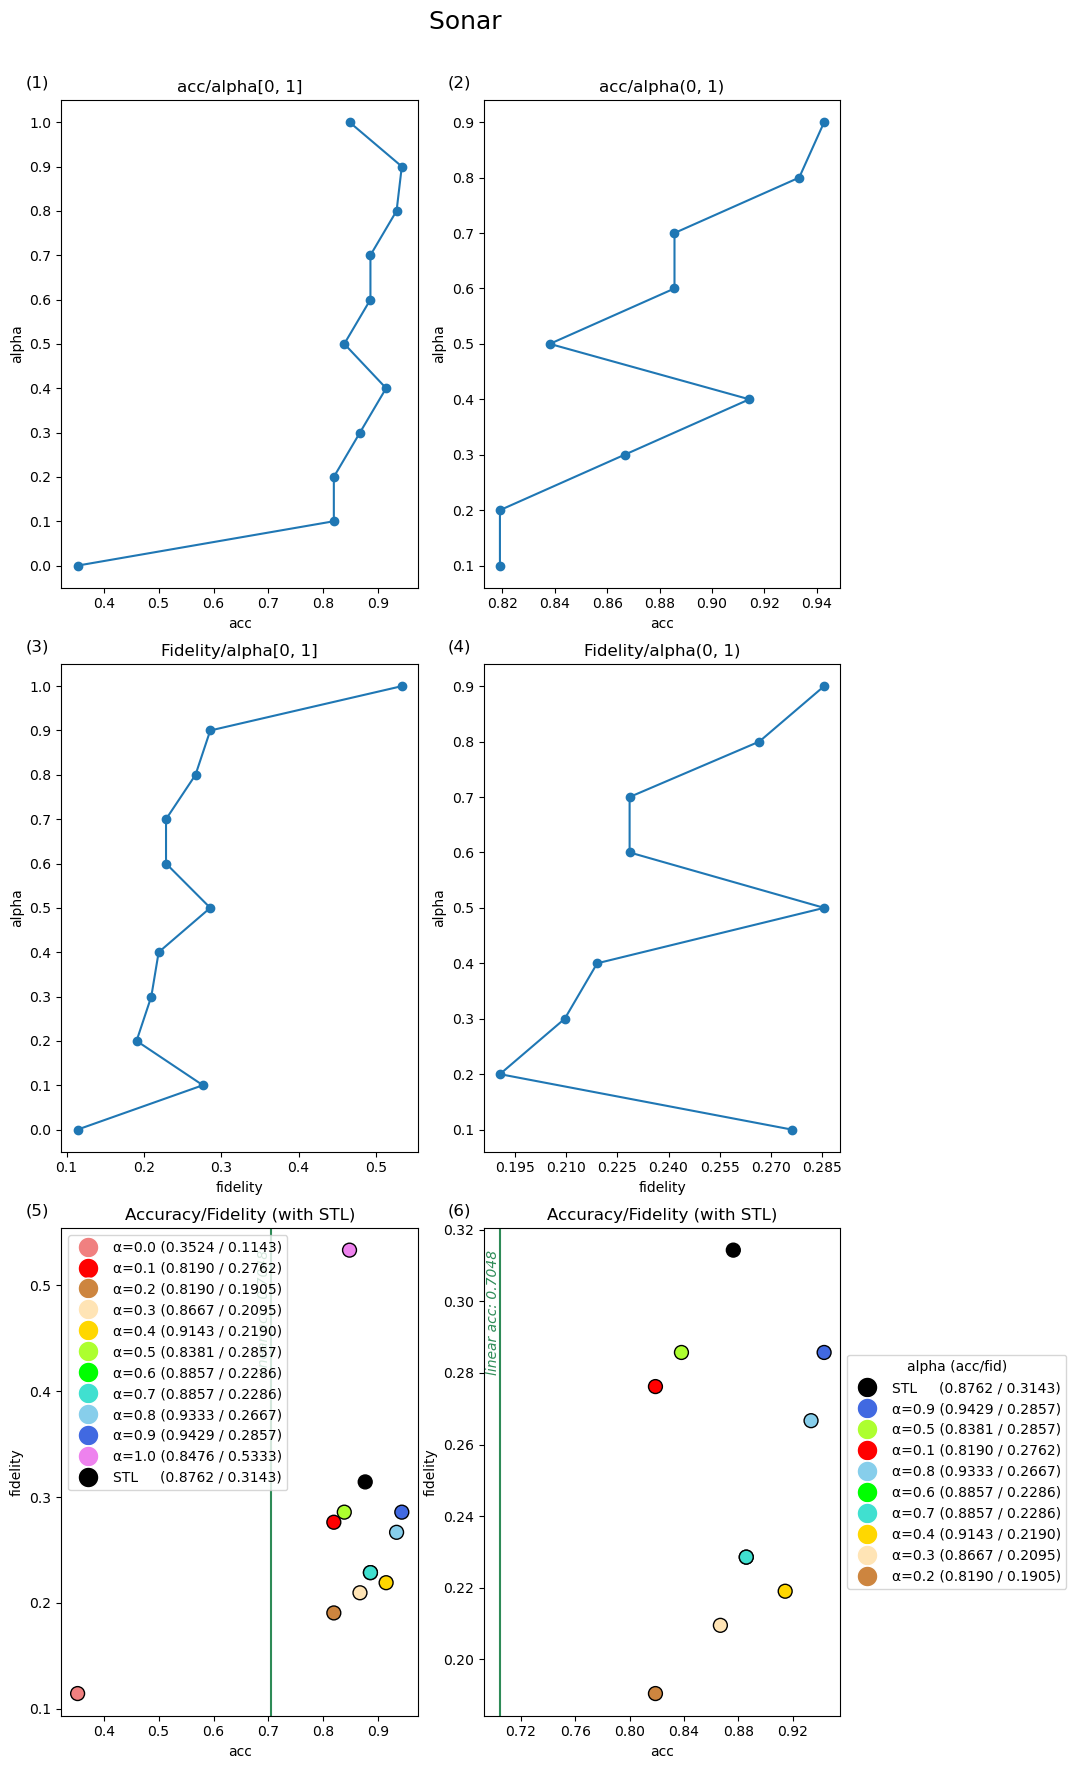

In [614]:
draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=sonar_cfg,
    title='Sonar    '
)

### Local Explainability Evaluation

Creating Explainer

In [616]:
sonar_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=sonar_X_train_np,
    mode='classification',
    feature_names=sonar_cfg.features.names,
    verbose=False,
    class_names=['rock', "mine"],
    categorical_features=sonar_cfg.features.categorical_indices,
    categorical_names=sonar_cfg.features.values_names,
    discretize_continuous=False
)
sonar_explainer

Global Neighborhood Fidelity for STL MLP

In [617]:
# load model
mlp = MLP_cls(input_size=sonar_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(sonar_cfg.best_parameters, sonar_cfg)).to(sonar_cfg.device)
mlp.load_state_dict(torch.load(sonar_cfg.models.mlp_opt + '0' + sonar_cfg.models.ext))

# prediction function
sonar_predict_lime = partial(predict_cls_for_lime, model=mlp, config=sonar_cfg)

# neighbors dataset
num_rows = 500
sonar_indices = torch.randperm(sonar_X_test_np.shape[0])[:num_rows]
sonar_neighbors_dataset = sonar_X_test_np[sonar_indices]
print(sonar_neighbors_dataset.shape)


sonar_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=sonar_neighbors_dataset,
    explainer=sonar_explainer,
    config=sonar_cfg,
    predict_func_lime=sonar_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=sonar_cfg.num
)
sonar_cfg.results.stl_gnf

(21, 60)


[tensor(0.1286),
 tensor(0.1048),
 tensor(0.2000),
 tensor(0.1619),
 tensor(0.1714)]

Global Neighborhood Fidelity for MTL

In [620]:
gnf_for_mtl_cls_for_alpha_list(
    neighbors_dataset=sonar_neighbors_dataset,
    explainer=sonar_explainer,
    model_params=sonar_cfg.best_parameters,
    config=sonar_cfg,
    n=sonar_cfg.num
)

Model: Sonar/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0905)]
Model: Sonar/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1429)]
Model: Sonar/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0143)]
Model: Sonar/mtl_alpha_0.3_0.pt, GNF: [tensor(0.1190)]
Model: Sonar/mtl_alpha_0.4_0.pt, GNF: [tensor(0.1095)]
Model: Sonar/mtl_alpha_0.5_0.pt, GNF: [tensor(0.1524)]
Model: Sonar/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1810)]
Model: Sonar/mtl_alpha_0.7_0.pt, GNF: [tensor(0.1952)]
Model: Sonar/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1000)]
Model: Sonar/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1238)]
Model: Sonar/mtl_alpha_1.0_0.pt, GNF: [tensor(0.1333)]
Model: Sonar/mtl_alpha_0.0_0.pt, GNF: [tensor(0.1000)]
Model: Sonar/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1190)]
Model: Sonar/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0190)]
Model: Sonar/mtl_alpha_0.3_0.pt, GNF: [tensor(0.1571)]
Model: Sonar/mtl_alpha_0.4_0.pt, GNF: [tensor(0.1095)]
Model: Sonar/mtl_alpha_0.5_0.pt, GNF: [tensor(0.1476)]
Model: Sonar/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1952)]
Model: Son

In [621]:
show_tables_lime(sonar_cfg) 

# Results Summary

## Base datasets

### Linear and Non-linear models comparison

In [691]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]
auto_cfg.metrics_label = 'MSE'
housing_cfg.metrics_label = 'MSE'
wine_cfg.metrics_label = 'MSE'
adult_cfg.metrics_label = 'ACC'
titanic_cfg.metrics_label = 'ACC'

results_lin_vs_non_lin = []
for config in configs:
    results_lin_vs_non_lin.append(get_results_non_lin_vs_lin(config))
results_lin_vs_non_lin = pd.concat(results_lin_vs_non_lin)

display(results_lin_vs_non_lin.style.format(precision=4, decimal=",").hide())
results_lin_vs_non_lin.to_csv("results_lin_vs_non_lin_0.csv")

### MTL and STL approaches comparison

In [319]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]

results_stl_vs_mtl = []
for config in configs:
    results_stl_vs_mtl.append(get_results_mtl_vs_stl(config))
results_stl_vs_mtl = pd.concat(results_stl_vs_mtl)

display(results_stl_vs_mtl.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl.to_csv("results_stl_vs_mtl_0.csv")


###	MTL and STL comparison in field of local explainability 

In [320]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]

results_stl_vs_mtl_gnf = []
for config in configs:
    results_stl_vs_mtl_gnf.append(get_gnf_and_metrics(config))
results_stl_vs_mtl_gnf = pd.concat(results_stl_vs_mtl_gnf)

display(results_stl_vs_mtl_gnf.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl_gnf.to_csv("results_stl_vs_mtl_gnf_0.csv")

## Additional Datasets

### Linear and Non-linear models comparison

In [684]:
configs = [concrete_cfg, yacht_cfg, energy_cfg, blood_cfg, sonar_cfg]
concrete_cfg.metrics_label = 'MSE'
yacht_cfg.metrics_label = 'MSE'
energy_cfg.metrics_label = 'MSE'
blood_cfg.metrics_label = 'ACC'
sonar_cfg.metrics_label = 'ACC'

results_lin_vs_non_lin = []
for config in configs:
    results_lin_vs_non_lin.append(get_results_non_lin_vs_lin(config))
results_lin_vs_non_lin = pd.concat(results_lin_vs_non_lin)

display(results_lin_vs_non_lin.style.format(precision=4, decimal=",").hide())
results_lin_vs_non_lin.to_csv("results_lin_vs_non_lin_add_0.csv")

### MTL and STL approaches comparison

In [686]:
configs = [concrete_cfg, yacht_cfg, energy_cfg, blood_cfg, sonar_cfg]

results_stl_vs_mtl_add = []
for config in configs:
    results_stl_vs_mtl_add.append(get_results_mtl_vs_stl(config))
results_stl_vs_mtl_add = pd.concat(results_stl_vs_mtl_add)

display(results_stl_vs_mtl_add.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl_add.to_csv("results_stl_vs_mtl_add_0.csv")


###	MTL and STL comparison in field of local explainability 

In [687]:
configs = [concrete_cfg, yacht_cfg, energy_cfg, blood_cfg, sonar_cfg]

results_stl_vs_mtl_gnf_add = []
for config in configs:
    results_stl_vs_mtl_gnf_add.append(get_gnf_and_metrics(config))
results_stl_vs_mtl_gnf_add = pd.concat(results_stl_vs_mtl_gnf_add)

display(results_stl_vs_mtl_gnf_add.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl_gnf_add.to_csv("results_stl_vs_mtl_gnf_add_0.csv")

In [872]:
# dill.dump_session('nb_env.db')

# with open('mb_env.db' ,'rb') as f:
#     dill.load(f)

# Incorporation of Local Surrogate Models in Training Process

Due to the absence of a correlation between the alpha parameter and GNF results, I decided to conduct experiments that incorporate predictions obtained using local surrogate models trained on perturbed data.
I introduced a beta parameter that establishes the relationship between global fidelity and neighbor fidelity or point fidelity during training.

## Datasets

### Auto Dataset

Point Fidelity

In [ ]:
auto_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=auto_X_train_tensor, 
    data_eval=auto_X_eval_tensor, 
    data_test=auto_X_test_tensor, 
    target_train=auto_y_train_tensor, 
    target_eval=auto_y_eval_tensor, 
    target_test=auto_y_test_tensor, 
    model_params=auto_cfg.best_parameters, 
    config=auto_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Auto/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.2_0.pt, [0.15520191192626953, 0.0005440568784251809]
Model Auto/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.4_0.pt, [0.1488657295703888, 0.0008829782018437982]
Model Auto/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.6_0.pt, [0.15347987413406372, 0.002106024418026209]
Model Auto/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.8_0.pt, [0.1291816085577011, 0.0032936171628534794]
Model Auto/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_1.0_0.pt, [0.36551496386528015, 0.16534270346164703]
Model Auto/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.3_b_0.2_0.pt, [0.14269724488258362, 0.003646285505965352]
Model Auto/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Auto/mtl_alpha_a_0.3_b_0.4_0.pt, [0.13395686447620392, 0.0052564265206456184]
Model

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    model_params=auto_cfg.best_parameters,
    config=auto_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Auto/mtl_alpha_a_0.1_b_0.2_0.pt, [0.15520191192626953, 0.0005440568784251809, 0.04536285715990822]
Model: Auto/mtl_alpha_a_0.1_b_0.4_0.pt, [0.1488657295703888, 0.0008829782018437982, 0.04181776263652122]
Model: Auto/mtl_alpha_a_0.1_b_0.6_0.pt, [0.15347987413406372, 0.002106024418026209, 0.04557658584208245]
Model: Auto/mtl_alpha_a_0.1_b_0.8_0.pt, [0.1291816085577011, 0.0032936171628534794, 0.06238102363596086]
Model: Auto/mtl_alpha_a_0.1_b_1.0_0.pt, [0.36551496386528015, 0.16534270346164703, 0.02423505299361018]
Model: Auto/mtl_alpha_a_0.3_b_0.2_0.pt, [0.14269724488258362, 0.003646285505965352, 0.053340528398392276]
Model: Auto/mtl_alpha_a_0.3_b_0.4_0.pt, [0.13395686447620392, 0.0052564265206456184, 0.05571328635904791]
Model: Auto/mtl_alpha_a_0.3_b_0.6_0.pt, [0.09864111244678497, 0.012267373502254486, 0.08255628874190354]
Model: Auto/mtl_alpha_a_0.3_b_0.8_0.pt, [0.0982990637421608, 0.028860991820693016, 0.08764003392422506]
Model: Auto/mtl_alpha_a_0.3_b_1.0_0.pt, [0.73753517866

In [ ]:
save_result_mtl_local_sur_PF(housing_cfg, ALPHA_LIST_NF, BETA_LIST_NF)


Neighborhood Fidelity

In [ ]:
auto_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=auto_X_train_tensor, 
    data_eval=auto_X_eval_tensor, 
    data_test=auto_X_test_tensor, 
    target_train=auto_y_train_tensor, 
    target_eval=auto_y_eval_tensor, 
    target_test=auto_y_test_tensor, 
    model_params=auto_cfg.best_parameters, 
    config=auto_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Auto/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.14603422582149506, 0.000577854341827333]
Model Auto/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.13579170405864716, 0.0010423219064250588]
Model Auto/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.14506515860557556, 0.0011486494913697243]
Model Auto/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.13212540745735168, 0.003963642753660679]
Model Auto/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8251973390579224, 0.12084483355283737]
Model Auto/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.14178575575351715, 0.004386983346194029]
Model Auto/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Auto/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.12165635079145432, 

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    model_params=auto_cfg.best_parameters,
    config=auto_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Auto/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.14603422582149506, 0.000577854341827333, 0.05410345391614173]
Model: Auto/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.13579170405864716, 0.0010423219064250588, 0.07652122735189845]
Model: Auto/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.14506515860557556, 0.0011486494913697243, 0.04861134314755755]
Model: Auto/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.13212540745735168, 0.003963642753660679, 0.0718692279067126]
Model: Auto/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8251973390579224, 0.12084483355283737, 0.005719611451074916]
Model: Auto/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.14178575575351715, 0.004386983346194029, 0.07533190195092032]
Model: Auto/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.12165635079145432, 0.005442148540169001, 0.07072555355890503]
Model: Auto/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.10968693345785141, 0.014119351282715797, 0.07607463717312753]
Model: Auto/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.09621250629425049, 0.025205736979842186, 0.0833045222695115]
Model: Auto/mtl_alpha_a_0.3_b_1.0_0NF.

In [ ]:
save_result_mtl_local_sur_NF(auto_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Auto/mtl_with_nf_results2.csv'

#### Housing Dataset

Point Fidelity

In [ ]:
housing_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=housing_X_train_tensor, 
    data_eval=housing_X_eval_tensor, 
    data_test=housing_X_test_tensor, 
    target_train=housing_y_train_tensor, 
    target_eval=housing_y_eval_tensor, 
    target_test=housing_y_test_tensor, 
    model_params=housing_cfg.best_parameters, 
    config=housing_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

[(0.1, 0.2), (0.1, 0.4), (0.1, 0.6), (0.3, 0.2), (0.3, 0.4), (0.3, 0.6), (0.5, 0.2), (0.5, 0.4), (0.5, 0.6)]
Model Auto/mtl_alpha_a_0.1_b_0.2_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 0.5901221632957458, fid: 0.4609456956386566
Epoch: 5, mse: 0.3573913276195526, fid: 0.1602623462677002
Epoch: 10, mse: 0.31496724486351013, fid: 0.054264333099126816
Epoch: 15, mse: 0.31169530749320984, fid: 0.01863870397210121
Epoch: 20, mse: 0.3007386326789856, fid: 0.009235827252268791
Epoch: 25, mse: 0.2921905219554901, fid: 0.005577708128839731
Epoch: 30, mse: 0.2841176986694336, fid: 0.0035674236714839935
Epoch: 35, mse: 0.27738964557647705, fid: 0.0023461065720766783
Epoch: 40, mse: 0.2710067927837372, fid: 0.0016662155976518989
Epoch: 45, mse: 0.2643423080444336, fid: 0.0012999391183257103
Epoch: 50, mse: 0.25733575224876404, fid: 0.001095415442250669
Epoch: 55, mse: 0.2495393604040146, fid: 0.001003297045826912
Epoch: 60, mse: 0.24194860458374023, fid: 0.0009440053254365921
Ep

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=housing_X_test_np,
    explainer=housing_explainer,
    model_params=housing_cfg.best_parameters,
    config=housing_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Housing/mtl_alpha_a_0.1_b_0.2_0.pt, [0.3535168468952179, 0.00045380237861536443, 0.3001500945773567]
Model: Housing/mtl_alpha_a_0.1_b_0.4_0.pt, [0.3482685387134552, 0.0007169320597313344, 0.3295491727479004]
Model: Housing/mtl_alpha_a_0.1_b_0.6_0.pt, [0.34185391664505005, 0.0013504913076758385, 0.32811232830123094]
Model: Housing/mtl_alpha_a_0.1_b_0.8_0.pt, [0.32091960310935974, 0.0041571022011339664, 0.34388448949730144]
Model: Housing/mtl_alpha_a_0.1_b_1.0_0.pt, [0.26957979798316956, 1.117902398109436, 0.6176728635911868]
Model: Housing/mtl_alpha_a_0.3_b_0.2_0.pt, [0.321317195892334, 0.004302411340177059, 0.3219760838800974]
Model: Housing/mtl_alpha_a_0.3_b_0.4_0.pt, [0.31382840871810913, 0.006334592122584581, 0.3631614657656614]
Model: Housing/mtl_alpha_a_0.3_b_0.6_0.pt, [0.2940027415752411, 0.012243659235537052, 0.3367266214185612]
Model: Housing/mtl_alpha_a_0.3_b_0.8_0.pt, [0.2651371955871582, 0.029677212238311768, 0.5184781936902716]
Model: Housing/mtl_alpha_a_0.3_b_1.0_0.

In [ ]:
save_result_mtl_local_sur_PF(housing_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
housing_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=housing_X_train_tensor, 
    data_eval=housing_X_eval_tensor, 
    data_test=housing_X_test_tensor, 
    target_train=housing_y_train_tensor, 
    target_eval=housing_y_eval_tensor, 
    target_test=housing_y_test_tensor, 
    model_params=housing_cfg.best_parameters, 
    config=housing_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Housing/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.3519212305545807, 0.0004506271507125348]
Model Housing/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.35088402032852173, 0.0007034322479739785]
Model Housing/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.3385040760040283, 0.001548092463053763]
Model Housing/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.32827815413475037, 0.004454524721950293]
Model Housing/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.2152649462223053, 1.5733764171600342]
Model Housing/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.3230544626712799, 0.004196260590106249]
Model Housing/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Housing/mtl_alpha_a_0.

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=housing_X_test_np,
    explainer=housing_explainer,
    model_params=housing_cfg.best_parameters,
    config=housing_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Housing/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.3519212305545807, 0.0004506271507125348, 0.3248363318260462]
Model: Housing/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.35088402032852173, 0.0007034322479739785, 0.2978006557094558]
Model: Housing/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.3385040760040283, 0.001548092463053763, 0.29679780979850534]
Model: Housing/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.32827815413475037, 0.004454524721950293, 0.2928720215671023]
Model: Housing/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.2152649462223053, 1.5733764171600342, 0.9197983136172387]
Model: Housing/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.3230544626712799, 0.004196260590106249, 0.3379586410483909]
Model: Housing/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.3146435022354126, 0.006420876830816269, 0.33587779150911007]
Model: Housing/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.29669588804244995, 0.011479109525680542, 0.3926216378366756]
Model: Housing/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.2746310532093048, 0.025530781596899033, 0.442352289763125]
Model: Housing/mtl_alpha

In [ ]:
save_result_mtl_local_sur_NF(housing_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Housing/mtl_with_nf_results2.csv'

#### Wine dataset

Point Fidelity

In [ ]:
wine_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=wine_X_train_tensor, 
    data_eval=wine_X_eval_tensor, 
    data_test=wine_X_test_tensor, 
    target_train=wine_y_train_tensor, 
    target_eval=wine_y_eval_tensor, 
    target_test=wine_y_test_tensor, 
    model_params=wine_cfg.best_parameters, 
    config=wine_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Wine/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.2_0.pt, [0.6325860619544983, 0.0009375055669806898]
Model Wine/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.4_0.pt, [0.6321527361869812, 0.0013402757467702031]
Model Wine/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.6_0.pt, [0.6272603273391724, 0.002647720742970705]
Model Wine/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.8_0.pt, [0.6481364965438843, 0.0028605221305042505]
Model Wine/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_1.0_0.pt, [1.0359516143798828, 0.3037608563899994]
Model Wine/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.3_b_0.2_0.pt, [0.6375508904457092, 0.008149617351591587]
Model Wine/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Wine/mtl_alpha_a_0.3_b_0.4_0.pt, [0.6107580661773682, 0.008596169762313366]
Model Wine/m

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=wine_X_test_np,
    explainer=wine_explainer,
    model_params=wine_cfg.best_parameters,
    config=wine_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Wine/mtl_alpha_a_0.1_b_0.2_0.pt, [0.6325860619544983, 0.0009375055669806898, 0.04414628081232581]
Model: Wine/mtl_alpha_a_0.1_b_0.4_0.pt, [0.6321527361869812, 0.0013402757467702031, 0.049393319402601846]
Model: Wine/mtl_alpha_a_0.1_b_0.6_0.pt, [0.6272603273391724, 0.002647720742970705, 0.0482972890294735]
Model: Wine/mtl_alpha_a_0.1_b_0.8_0.pt, [0.6481364965438843, 0.0028605221305042505, 0.05549457539473299]
Model: Wine/mtl_alpha_a_0.1_b_1.0_0.pt, [1.0359516143798828, 0.3037608563899994, 0.002949595949549493]
Model: Wine/mtl_alpha_a_0.3_b_0.2_0.pt, [0.6375508904457092, 0.008149617351591587, 0.06386081645844537]
Model: Wine/mtl_alpha_a_0.3_b_0.4_0.pt, [0.6107580661773682, 0.008596169762313366, 0.057758203997003855]
Model: Wine/mtl_alpha_a_0.3_b_0.6_0.pt, [0.6420215964317322, 0.012515143491327763, 0.06825163626379714]
Model: Wine/mtl_alpha_a_0.3_b_0.8_0.pt, [0.6203861236572266, 0.019709132611751556, 0.06651409041889084]
Model: Wine/mtl_alpha_a_0.3_b_1.0_0.pt, [0.8557911515235901, 

In [ ]:
save_result_mtl_local_sur_PF(wine_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
wine_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=wine_X_train_tensor, 
    data_eval=wine_X_eval_tensor, 
    data_test=wine_X_test_tensor, 
    target_train=wine_y_train_tensor, 
    target_eval=wine_y_eval_tensor, 
    target_test=wine_y_test_tensor, 
    model_params=wine_cfg.best_parameters, 
    config=wine_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Wine/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.6275997161865234, 0.001142827677540481]
Model Wine/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.6502090096473694, 0.001738712191581726]
Model Wine/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.6321727633476257, 0.002460497198626399]
Model Wine/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.6382134556770325, 0.004928717389702797]
Model Wine/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.6286425590515137, 0.7684436440467834]
Model Wine/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.6457440853118896, 0.00568355293944478]
Model Wine/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Wine/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.6346142888069153, 0.00920841

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=wine_X_test_np,
    explainer=wine_explainer,
    model_params=wine_cfg.best_parameters,
    config=wine_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Wine/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.6275997161865234, 0.001142827677540481, 0.04290039708193556]
Model: Wine/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.6502090096473694, 0.001738712191581726, 0.04889125520519195]
Model: Wine/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.6321727633476257, 0.002460497198626399, 0.047621510804280565]
Model: Wine/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.6382134556770325, 0.004928717389702797, 0.0541319350888595]
Model: Wine/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.6286425590515137, 0.7684436440467834, 0.12064359515870425]
Model: Wine/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.6457440853118896, 0.00568355293944478, 0.05238204719765494]
Model: Wine/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.6346142888069153, 0.00920841470360756, 0.059170192108183126]
Model: Wine/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.6348463892936707, 0.012031313963234425, 0.06042327990062546]
Model: Wine/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.589712917804718, 0.043886978179216385, 0.08787233749306148]
Model: Wine/mtl_alpha_a_0.3_b_1.0_0NF.pt, [0.63592

In [ ]:
save_result_mtl_local_sur_NF(wine_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Wine/mtl_with_nf_results2.csv'

#### Titanic dataset

Point Fidelity

In [ ]:
titanic_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_cls_with_local_sur_PF(
    data_train=titanic_X_train_tensor, 
    data_eval=titanic_X_eval_tensor, 
    data_test=titanic_X_test_tensor, 
    target_train=titanic_y_train_tensor, 
    target_eval=titanic_y_eval_tensor, 
    target_test=titanic_y_test_tensor, 
    model_params=titanic_cfg.best_parameters, 
    config=titanic_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Titanic/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.2_0.pt, [0.7633587718009949, 0.022900763899087906]
Model Titanic/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.4_0.pt, [0.732824444770813, 0.015267175622284412]
Model Titanic/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.6_0.pt, [0.7709923982620239, 0.06106870248913765]
Model Titanic/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.8_0.pt, [0.7938931584358215, 0.05343511328101158]
Model Titanic/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_1.0_0.pt, [0.7786259651184082, 0.5572519302368164]
Model Titanic/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.3_b_0.2_0.pt, [0.7709923982620239, 0.06870228797197342]
Model Titanic/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.3_b_0.4_0.pt, [0.7709923982620239,

In [ ]:
gnf_for_mtl_cls_with_local_sur_PF(
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    model_params=titanic_cfg.best_parameters,
    config=titanic_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Titanic/mtl_alpha_a_0.1_b_0.2_0.pt, [0.7633587718009949, 0.022900763899087906, 0.03206106647849083]
Model: Titanic/mtl_alpha_a_0.1_b_0.4_0.pt, [0.732824444770813, 0.015267175622284412, 0.025190839543938637]
Model: Titanic/mtl_alpha_a_0.1_b_0.6_0.pt, [0.7709923982620239, 0.06106870248913765, 0.06870228797197342]
Model: Titanic/mtl_alpha_a_0.1_b_0.8_0.pt, [0.7938931584358215, 0.05343511328101158, 0.0709923654794693]
Model: Titanic/mtl_alpha_a_0.1_b_1.0_0.pt, [0.7786259651184082, 0.5572519302368164, 0.02900763414800167]
Model: Titanic/mtl_alpha_a_0.3_b_0.2_0.pt, [0.7709923982620239, 0.06870228797197342, 0.06946564465761185]
Model: Titanic/mtl_alpha_a_0.3_b_0.4_0.pt, [0.7709923982620239, 0.05343511328101158, 0.08015266805887222]
Model: Titanic/mtl_alpha_a_0.3_b_0.6_0.pt, [0.7938931584358215, 0.06106870248913765, 0.07786259800195694]
Model: Titanic/mtl_alpha_a_0.3_b_0.8_0.pt, [0.7862595319747925, 0.030534351244568825, 0.0793893113732338]
Model: Titanic/mtl_alpha_a_0.3_b_1.0_0.pt, [0.

In [ ]:
save_result_mtl_local_sur_PF(titanic_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
titanic_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_cls_with_local_sur_NF(
    data_train=titanic_X_train_tensor, 
    data_eval=titanic_X_eval_tensor, 
    data_test=titanic_X_test_tensor, 
    target_train=titanic_y_train_tensor, 
    target_eval=titanic_y_eval_tensor, 
    target_test=titanic_y_test_tensor, 
    model_params=titanic_cfg.best_parameters, 
    config=titanic_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Titanic/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.7557252049446106, 0.022900763899087906]
Model Titanic/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.6870229244232178, 0.07633587718009949]
Model Titanic/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.7480915784835815, 0.09160305559635162]
Model Titanic/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.8091602921485901, 0.09160305559635162]
Model Titanic/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.7633587718009949, 0.19847328960895538]
Model Titanic/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.7938931584358215, 0.04580152779817581]
Model Titanic/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Titanic/mtl_alpha_a_0.3_b_0.4

In [ ]:
gnf_for_mtl_cls_with_local_sur_NF(
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    model_params=titanic_cfg.best_parameters,
    config=titanic_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Titanic/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.7557252049446106, 0.022900763899087906, 0.0297709908336401]
Model: Titanic/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.6870229244232178, 0.07633587718009949, 0.03435114398598671]
Model: Titanic/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.7480915784835815, 0.09160305559635162, 0.05648855119943619]
Model: Titanic/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.8091602921485901, 0.09160305559635162, 0.08091603219509125]
Model: Titanic/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.7633587718009949, 0.19847328960895538, 0.03664122149348259]
Model: Titanic/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.7938931584358215, 0.04580152779817581, 0.08549617975950241]
Model: Titanic/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.7938931584358215, 0.06870228797197342, 0.06870228797197342]
Model: Titanic/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.7938931584358215, 0.09160305559635162, 0.07022900879383087]
Model: Titanic/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.7022900581359863, 0.17557251453399658, 0.02900763414800167]
Model: Titanic/mtl_alpha_a_0

In [ ]:
save_result_mtl_local_sur_NF(titanic_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Titanic/mtl_with_nf_results2.csv'

#### Adult dataset

Point Fidelity

In [ ]:
adult_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
adult_cfg.training.patience = 3

In [ ]:
exp_mtl_cls_with_local_sur_PF(
    data_train=adult_X_train_tensor, 
    data_eval=adult_X_eval_tensor, 
    data_test=adult_X_test_tensor, 
    target_train=adult_y_train_tensor, 
    target_eval=adult_y_eval_tensor, 
    target_test=adult_y_test_tensor, 
    model_params=adult_cfg.best_parameters, 
    config=adult_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Adult/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.2_0.pt, [0.8530973196029663, 0.016814159229397774]
Model Adult/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.4_0.pt, [0.8502212166786194, 0.019690265879034996]
Model Adult/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.6_0.pt, [0.8530973196029663, 0.03207964450120926]
Model Adult/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.8_0.pt, [0.8528761267662048, 0.03451327234506607]
Model Adult/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_1.0_0.pt, [0.854424774646759, 0.79845130443573]
Model Adult/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.3_b_0.2_0.pt, [0.8557522296905518, 0.03606194630265236]
Model Adult/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Adult/mtl_alpha_a_0.3_b_0.4_0.pt, [0.8519911766052246, 0.03362831845879555]
Model Ad

In [ ]:
gnf_for_mtl_cls_with_local_sur_PF(
    neighbors_dataset=adult_X_test_np,
    explainer=adult_explainer,
    model_params=adult_cfg.best_parameters,
    config=adult_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Adult/mtl_alpha_a_0.1_b_0.2_0.pt, [0.8530973196029663, 0.016814159229397774, 0.0379646010696888]
Model: Adult/mtl_alpha_a_0.1_b_0.4_0.pt, [0.8502212166786194, 0.019690265879034996, 0.035464607179164886]
Model: Adult/mtl_alpha_a_0.1_b_0.6_0.pt, [0.8530973196029663, 0.03207964450120926, 0.05015486478805542]
Model: Adult/mtl_alpha_a_0.1_b_0.8_0.pt, [0.8528761267662048, 0.03451327234506607, 0.04696902632713318]
Model: Adult/mtl_alpha_a_0.1_b_1.0_0.pt, [0.854424774646759, 0.79845130443573, 0.05349557846784592]
Model: Adult/mtl_alpha_a_0.3_b_0.2_0.pt, [0.8557522296905518, 0.03606194630265236, 0.05396018177270889]
Model: Adult/mtl_alpha_a_0.3_b_0.4_0.pt, [0.8519911766052246, 0.03362831845879555, 0.04320796951651573]
Model: Adult/mtl_alpha_a_0.3_b_0.6_0.pt, [0.8561946749687195, 0.03738937899470329, 0.053008850663900375]
Model: Adult/mtl_alpha_a_0.3_b_0.8_0.pt, [0.8524336218833923, 0.03849557414650917, 0.05836283415555954]
Model: Adult/mtl_alpha_a_0.3_b_1.0_0.pt, [0.8522123694419861, 0.5

In [ ]:
save_result_mtl_local_sur_PF(adult_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
adult_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_cls_with_local_sur_NF(
    data_train=adult_X_train_tensor, 
    data_eval=adult_X_eval_tensor, 
    data_test=adult_X_test_tensor, 
    target_train=adult_y_train_tensor, 
    target_eval=adult_y_eval_tensor, 
    target_test=adult_y_test_tensor, 
    model_params=adult_cfg.best_parameters, 
    config=adult_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Adult/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.8500000238418579, 0.015265487134456635]
Model Adult/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.8488938212394714, 0.022123893722891808]
Model Adult/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.8475663661956787, 0.028761062771081924]
Model Adult/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.8515486717224121, 0.03362831845879555]
Model Adult/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8533185720443726, 0.3462389409542084]
Model Adult/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.854424774646759, 0.032300885766744614]
Model Adult/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Adult/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.853097319602966

In [ ]:
gnf_for_mtl_cls_with_local_sur_NF(
    neighbors_dataset=adult_X_test_np,
    explainer=adult_explainer,
    model_params=adult_cfg.best_parameters,
    config=adult_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Adult/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.8500000238418579, 0.015265487134456635, 0.032544247806072235]
Model: Adult/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.8488938212394714, 0.022123893722891808, 0.04836283251643181]
Model: Adult/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.8475663661956787, 0.028761062771081924, 0.04769911617040634]
Model: Adult/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.8515486717224121, 0.03362831845879555, 0.04865044355392456]
Model: Adult/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8533185720443726, 0.3462389409542084, 0.06688053160905838]
Model: Adult/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.854424774646759, 0.032300885766744614, 0.043230090290308]
Model: Adult/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.8530973196029663, 0.036283187568187714, 0.04750000312924385]
Model: Adult/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.8528761267662048, 0.04933628439903259, 0.058495573699474335]
Model: Adult/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.8530973196029663, 0.04557522013783455, 0.06280973553657532]
Model: Adult/mtl_alpha_a_0.3_b_1.0_0NF.pt, 

In [ ]:
save_result_mtl_local_sur_NF(adult_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Adult/mtl_with_nf_results2.csv'

#### Concrete

In [ ]:
concrete_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=concrete_X_train_tensor, 
    data_eval=concrete_X_eval_tensor, 
    data_test=concrete_X_test_tensor, 
    target_train=concrete_y_train_tensor, 
    target_eval=concrete_y_eval_tensor, 
    target_test=concrete_y_test_tensor, 
    model_params=concrete_cfg.best_parameters, 
    config=concrete_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Concrete/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.2_0.pt, [0.3609256446361542, 0.001112370635382831]
Model Concrete/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.4_0.pt, [0.3614967465400696, 0.0014388931449502707]
Model Concrete/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.6_0.pt, [0.3111935555934906, 0.0035649097990244627]
Model Concrete/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.8_0.pt, [0.28073057532310486, 0.010815299116075039]
Model Concrete/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_1.0_0.pt, [0.7803599834442139, 0.21573857963085175]
Model Concrete/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.3_b_0.2_0.pt, [0.28087708353996277, 0.009990273043513298]
Model Concrete/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.3_b_0.4_0.p

Point Fidelity

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=concrete_X_test_np,
    explainer=concrete_explainer,
    model_params=concrete_cfg.best_parameters,
    config=concrete_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Concrete/mtl_alpha_a_0.1_b_0.2_0.pt, [0.3609256446361542, 0.001112370635382831, 0.09673240467744051]
Model: Concrete/mtl_alpha_a_0.1_b_0.4_0.pt, [0.3614967465400696, 0.0014388931449502707, 0.11209555898160749]
Model: Concrete/mtl_alpha_a_0.1_b_0.6_0.pt, [0.3111935555934906, 0.0035649097990244627, 0.18125461249244362]
Model: Concrete/mtl_alpha_a_0.1_b_0.8_0.pt, [0.28073057532310486, 0.010815299116075039, 0.18773302435656422]
Model: Concrete/mtl_alpha_a_0.1_b_1.0_0.pt, [0.7803599834442139, 0.21573857963085175, 0.010174337698585598]
Model: Concrete/mtl_alpha_a_0.3_b_0.2_0.pt, [0.28087708353996277, 0.009990273043513298, 0.2143894683908678]
Model: Concrete/mtl_alpha_a_0.3_b_0.4_0.pt, [0.2546108663082123, 0.016553984954953194, 0.23658263993276538]
Model: Concrete/mtl_alpha_a_0.3_b_0.6_0.pt, [0.22896157205104828, 0.027277270331978798, 0.280666315057437]
Model: Concrete/mtl_alpha_a_0.3_b_0.8_0.pt, [0.1982506662607193, 0.05618410184979439, 0.3220210068461838]
Model: Concrete/mtl_alpha_a_

In [ ]:
save_result_mtl_local_sur_PF(concrete_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
concrete_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=concrete_X_train_tensor, 
    data_eval=concrete_X_eval_tensor, 
    data_test=concrete_X_test_tensor, 
    target_train=concrete_y_train_tensor, 
    target_eval=concrete_y_eval_tensor, 
    target_test=concrete_y_test_tensor, 
    model_params=concrete_cfg.best_parameters, 
    config=concrete_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Concrete/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.389590322971344, 0.000993745750747621]
Model Concrete/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.35349154472351074, 0.0015652988804504275]
Model Concrete/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.31337442994117737, 0.0033060431014746428]
Model Concrete/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Concrete/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.28452134132385254, 0.011193403042852879]
Model Concrete/mtl_alpha_a_0.1_b_1.0_0NF.pt cannot be loaded. Training has started...
Epoch: 0, mse: 0.8372464776039124, fid: 0.21147625148296356
Epoch: 5, mse: 0.402415007352829, fid: 0.7753990292549133
Epoch: 10, mse: 0.2228630930185318, fid: 1.2050983905792236
Epoch: 15, mse: 0.17311474680900574, fid: 1.2523249387741089
Epoch: 20, mse: 0.1537618637084961, fid: 1.2185312509536743

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=concrete_X_test_np,
    explainer=concrete_explainer,
    model_params=concrete_cfg.best_parameters,
    config=concrete_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Concrete/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.389590322971344, 0.000993745750747621, 0.091705042859044]
Model: Concrete/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.35349154472351074, 0.0015652988804504275, 0.11353290139017184]
Model: Concrete/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.31337442994117737, 0.0033060431014746428, 0.17239078764162344]
Model: Concrete/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.28452134132385254, 0.011193403042852879, 0.16126376499051379]
Model: Concrete/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.9378819465637207, 0.1594254970550537, 0.000422435073573246]
Model: Concrete/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.2748670279979706, 0.01059854868799448, 0.18442853406149112]
Model: Concrete/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.2522002160549164, 0.016080979257822037, 0.25178806731874087]
Model: Concrete/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.23251120746135712, 0.030309991911053658, 0.2629255169404205]
Model: Concrete/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.17854687571525574, 0.06524340063333511, 0.34753690959007266]
Model: Con

In [ ]:
save_result_mtl_local_sur_NF(concrete_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Concrete/mtl_with_nf_results2.csv'

#### Yacht

Point Fidelity

In [ ]:
yacht_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=yacht_X_train_tensor, 
    data_eval=yacht_X_eval_tensor, 
    data_test=yacht_X_test_tensor, 
    target_train=yacht_y_train_tensor, 
    target_eval=yacht_y_eval_tensor, 
    target_test=yacht_y_test_tensor, 
    model_params=yacht_cfg.best_parameters, 
    config=yacht_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Yacht/mtl_alpha_a_0.1_b_0.2_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 0.5489216446876526, fid: 0.3114820718765259
Epoch: 5, mse: 0.5414412617683411, fid: 0.24414418637752533
Epoch: 10, mse: 0.5383742451667786, fid: 0.19222447276115417
Epoch: 15, mse: 0.5348595380783081, fid: 0.1501433104276657
Epoch: 20, mse: 0.5293129086494446, fid: 0.10944008082151413
Epoch: 25, mse: 0.5209525227546692, fid: 0.06815207004547119
Epoch: 30, mse: 0.5077740550041199, fid: 0.03212818130850792
Epoch: 35, mse: 0.48324644565582275, fid: 0.01127117034047842
Epoch: 40, mse: 0.45630019903182983, fid: 0.00458826869726181
Epoch: 45, mse: 0.4354405701160431, fid: 0.0031178828794509172
Epoch: 50, mse: 0.4219755530357361, fid: 0.0027594519779086113
Epoch: 55, mse: 0.4152137041091919, fid: 0.0024722758680582047
Epoch: 60, mse: 0.4094562530517578, fid: 0.001910630613565445
Epoch: 65, mse: 0.40560343861579895, fid: 0.0017097863601520658
Epoch: 70, mse: 0.4019775092601776, fid: 0.00151899666525

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=yacht_X_test_np,
    explainer=yacht_explainer,
    model_params=yacht_cfg.best_parameters,
    config=yacht_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Yacht/mtl_alpha_a_0.1_b_0.2_0.pt, [0.2694787085056305, 0.0010363028850406408, 0.07200814873465075]
Model: Yacht/mtl_alpha_a_0.1_b_0.4_0.pt, [0.2815786898136139, 0.00161465082783252, 0.05169213699962472]
Model: Yacht/mtl_alpha_a_0.1_b_0.6_0.pt, [0.24327686429023743, 0.0031462800689041615, 0.06673841214624258]
Model: Yacht/mtl_alpha_a_0.1_b_0.8_0.pt, [0.23610450327396393, 0.0073037720285356045, 0.06807949119429482]
Model: Yacht/mtl_alpha_a_0.1_b_1.0_0.pt, [0.3551620841026306, 0.9022868871688843, 0.02990607933864739]
Model: Yacht/mtl_alpha_a_0.3_b_0.2_0.pt, [0.22157928347587585, 0.008661436848342419, 0.08366013156169921]
Model: Yacht/mtl_alpha_a_0.3_b_0.4_0.pt, [0.20805130898952484, 0.016226181760430336, 0.0989086387743786]
Model: Yacht/mtl_alpha_a_0.3_b_0.6_0.pt, [0.15735593438148499, 0.02693568728864193, 0.10780166907497042]
Model: Yacht/mtl_alpha_a_0.3_b_0.8_0.pt, [0.09352102875709534, 0.0626736581325531, 0.09261720358810481]
Model: Yacht/mtl_alpha_a_0.3_b_1.0_0.pt, [0.735750198

In [ ]:
save_result_mtl_local_sur_PF(yacht_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
yacht_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=yacht_X_train_tensor, 
    data_eval=yacht_X_eval_tensor, 
    data_test=yacht_X_test_tensor, 
    target_train=yacht_y_train_tensor, 
    target_eval=yacht_y_eval_tensor, 
    target_test=yacht_y_test_tensor, 
    model_params=yacht_cfg.best_parameters, 
    config=yacht_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Yacht/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.2572399973869324, 0.0020371198188513517]
Model Yacht/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.2748405337333679, 0.001276388531550765]
Model Yacht/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.3020058870315552, 0.002842734334990382]
Model Yacht/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.20704767107963562, 0.009814241901040077]
Model Yacht/mtl_alpha_a_0.1_b_1.0_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8263819813728333, 0.4211631119251251]
Model Yacht/mtl_alpha_a_0.3_b_0.2_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.22158682346343994, 0.008554872125387192]
Model Yacht/mtl_alpha_a_0.3_b_0.4_0NF.pt loaded successfully
Model: Yacht/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.1812682300

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=yacht_X_test_np,
    explainer=yacht_explainer,
    model_params=yacht_cfg.best_parameters,
    config=yacht_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Yacht/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.2572399973869324, 0.0020371198188513517, 0.07488852019949728]
Model: Yacht/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.2748405337333679, 0.001276388531550765, 0.05680509516245505]
Model: Yacht/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.3020058870315552, 0.002842734334990382, 0.08284922763189646]
Model: Yacht/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.20704767107963562, 0.009814241901040077, 0.07352267423138155]
Model: Yacht/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8263819813728333, 0.4211631119251251, 3.0195558589177207e-05]
Model: Yacht/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.22158682346343994, 0.008554872125387192, 0.08249577348712604]
Model: Yacht/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.18126823008060455, 0.015918700024485588, 0.09999573715651139]
Model: Yacht/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.14486971497535706, 0.028005268424749374, 0.0888460945457228]
Model: Yacht/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.08351479470729828, 0.0765843316912651, 0.16344442898949318]
Model: Yacht/mtl_alpha_a_0.3_b_1.

In [ ]:
save_result_mtl_local_sur_NF(yacht_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Yacht/mtl_with_nf_results2.csv'

#### Energy

Point Fidelity

In [ ]:
energy_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_reg_with_local_sur_PF(
    data_train=energy_X_train_tensor, 
    data_eval=energy_X_eval_tensor, 
    data_test=energy_X_test_tensor, 
    target_train=energy_y_train_tensor, 
    target_eval=energy_y_eval_tensor, 
    target_test=energy_y_test_tensor, 
    model_params=energy_cfg.best_parameters, 
    config=energy_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Energy/mtl_alpha_a_0.1_b_0.2_0.pt cannot be loaded. Training has started...
Epoch: 0, mse: 1.0823936462402344, fid: 0.3544624447822571
Epoch: 5, mse: 1.0421769618988037, fid: 0.12047021090984344
Epoch: 10, mse: 1.0229178667068481, fid: 0.015215892344713211
Epoch: 15, mse: 0.9081968069076538, fid: 0.008188942447304726
Epoch: 20, mse: 0.8092315196990967, fid: 0.0058480375446379185
Epoch: 25, mse: 0.7108182311058044, fid: 0.004757020156830549
Epoch: 30, mse: 0.6256447434425354, fid: 0.003971153404563665
Epoch: 35, mse: 0.5527958273887634, fid: 0.0033313592430204153
Epoch: 40, mse: 0.493578165769577, fid: 0.0025386435445398092
Epoch: 45, mse: 0.4393368363380432, fid: 0.0023201541043817997
Epoch: 50, mse: 0.39667919278144836, fid: 0.0019326860783621669
Epoch: 55, mse: 0.36212968826293945, fid: 0.0016389366937801242
Epoch: 60, mse: 0.33127889037132263, fid: 0.0015141600742936134
Epoch: 65, mse: 0.30411767959594727, fid: 0.0014449000591412187
Epoch: 70, mse: 0.28460246324539185, fid: 0.

In [ ]:
gnf_for_mtl_reg_with_local_sur_PF(
    neighbors_dataset=energy_X_test_np,
    explainer=energy_explainer,
    model_params=energy_cfg.best_parameters,
    config=energy_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Energy/mtl_alpha_a_0.1_b_0.2_0.pt, [0.06597764045000076, 0.00022685462317895144, 0.12919801863082445]
Model: Energy/mtl_alpha_a_0.1_b_0.4_0.pt, [0.061600878834724426, 0.00045924342703074217, 0.09957291143616191]
Model: Energy/mtl_alpha_a_0.1_b_0.6_0.pt, [0.06386515498161316, 0.0010034949518740177, 0.17146108499883694]
Model: Energy/mtl_alpha_a_0.1_b_0.8_0.pt, [0.04875610023736954, 0.003035090398043394, 0.12361354409011963]
Model: Energy/mtl_alpha_a_0.1_b_1.0_0.pt, [1.0308760404586792, 0.30186688899993896, 0.0003003000754718326]
Model: Energy/mtl_alpha_a_0.3_b_0.2_0.pt, [0.054510556161403656, 0.0016785316402092576, 0.18836282219336656]
Model: Energy/mtl_alpha_a_0.3_b_0.4_0.pt, [0.04035864397883415, 0.004116086754947901, 0.13863019554632405]
Model: Energy/mtl_alpha_a_0.3_b_0.6_0.pt, [0.033848751336336136, 0.008022024296224117, 0.12849625222234698]
Model: Energy/mtl_alpha_a_0.3_b_0.8_0.pt, [0.020429478958249092, 0.017392288893461227, 0.21177899731659197]
Model: Energy/mtl_alpha_a_0

In [ ]:
save_result_mtl_local_sur_PF(energy_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
energy_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_reg_with_local_sur_NF(
    data_train=energy_X_train_tensor, 
    data_eval=energy_X_eval_tensor, 
    data_test=energy_X_test_tensor, 
    target_train=energy_y_train_tensor, 
    target_eval=energy_y_eval_tensor, 
    target_test=energy_y_test_tensor, 
    model_params=energy_cfg.best_parameters, 
    config=energy_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Energy/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Energy/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.06632912158966064, 0.00023414944007527083]
Model Energy/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Energy/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.06333022564649582, 0.00042176846181973815]
Model Energy/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Energy/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.058613844215869904, 0.0007083698874339461]
Model Energy/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Energy/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.04780109226703644, 0.003042173106223345]
Model Energy/mtl_alpha_a_0.1_b_1.0_0NF.pt cannot be loaded. Training has started...
Epoch: 0, mse: 1.06527578830719, fid: 0.44358348846435547
Epoch: 5, mse: 0.5754290819168091, fid: 0.7623683214187622
Epoch: 10, mse: 0.24052365124225616, fid: 1.6580629348754883
Epoch: 15, mse: 0.17896172404289246, fid: 1.6330338716506958
Epoch: 20, mse: 0.13405826687812805, fid: 1.7380210161209106
Early stop

In [ ]:
gnf_for_mtl_reg_with_local_sur_NF(
    neighbors_dataset=energy_X_test_np,
    explainer=energy_explainer,
    model_params=energy_cfg.best_parameters,
    config=energy_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Energy/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.06632912158966064, 0.00023414944007527083, 0.10014096493789958]
Model: Energy/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.06333022564649582, 0.00042176846181973815, 0.10681853726982862]
Model: Energy/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.058613844215869904, 0.0007083698874339461, 0.13081885991385195]
Model: Energy/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.04780109226703644, 0.003042173106223345, 0.15249829948423876]
Model: Energy/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.9337358474731445, 0.43654701113700867, 0.00032196495382911345]
Model: Energy/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.04758603125810623, 0.00257781776599586, 0.17810111331394587]
Model: Energy/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.042921993881464005, 0.004576196428388357, 0.10574004382005717]
Model: Energy/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.035655710846185684, 0.0069152358919382095, 0.16618433711444117]
Model: Energy/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.04973001778125763, 0.018473323434591293, 0.12147549530196447]
Model: Ene

In [ ]:
save_result_mtl_local_sur_NF(energy_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Energy/mtl_with_nf_results2.csv'

#### Blood dataset

Point Fidelity

In [ ]:
blood_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_cls_with_local_sur_PF(
    data_train=blood_X_train_tensor, 
    data_eval=blood_X_eval_tensor, 
    data_test=blood_X_test_tensor, 
    target_train=blood_y_train_tensor, 
    target_eval=blood_y_eval_tensor, 
    target_test=blood_y_test_tensor, 
    model_params=blood_cfg.best_parameters, 
    config=blood_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Blood/mtl_alpha_a_0.1_b_0.2_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.1_b_0.2_0.pt, [0.6933333277702332, 0.013333333656191826]
Model Blood/mtl_alpha_a_0.1_b_0.4_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.1_b_0.4_0.pt, [0.6933333277702332, 0.013333333656191826]
Model Blood/mtl_alpha_a_0.1_b_0.6_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.1_b_0.6_0.pt, [0.7333333492279053, 0.0533333346247673]
Model Blood/mtl_alpha_a_0.1_b_0.8_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.1_b_0.8_0.pt, [0.7200000286102295, 0.0533333346247673]
Model Blood/mtl_alpha_a_0.1_b_1.0_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.1_b_1.0_0.pt, [0.6933333277702332, 0.5600000023841858]
Model Blood/mtl_alpha_a_0.3_b_0.2_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.3_b_0.2_0.pt, [0.7066667079925537, 0.013333333656191826]
Model Blood/mtl_alpha_a_0.3_b_0.4_0.pt loaded successfully
Model: Blood/mtl_alpha_a_0.3_b_0.4_0.pt, [0.7200000286102295, 0.09333333373069763]
Model 

In [ ]:
gnf_for_mtl_cls_with_local_sur_PF(
    neighbors_dataset=blood_X_test_np,
    explainer=blood_explainer,
    model_params=blood_cfg.best_parameters,
    config=blood_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Blood/mtl_alpha_a_0.1_b_0.2_0.pt, [0.6933333277702332, 0.013333333656191826, 0.004000000189989805]
Model: Blood/mtl_alpha_a_0.1_b_0.4_0.pt, [0.6933333277702332, 0.013333333656191826, 0.0]
Model: Blood/mtl_alpha_a_0.1_b_0.6_0.pt, [0.7333333492279053, 0.0533333346247673, 0.07733333855867386]
Model: Blood/mtl_alpha_a_0.1_b_0.8_0.pt, [0.7200000286102295, 0.0533333346247673, 0.04399999976158142]
Model: Blood/mtl_alpha_a_0.1_b_1.0_0.pt, [0.6933333277702332, 0.5600000023841858, 0.0]
Model: Blood/mtl_alpha_a_0.3_b_0.2_0.pt, [0.7066667079925537, 0.013333333656191826, 0.09866667538881302]
Model: Blood/mtl_alpha_a_0.3_b_0.4_0.pt, [0.7200000286102295, 0.09333333373069763, 0.04400000348687172]
Model: Blood/mtl_alpha_a_0.3_b_0.6_0.pt, [0.6933333277702332, 0.013333333656191826, 0.0026666666381061077]
Model: Blood/mtl_alpha_a_0.3_b_0.8_0.pt, [0.7200000286102295, 0.06666667014360428, 0.09466667473316193]
Model: Blood/mtl_alpha_a_0.3_b_1.0_0.pt, [0.7066667079925537, 0.5200000405311584, 0.00666666

In [ ]:
save_result_mtl_local_sur_PF(blood_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
blood_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_cls_with_local_sur_NF(
    data_train=blood_X_train_tensor, 
    data_eval=blood_X_eval_tensor, 
    data_test=blood_X_test_tensor, 
    target_train=blood_y_train_tensor, 
    target_eval=blood_y_eval_tensor, 
    target_test=blood_y_test_tensor, 
    model_params=blood_cfg.best_parameters, 
    config=blood_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Blood/mtl_alpha_a_0.1_b_0.2_0NF.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.8133333325386047, fid: 0.800000011920929
Epoch: 5, acc: 0.41333335638046265, fid: 0.14666667580604553
Epoch: 10, acc: 0.6399999856948853, fid: 0.3466666638851166
Epoch: 15, acc: 0.6666666865348816, fid: 0.29333335161209106
Epoch: 20, acc: 0.6933333277702332, fid: 0.2800000011920929
Epoch: 25, acc: 0.7066667079925537, fid: 0.2666666805744171
Epoch: 30, acc: 0.7066667079925537, fid: 0.2666666805744171
Epoch: 35, acc: 0.7200000286102295, fid: 0.24000000953674316
Early stopping on epoch: 35, best results from epoch: 1
Accuracy: 0.3466666638851166, Fidelity: 0.0533333346247673
Model: Blood/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.4933333396911621, 0.013333333656191826]
Model Blood/mtl_alpha_a_0.1_b_0.4_0NF.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.8133333325386047, fid: 0.8400000333786011
Epoch: 5, acc: 0.8133333325386047, fid: 0.8533333539962769
Epoch: 10, acc: 0.8133333325386047

In [ ]:
gnf_for_mtl_cls_with_local_sur_NF(
    neighbors_dataset=blood_X_test_np,
    explainer=blood_explainer,
    model_params=blood_cfg.best_parameters,
    config=blood_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Blood/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.4933333396911621, 0.013333333656191826, 0.12933333218097687]
Model: Blood/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.7066667079925537, 0.02666666731238365, 0.07066667079925537]
Model: Blood/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.7200000286102295, 0.02666666731238365, 0.04933333769440651]
Model: Blood/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.7066667079925537, 0.02666666731238365, 0.00800000037997961]
Model: Blood/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.6933333277702332, 0.5200000405311584, 0.0]
Model: Blood/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.7066667079925537, 0.03999999910593033, 0.06266666203737259]
Model: Blood/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.6933333277702332, 0.02666666731238365, 0.018666667863726616]
Model: Blood/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.7200000286102295, 0.07999999821186066, 0.06933332979679108]
Model: Blood/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.7333333492279053, 0.06666667014360428, 0.09733332693576813]
Model: Blood/mtl_alpha_a_0.3_b_1.0_0NF.pt, [0.693333327770233

In [ ]:
save_result_mtl_local_sur_NF(blood_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Blood/mtl_with_nf_results2.csv'

#### Sonar dataset

Point Fidelity

In [ ]:
sonar_cfg.results.mtl_with_loc_sur_PF = {}

In [ ]:
exp_mtl_cls_with_local_sur_PF(
    data_train=sonar_X_train_tensor, 
    data_eval=sonar_X_eval_tensor, 
    data_test=sonar_X_test_tensor, 
    target_train=sonar_y_train_tensor, 
    target_eval=sonar_y_eval_tensor, 
    target_test=sonar_y_test_tensor, 
    model_params=sonar_cfg.best_parameters, 
    config=sonar_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Sonar/mtl_alpha_a_0.1_b_0.2_0.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.4761904776096344, fid: 0.3333333432674408
Epoch: 5, acc: 0.7142857313156128, fid: 0.4761904776096344
Epoch: 10, acc: 0.761904776096344, fid: 0.4761904776096344
Early stopping on epoch: 12, best results from epoch: 2
Accuracy: 0.523809552192688, Fidelity: 0.3333333432674408
Model: Sonar/mtl_alpha_a_0.1_b_0.2_0.pt, [0.523809552192688, 0.4761904776096344]
Model Sonar/mtl_alpha_a_0.1_b_0.4_0.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.6190476417541504, fid: 0.3333333432674408
Epoch: 5, acc: 0.7142857313156128, fid: 0.2857142984867096
Epoch: 10, acc: 0.8095238208770752, fid: 0.1428571492433548
Epoch: 15, acc: 0.8095238208770752, fid: 0.0476190485060215
Epoch: 20, acc: 0.8095238208770752, fid: 0.0476190485060215
Early stopping on epoch: 23, best results from epoch: 13
Accuracy: 0.8095238208770752, Fidelity: 0.0476190485060215
Model: Sonar/mtl_alpha_a_0.1_b_0.4_0.pt, [0.90476191

In [ ]:
gnf_for_mtl_cls_with_local_sur_PF(
    neighbors_dataset=sonar_X_test_np,
    explainer=sonar_explainer,
    model_params=sonar_cfg.best_parameters,
    config=sonar_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Sonar/mtl_alpha_a_0.1_b_0.2_0.pt, [0.523809552192688, 0.4761904776096344, 0.08095238357782364]
Model: Sonar/mtl_alpha_a_0.1_b_0.4_0.pt, [0.9047619104385376, 0.190476194024086, 0.1666666716337204]
Model: Sonar/mtl_alpha_a_0.1_b_0.6_0.pt, [0.8571428656578064, 0.3333333432674408, 0.16190475225448608]
Model: Sonar/mtl_alpha_a_0.1_b_0.8_0.pt, [0.9047619104385376, 0.2380952388048172, 0.09047619253396988]
Model: Sonar/mtl_alpha_a_0.1_b_1.0_0.pt, [0.8095238208770752, 0.3333333432674408, 0.07619047164916992]
Model: Sonar/mtl_alpha_a_0.3_b_0.2_0.pt, [0.9047619104385376, 0.1428571492433548, 0.06190476566553116]
Model: Sonar/mtl_alpha_a_0.3_b_0.4_0.pt, [1.0, 0.1428571492433548, 0.1666666716337204]
Model: Sonar/mtl_alpha_a_0.3_b_0.6_0.pt, [0.9523809552192688, 0.1428571492433548, 0.13809524476528168]
Model: Sonar/mtl_alpha_a_0.3_b_0.8_0.pt, [0.9047619104385376, 0.4761904776096344, 0.13809524476528168]
Model: Sonar/mtl_alpha_a_0.3_b_1.0_0.pt, [0.8095238208770752, 0.6190476417541504, 0.14761905

In [ ]:
save_result_mtl_local_sur_PF(sonar_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

Neighborhood Fidelity

In [ ]:
sonar_cfg.results.mtl_with_loc_sur_NF = {}

In [ ]:
exp_mtl_cls_with_local_sur_NF(
    data_train=sonar_X_train_tensor, 
    data_eval=sonar_X_eval_tensor, 
    data_test=sonar_X_test_tensor, 
    target_train=sonar_y_train_tensor, 
    target_eval=sonar_y_eval_tensor, 
    target_test=sonar_y_test_tensor, 
    model_params=sonar_cfg.best_parameters, 
    config=sonar_cfg, 
    alpha_list=ALPHA_LIST_NF, 
    beta_list=BETA_LIST_NF
)

Model Sonar/mtl_alpha_a_0.1_b_0.2_0NF.pt loaded successfully
Model: Sonar/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.8571428656578064, 0.0476190485060215]
Model Sonar/mtl_alpha_a_0.1_b_0.4_0NF.pt loaded successfully
Model: Sonar/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.8571428656578064, 0.1428571492433548]
Model Sonar/mtl_alpha_a_0.1_b_0.6_0NF.pt loaded successfully
Model: Sonar/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.761904776096344, 0.095238097012043]
Model Sonar/mtl_alpha_a_0.1_b_0.8_0NF.pt loaded successfully
Model: Sonar/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.9047619104385376, 0.095238097012043]
Model Sonar/mtl_alpha_a_0.1_b_1.0_0NF.pt cannot be loaded. Training has started...
Epoch: 0, acc: 0.7142857313156128, fid: 0.4285714328289032
Epoch: 5, acc: 0.8095238208770752, fid: 0.4285714328289032
Epoch: 10, acc: 0.8095238208770752, fid: 0.3333333432674408
Early stopping on epoch: 12, best results from epoch: 2
Accuracy: 0.8095238208770752, Fidelity: 0.3333333432674408
Model: Sonar/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8

In [ ]:
gnf_for_mtl_cls_with_local_sur_NF(
    neighbors_dataset=sonar_X_test_np,
    explainer=sonar_explainer,
    model_params=sonar_cfg.best_parameters,
    config=sonar_cfg,
    alpha_list=ALPHA_LIST_NF,
    beta_list=BETA_LIST_NF
)

Model: Sonar/mtl_alpha_a_0.1_b_0.2_0NF.pt, [0.8571428656578064, 0.0476190485060215, 0.03809524327516556]
Model: Sonar/mtl_alpha_a_0.1_b_0.4_0NF.pt, [0.8571428656578064, 0.1428571492433548, 0.13333332538604736]
Model: Sonar/mtl_alpha_a_0.1_b_0.6_0NF.pt, [0.761904776096344, 0.095238097012043, 0.1666666716337204]
Model: Sonar/mtl_alpha_a_0.1_b_0.8_0NF.pt, [0.9047619104385376, 0.095238097012043, 0.17619048058986664]
Model: Sonar/mtl_alpha_a_0.1_b_1.0_0NF.pt, [0.8095238208770752, 0.523809552192688, 0.07619048655033112]
Model: Sonar/mtl_alpha_a_0.3_b_0.2_0NF.pt, [0.9047619104385376, 0.1428571492433548, 0.10000000894069672]
Model: Sonar/mtl_alpha_a_0.3_b_0.4_0NF.pt, [0.8095238208770752, 0.523809552192688, 0.17142857611179352]
Model: Sonar/mtl_alpha_a_0.3_b_0.6_0NF.pt, [0.9523809552192688, 0.095238097012043, 0.06190476566553116]
Model: Sonar/mtl_alpha_a_0.3_b_0.8_0NF.pt, [0.8571428656578064, 0.2380952388048172, 0.13809524476528168]
Model: Sonar/mtl_alpha_a_0.3_b_1.0_0NF.pt, [0.9047619104385376

In [ ]:
save_result_mtl_local_sur_NF(sonar_cfg, ALPHA_LIST_NF, BETA_LIST_NF)

'Sonar/mtl_with_nf_results2.csv'